In [ ]:
# 2) Imports
import glob, pandas as pd, numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, ConfusionMatrixDisplay, classification_report
)
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# 3) Find  10 CSVs
feature_paths = sorted(glob.glob(
    'Fatures/Feature_W*_Olap*.csv'
))
print("Found feature files:", feature_paths)
# QUICK-TEST:
# feature_paths = feature_paths[:1]

# 4) Preprocess: drop text cols, coerce to numeric, drop NaNs
def preprocess_dataset(df):
    dfc = df.copy()
    for txt in ['Activity','Exp ID']:
        if txt in dfc: dfc.drop(columns=txt, inplace=True)
    for c in dfc.columns:
        if c!='Activity No':
            dfc[c] = pd.to_numeric(dfc[c], errors='coerce')
    dfc.dropna(inplace=True)
    dfc['Activity No'] = dfc['Activity No'].astype(int)
    return dfc

# 5) Evaluation helper
def evaluate_model(
    model_name, pipeline, param_dist,
    n_iter=20, tuning_method='RandomizedSearchCV', cv_type='Stratified-5F',label_offset: int = 0
):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scoring = {'accuracy':'accuracy','precision':'precision_macro',
               'recall':'recall_macro','f1':'f1_macro'}
    recs = []
    for path in feature_paths:
        print(f"\n>> {model_name} on {path.split('/')[-1]} <<")
        df = pd.read_csv(path)
        dfc = preprocess_dataset(df)

        # QUICK-TEST: sample(max 5000 rows)
        dfc = dfc.sample(n=min(5000,len(dfc)), random_state=42)

        X = dfc.drop('Activity No',axis=1)
        y = dfc['Activity No'] - label_offset

        Xtr,Xte,ytr,yte = train_test_split(
            X,y,test_size=0.3,stratify=y,random_state=42
        )
        search = RandomizedSearchCV(
            estimator=pipeline,
            param_distributions=param_dist,
            n_iter=n_iter,
            scoring=scoring,
            refit='accuracy',
            cv=skf,
            n_jobs=-1,
            random_state=42,
            error_score=0
        )
        search.fit(Xtr,ytr)
        best = search.best_estimator_
        cv = search.cv_results_
        i = search.best_index_

        # CV metrics
        cv_acc   = cv['mean_test_accuracy'][i]
        cv_prec  = cv['mean_test_precision'][i]
        cv_rec   = cv['mean_test_recall'][i]
        cv_f1    = cv['mean_test_f1'][i]

        # Test metrics
        ypred = best.predict(Xte)
        test_acc   = accuracy_score(yte, ypred)
        test_prec  = precision_score(yte, ypred, average='macro', zero_division=0)
        test_rec   = recall_score(yte, ypred, average='macro', zero_division=0)
        test_f1    = f1_score(yte, ypred, average='macro', zero_division=0)
        try:
            proba = best.predict_proba(Xte)
            test_roc = roc_auc_score(yte, proba, average='macro', multi_class='ovr')
        except:
            test_roc = None

        # Plot & report
        ConfusionMatrixDisplay.from_estimator(best,Xte,yte,
            display_labels=best.classes_,cmap=plt.cm.Blues,xticks_rotation='vertical')
        plt.title(f"{model_name} Confusion Matrix")
        plt.show()
        print(classification_report(yte,ypred,zero_division=0))

        # record
        recs.append({
            'feature_set':    path.split('/')[-1].replace('.csv',''),
            'model':          model_name,
            'tuning_method':  tuning_method,
            'best_params':    search.best_params_,
            'cv_type':        cv_type,
            'cv_accuracy':    cv_acc,
            'cv_precision':   cv_prec,
            'cv_recall':      cv_rec,
            'cv_f1':          cv_f1,
            'test_accuracy':  test_acc,
            'test_precision': test_prec,
            'test_recall':    test_rec,
            'test_f1':        test_f1,
            'test_roc_auc':   test_roc
        })
    return pd.DataFrame(recs)

# 6) Formatter: two tables per model
def summarize(df):
    tune = df[['feature_set','model','tuning_method','best_params',
               'test_accuracy','test_f1','test_precision','test_recall']]
    cv   = df[['feature_set','model','cv_type',
               'cv_accuracy','cv_f1','cv_recall','cv_precision']]
    print("\n### Cross-Validation Summary ###")
    display(cv)
    print("### Hyperparameter Tuning & Test Metrics ###")
    display(tune)
    return tune, cv


## Logistic Regression Evaluation


>> Logistic Regression on Feature_W100_Olap0.csv <<


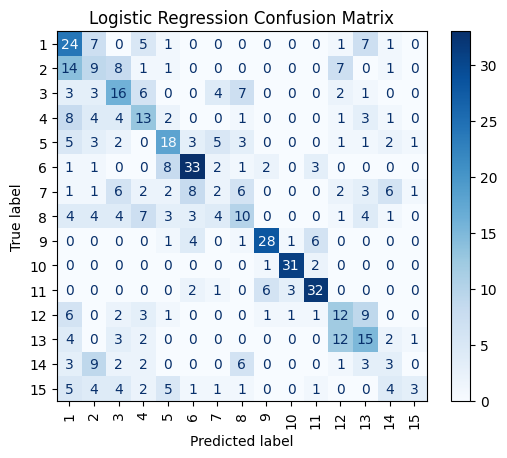

              precision    recall  f1-score   support

           1       0.31      0.52      0.39        46
           2       0.20      0.22      0.21        41
           3       0.31      0.38      0.34        42
           4       0.30      0.35      0.33        37
           5       0.43      0.41      0.42        44
           6       0.61      0.65      0.63        51
           7       0.11      0.05      0.07        40
           8       0.28      0.22      0.25        45
           9       0.74      0.68      0.71        41
          10       0.86      0.91      0.89        34
          11       0.71      0.73      0.72        44
          12       0.30      0.33      0.32        36
          13       0.33      0.38      0.35        39
          14       0.14      0.10      0.12        29
          15       0.50      0.10      0.16        31

    accuracy                           0.41       600
   macro avg       0.41      0.40      0.39       600
weighted avg       0.41   

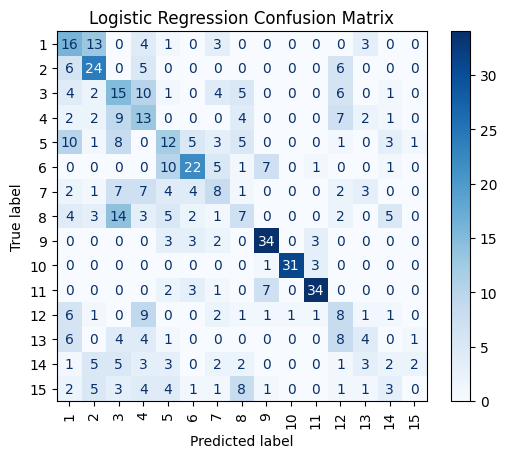

              precision    recall  f1-score   support

           1       0.27      0.40      0.32        40
           2       0.42      0.59      0.49        41
           3       0.23      0.31      0.27        48
           4       0.21      0.33      0.25        40
           5       0.26      0.24      0.25        49
           6       0.55      0.47      0.51        47
           7       0.25      0.21      0.23        39
           8       0.21      0.15      0.17        46
           9       0.67      0.76      0.71        45
          10       0.97      0.89      0.93        35
          11       0.81      0.72      0.76        47
          12       0.19      0.25      0.22        32
          13       0.24      0.14      0.18        28
          14       0.12      0.07      0.09        29
          15       0.00      0.00      0.00        34

    accuracy                           0.38       600
   macro avg       0.36      0.37      0.36       600
weighted avg       0.37   

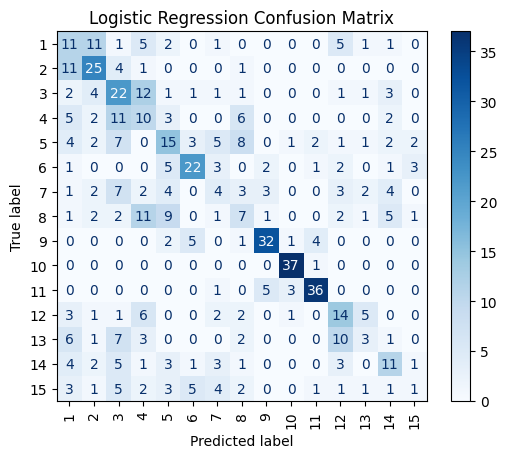

              precision    recall  f1-score   support

           1       0.21      0.29      0.24        38
           2       0.47      0.60      0.53        42
           3       0.31      0.45      0.36        49
           4       0.19      0.26      0.22        39
           5       0.32      0.28      0.30        53
           6       0.59      0.55      0.57        40
           7       0.16      0.11      0.13        35
           8       0.21      0.16      0.18        43
           9       0.74      0.71      0.73        45
          10       0.86      0.97      0.91        38
          11       0.80      0.80      0.80        45
          12       0.33      0.40      0.36        35
          13       0.20      0.09      0.12        33
          14       0.35      0.31      0.33        35
          15       0.12      0.03      0.05        30

    accuracy                           0.42       600
   macro avg       0.39      0.40      0.39       600
weighted avg       0.40   

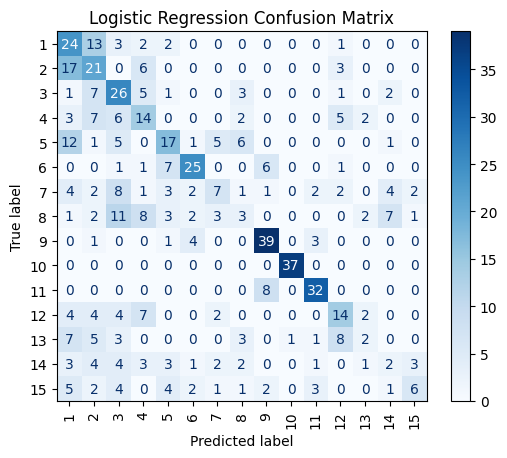

              precision    recall  f1-score   support

           1       0.30      0.53      0.38        45
           2       0.30      0.45      0.36        47
           3       0.35      0.57      0.43        46
           4       0.30      0.36      0.33        39
           5       0.41      0.35      0.38        48
           6       0.68      0.61      0.64        41
           7       0.35      0.18      0.24        39
           8       0.14      0.07      0.09        43
           9       0.70      0.81      0.75        48
          10       0.97      1.00      0.99        37
          11       0.76      0.80      0.78        40
          12       0.40      0.38      0.39        37
          13       0.22      0.07      0.10        30
          14       0.12      0.07      0.09        29
          15       0.50      0.19      0.28        31

    accuracy                           0.45       600
   macro avg       0.43      0.43      0.42       600
weighted avg       0.44   

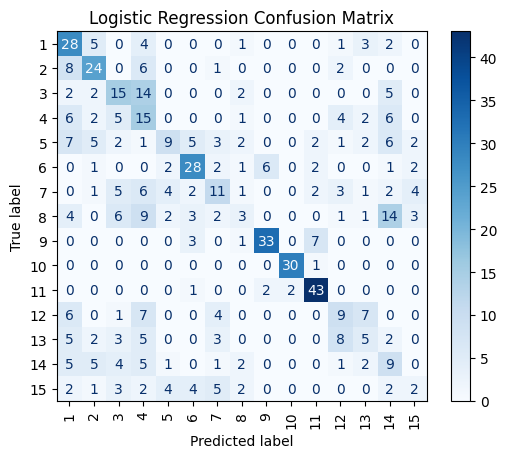

              precision    recall  f1-score   support

           1       0.38      0.64      0.48        44
           2       0.50      0.59      0.54        41
           3       0.34      0.38      0.36        40
           4       0.20      0.37      0.26        41
           5       0.41      0.19      0.26        47
           6       0.61      0.62      0.62        45
           7       0.34      0.26      0.30        42
           8       0.19      0.06      0.09        48
           9       0.80      0.75      0.78        44
          10       0.94      0.97      0.95        31
          11       0.75      0.90      0.82        48
          12       0.30      0.26      0.28        34
          13       0.22      0.15      0.18        33
          14       0.18      0.26      0.21        35
          15       0.15      0.07      0.10        27

    accuracy                           0.44       600
   macro avg       0.42      0.43      0.42       600
weighted avg       0.43   

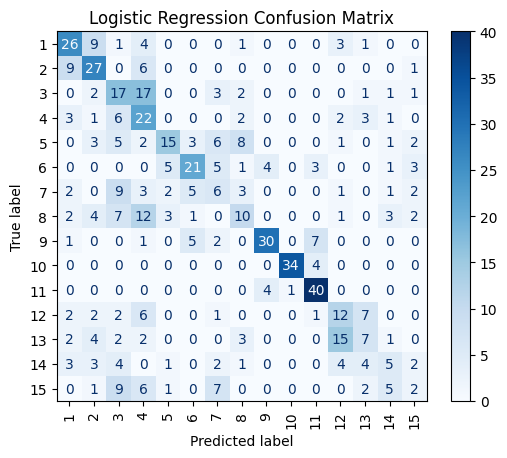

              precision    recall  f1-score   support

           1       0.52      0.58      0.55        45
           2       0.48      0.63      0.55        43
           3       0.27      0.39      0.32        44
           4       0.27      0.55      0.36        40
           5       0.56      0.33      0.41        46
           6       0.60      0.49      0.54        43
           7       0.19      0.18      0.18        34
           8       0.32      0.22      0.26        45
           9       0.79      0.65      0.71        46
          10       0.97      0.89      0.93        38
          11       0.73      0.89      0.80        45
          12       0.31      0.36      0.33        33
          13       0.28      0.19      0.23        36
          14       0.26      0.17      0.21        29
          15       0.13      0.06      0.08        33

    accuracy                           0.46       600
   macro avg       0.45      0.44      0.43       600
weighted avg       0.46   

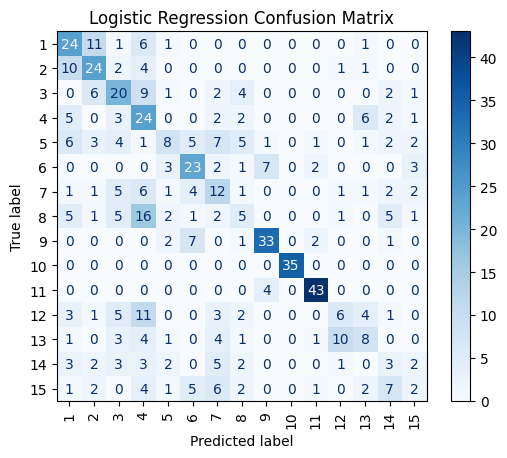

              precision    recall  f1-score   support

           1       0.41      0.55      0.47        44
           2       0.47      0.57      0.52        42
           3       0.39      0.44      0.42        45
           4       0.27      0.53      0.36        45
           5       0.36      0.17      0.24        46
           6       0.51      0.56      0.53        41
           7       0.27      0.32      0.29        37
           8       0.19      0.11      0.14        44
           9       0.73      0.72      0.73        46
          10       1.00      1.00      1.00        35
          11       0.86      0.91      0.89        47
          12       0.30      0.17      0.21        36
          13       0.33      0.24      0.28        33
          14       0.12      0.12      0.12        26
          15       0.14      0.06      0.09        33

    accuracy                           0.45       600
   macro avg       0.42      0.43      0.42       600
weighted avg       0.44   

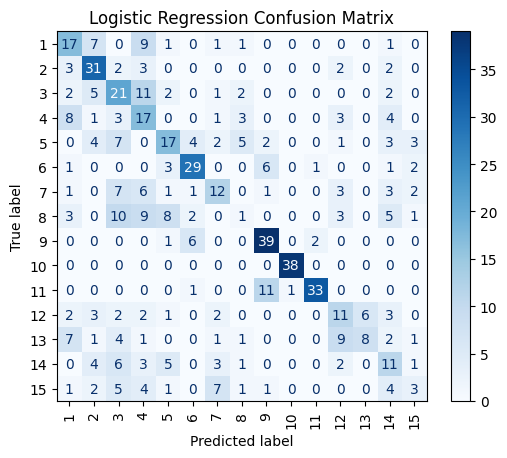

              precision    recall  f1-score   support

           1       0.38      0.46      0.41        37
           2       0.53      0.72      0.61        43
           3       0.31      0.46      0.37        46
           4       0.26      0.42      0.32        40
           5       0.42      0.35      0.39        48
           6       0.67      0.67      0.67        43
           7       0.40      0.32      0.36        37
           8       0.07      0.02      0.04        42
           9       0.65      0.81      0.72        48
          10       0.97      1.00      0.99        38
          11       0.92      0.72      0.80        46
          12       0.32      0.34      0.33        32
          13       0.57      0.23      0.33        35
          14       0.27      0.31      0.29        36
          15       0.23      0.10      0.14        29

    accuracy                           0.48       600
   macro avg       0.47      0.46      0.45       600
weighted avg       0.48   

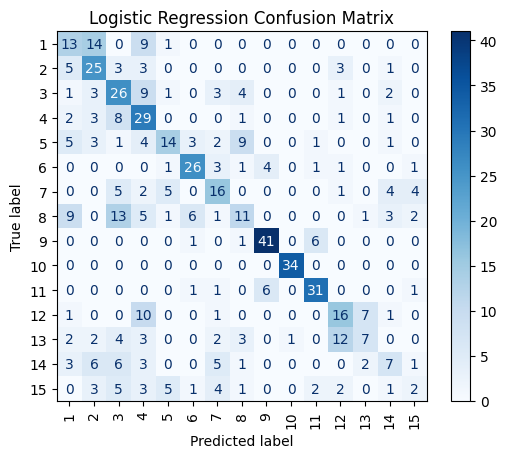

              precision    recall  f1-score   support

           1       0.32      0.35      0.33        37
           2       0.42      0.62      0.51        40
           3       0.37      0.52      0.43        50
           4       0.36      0.64      0.46        45
           5       0.50      0.33      0.39        43
           6       0.68      0.68      0.68        38
           7       0.42      0.43      0.43        37
           8       0.34      0.21      0.26        52
           9       0.80      0.84      0.82        49
          10       0.97      1.00      0.99        34
          11       0.76      0.78      0.77        40
          12       0.43      0.44      0.44        36
          13       0.41      0.19      0.26        36
          14       0.33      0.21      0.25        34
          15       0.18      0.07      0.10        29

    accuracy                           0.50       600
   macro avg       0.49      0.49      0.48       600
weighted avg       0.49   

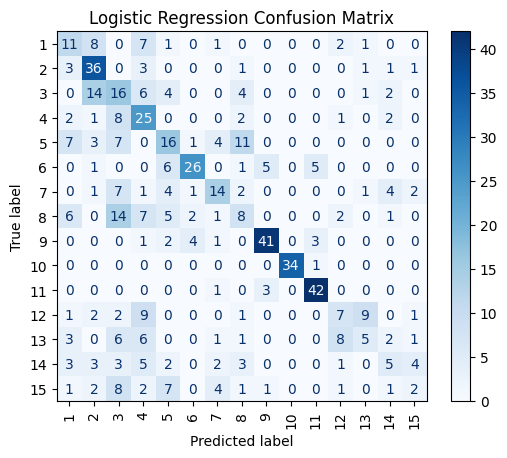

              precision    recall  f1-score   support

           1       0.30      0.35      0.32        31
           2       0.51      0.78      0.62        46
           3       0.23      0.34      0.27        47
           4       0.35      0.61      0.44        41
           5       0.34      0.33      0.33        49
           6       0.76      0.59      0.67        44
           7       0.48      0.38      0.42        37
           8       0.23      0.17      0.20        46
           9       0.82      0.79      0.80        52
          10       1.00      0.97      0.99        35
          11       0.82      0.91      0.87        46
          12       0.32      0.22      0.26        32
          13       0.28      0.15      0.20        33
          14       0.28      0.16      0.20        31
          15       0.18      0.07      0.10        30

    accuracy                           0.48       600
   macro avg       0.46      0.46      0.45       600
weighted avg       0.48   

feature_set                model        cv_type  cv_accuracy  \
0   Feature_W100_Olap0  Logistic Regression  Stratified-5F     0.405714   
1  Feature_W100_Olap50  Logistic Regression  Stratified-5F     0.413571   
2   Feature_W200_Olap0  Logistic Regression  Stratified-5F     0.405000   
3  Feature_W200_Olap50  Logistic Regression  Stratified-5F     0.437143   
4   Feature_W300_Olap0  Logistic Regression  Stratified-5F     0.433571   
5  Feature_W300_Olap50  Logistic Regression  Stratified-5F     0.475000   
6   Feature_W400_Olap0  Logistic Regression  Stratified-5F     0.470714   
7  Feature_W400_Olap50  Logistic Regression  Stratified-5F     0.466429   
8   Feature_W500_Olap0  Logistic Regression  Stratified-5F     0.475000   
9  Feature_W500_Olap50  Logistic Regression  Stratified-5F     0.470000   

      cv_f1  cv_recall  cv_precision  
0  0.382969   0.393792      0.386117  
1  0.383051   0.394461      0.397139  
2  0.372653   0.388379      0.382055  
3  0.403575   0.417560      0.403603  
4  0.415272   0.425223      0.429624  
5  0.449542   0.459437      0.466227  
6  0.435793   0.449147      0.450508  
7  0.435258   0.449069      0.467408  
8  0.464376   0.470523      0.486139  
9  0.433808   0.447221      0.437650

### Hyperparameter Tuning & Test Metrics ###


feature_set                model       tuning_method  \
0   Feature_W100_Olap0  Logistic Regression  RandomizedSearchCV   
1  Feature_W100_Olap50  Logistic Regression  RandomizedSearchCV   
2   Feature_W200_Olap0  Logistic Regression  RandomizedSearchCV   
3  Feature_W200_Olap50  Logistic Regression  RandomizedSearchCV   
4   Feature_W300_Olap0  Logistic Regression  RandomizedSearchCV   
5  Feature_W300_Olap50  Logistic Regression  RandomizedSearchCV   
6   Feature_W400_Olap0  Logistic Regression  RandomizedSearchCV   
7  Feature_W400_Olap50  Logistic Regression  RandomizedSearchCV   
8   Feature_W500_Olap0  Logistic Regression  RandomizedSearchCV   
9  Feature_W500_Olap50  Logistic Regression  RandomizedSearchCV   

                             best_params  test_accuracy   test_f1  \
0   {'clf__penalty': 'l1', 'clf__C': 10}       0.415000  0.392796   
1   {'clf__penalty': 'l2', 'clf__C': 10}       0.383333  0.358057   
2  {'clf__penalty': 'l1', 'clf__C': 100}       0.416667  0.390255   
3   {'clf__penalty': 'l1', 'clf__C': 10}       0.448333  0.415138   
4   {'clf__penalty': 'l1', 'clf__C': 10}       0.440000  0.415019   
5  {'clf__penalty': 'l1', 'clf__C': 100}       0.456667  0.431461   
6   {'clf__penalty': 'l1', 'clf__C': 10}       0.450000  0.418337   
7   {'clf__penalty': 'l1', 'clf__C': 10}       0.480000  0.452041   
8   {'clf__penalty': 'l1', 'clf__C': 10}       0.496667  0.475152   
9   {'clf__penalty': 'l1', 'clf__C': 10}       0.480000  0.445783   

   test_precision  test_recall  
0        0.408298     0.402804  
1        0.359186     0.367977  
2        0.391661     0.401568  
3        0.433349     0.429171  
4        0.421859     0.430781  
5        0.445729     0.438807  
6        0.424367     0.432325  
7        0.465891     0.463323  
8        0.487287     0.488002  
9        0.459497     0.455234

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# 1) Pipeline
lr_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf',   LogisticRegression(solver='liblinear', random_state=42))
])

# 2) Hyperparameter space
lr_params = {
    'clf__C':       [0.01, 0.1, 1, 10, 100],
    'clf__penalty': ['l1', 'l2']
}

# 3) Run evaluation (n_iter=10 covers 5×2 combos)
lr_df = evaluate_model(
    model_name='Logistic Regression',
    pipeline=lr_pipe,
    param_dist=lr_params,
    n_iter=10
)

# 4) Split into tuning & CV summary tables
tune_lr, cv_lr = summarize(lr_df)


## Decision Tree Evaluation



>> Decision Tree on Feature_W100_Olap0.csv <<


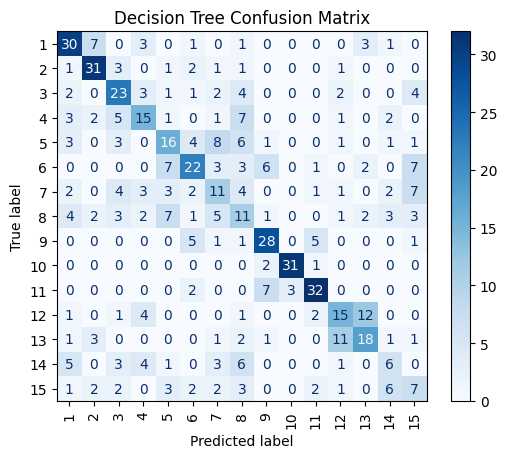

              precision    recall  f1-score   support

           1       0.57      0.65      0.61        46
           2       0.66      0.76      0.70        41
           3       0.49      0.55      0.52        42
           4       0.44      0.41      0.42        37
           5       0.40      0.36      0.38        44
           6       0.52      0.43      0.47        51
           7       0.29      0.28      0.28        40
           8       0.22      0.24      0.23        45
           9       0.61      0.68      0.64        41
          10       0.91      0.91      0.91        34
          11       0.73      0.73      0.73        44
          12       0.43      0.42      0.42        36
          13       0.49      0.46      0.47        39
          14       0.27      0.21      0.24        29
          15       0.23      0.23      0.23        31

    accuracy                           0.49       600
   macro avg       0.48      0.49      0.48       600
weighted avg       0.49   

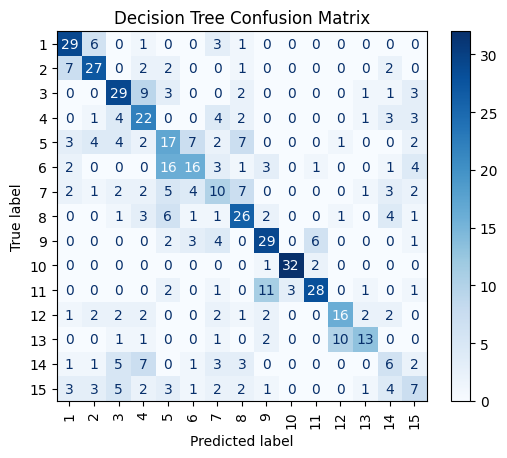

              precision    recall  f1-score   support

           1       0.60      0.72      0.66        40
           2       0.60      0.66      0.63        41
           3       0.55      0.60      0.57        48
           4       0.42      0.55      0.47        40
           5       0.30      0.35      0.32        49
           6       0.48      0.34      0.40        47
           7       0.28      0.26      0.27        39
           8       0.49      0.57      0.53        46
           9       0.57      0.64      0.60        45
          10       0.91      0.91      0.91        35
          11       0.76      0.60      0.67        47
          12       0.57      0.50      0.53        32
          13       0.65      0.46      0.54        28
          14       0.23      0.21      0.22        29
          15       0.27      0.21      0.23        34

    accuracy                           0.51       600
   macro avg       0.51      0.51      0.50       600
weighted avg       0.51   

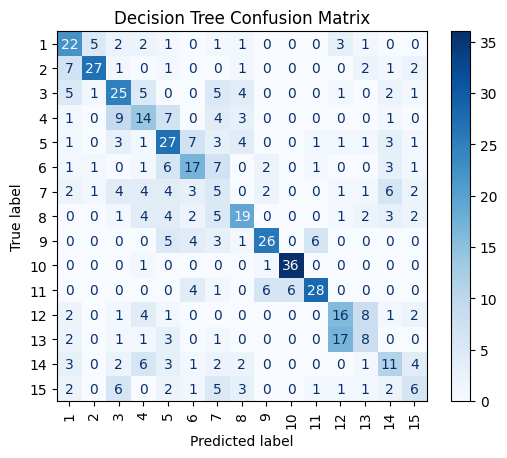

              precision    recall  f1-score   support

           1       0.46      0.58      0.51        38
           2       0.77      0.64      0.70        42
           3       0.45      0.51      0.48        49
           4       0.33      0.36      0.34        39
           5       0.42      0.51      0.46        53
           6       0.44      0.42      0.43        40
           7       0.12      0.14      0.13        35
           8       0.50      0.44      0.47        43
           9       0.70      0.58      0.63        45
          10       0.86      0.95      0.90        38
          11       0.76      0.62      0.68        45
          12       0.39      0.46      0.42        35
          13       0.32      0.24      0.28        33
          14       0.33      0.31      0.32        35
          15       0.29      0.20      0.24        30

    accuracy                           0.48       600
   macro avg       0.48      0.46      0.47       600
weighted avg       0.49   

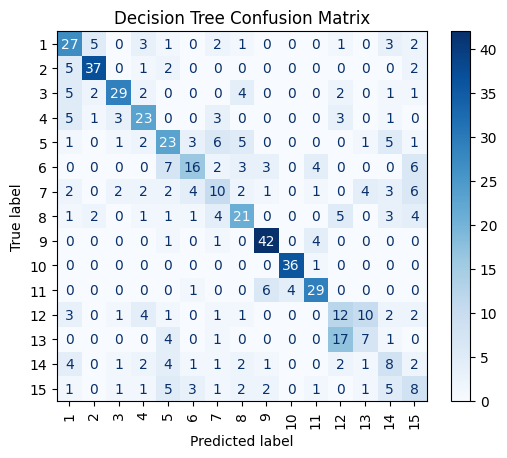

              precision    recall  f1-score   support

           1       0.50      0.60      0.55        45
           2       0.79      0.79      0.79        47
           3       0.76      0.63      0.69        46
           4       0.56      0.59      0.57        39
           5       0.45      0.48      0.46        48
           6       0.55      0.39      0.46        41
           7       0.31      0.26      0.28        39
           8       0.51      0.49      0.50        43
           9       0.76      0.88      0.82        48
          10       0.90      0.97      0.94        37
          11       0.72      0.72      0.72        40
          12       0.29      0.32      0.30        37
          13       0.29      0.23      0.26        30
          14       0.25      0.28      0.26        29
          15       0.24      0.26      0.25        31

    accuracy                           0.55       600
   macro avg       0.53      0.53      0.52       600
weighted avg       0.55   

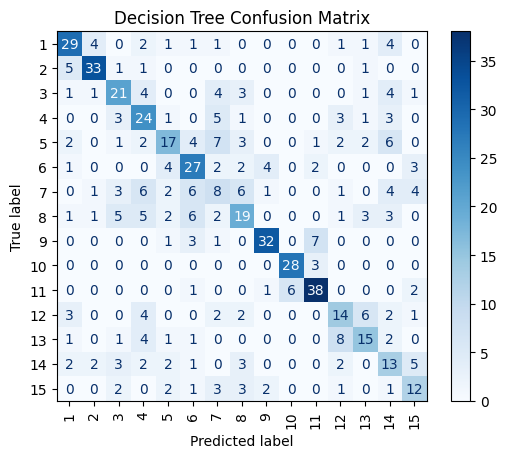

              precision    recall  f1-score   support

           1       0.64      0.66      0.65        44
           2       0.79      0.80      0.80        41
           3       0.53      0.53      0.53        40
           4       0.44      0.59      0.51        41
           5       0.52      0.36      0.42        47
           6       0.53      0.60      0.56        45
           7       0.23      0.19      0.21        42
           8       0.45      0.40      0.42        48
           9       0.80      0.73      0.76        44
          10       0.82      0.90      0.86        31
          11       0.75      0.79      0.77        48
          12       0.42      0.41      0.42        34
          13       0.50      0.45      0.48        33
          14       0.31      0.37      0.34        35
          15       0.43      0.44      0.44        27

    accuracy                           0.55       600
   macro avg       0.54      0.55      0.54       600
weighted avg       0.55   

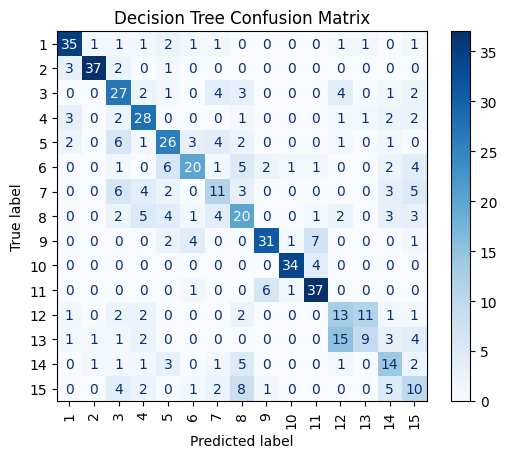

              precision    recall  f1-score   support

           1       0.78      0.78      0.78        45
           2       0.93      0.86      0.89        43
           3       0.49      0.61      0.55        44
           4       0.58      0.70      0.64        40
           5       0.55      0.57      0.56        46
           6       0.65      0.47      0.54        43
           7       0.39      0.32      0.35        34
           8       0.41      0.44      0.43        45
           9       0.78      0.67      0.72        46
          10       0.92      0.89      0.91        38
          11       0.74      0.82      0.78        45
          12       0.34      0.39      0.37        33
          13       0.41      0.25      0.31        36
          14       0.40      0.48      0.44        29
          15       0.29      0.30      0.29        33

    accuracy                           0.59       600
   macro avg       0.58      0.57      0.57       600
weighted avg       0.59   

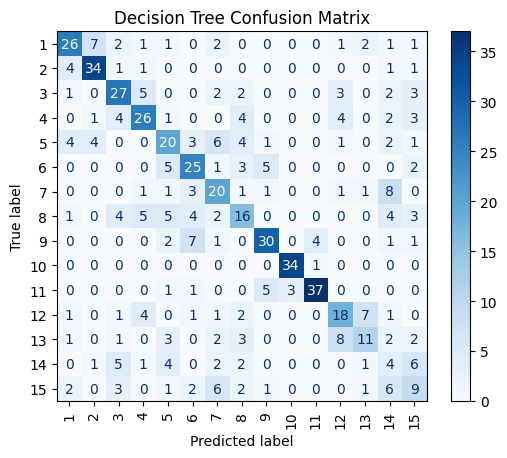

              precision    recall  f1-score   support

           1       0.65      0.59      0.62        44
           2       0.72      0.81      0.76        42
           3       0.56      0.60      0.58        45
           4       0.59      0.58      0.58        45
           5       0.45      0.43      0.44        46
           6       0.54      0.61      0.57        41
           7       0.44      0.54      0.49        37
           8       0.41      0.36      0.39        44
           9       0.70      0.65      0.67        46
          10       0.92      0.97      0.94        35
          11       0.88      0.79      0.83        47
          12       0.50      0.50      0.50        36
          13       0.48      0.33      0.39        33
          14       0.12      0.15      0.13        26
          15       0.28      0.27      0.28        33

    accuracy                           0.56       600
   macro avg       0.55      0.55      0.55       600
weighted avg       0.57   

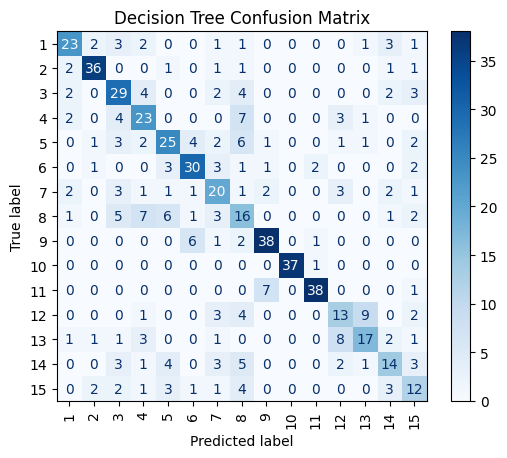

              precision    recall  f1-score   support

           1       0.70      0.62      0.66        37
           2       0.84      0.84      0.84        43
           3       0.55      0.63      0.59        46
           4       0.51      0.57      0.54        40
           5       0.58      0.52      0.55        48
           6       0.70      0.70      0.70        43
           7       0.49      0.54      0.51        37
           8       0.31      0.38      0.34        42
           9       0.78      0.79      0.78        48
          10       1.00      0.97      0.99        38
          11       0.90      0.83      0.86        46
          12       0.43      0.41      0.42        32
          13       0.57      0.49      0.52        35
          14       0.50      0.39      0.44        36
          15       0.39      0.41      0.40        29

    accuracy                           0.62       600
   macro avg       0.62      0.61      0.61       600
weighted avg       0.63   

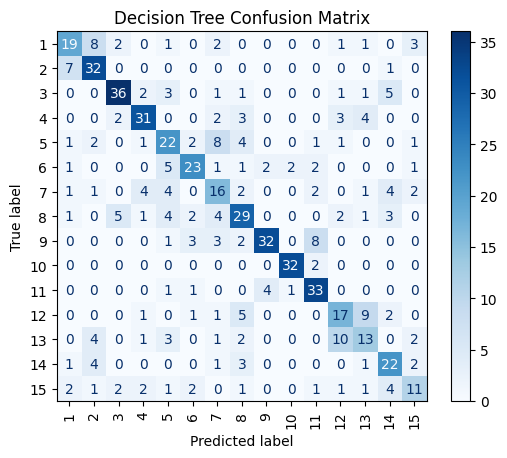

              precision    recall  f1-score   support

           1       0.58      0.51      0.54        37
           2       0.62      0.80      0.70        40
           3       0.77      0.72      0.74        50
           4       0.72      0.69      0.70        45
           5       0.49      0.51      0.50        43
           6       0.68      0.61      0.64        38
           7       0.40      0.43      0.42        37
           8       0.55      0.56      0.55        52
           9       0.84      0.65      0.74        49
          10       0.91      0.94      0.93        34
          11       0.67      0.82      0.74        40
          12       0.47      0.47      0.47        36
          13       0.41      0.36      0.38        36
          14       0.54      0.65      0.59        34
          15       0.50      0.38      0.43        29

    accuracy                           0.61       600
   macro avg       0.61      0.61      0.60       600
weighted avg       0.62   

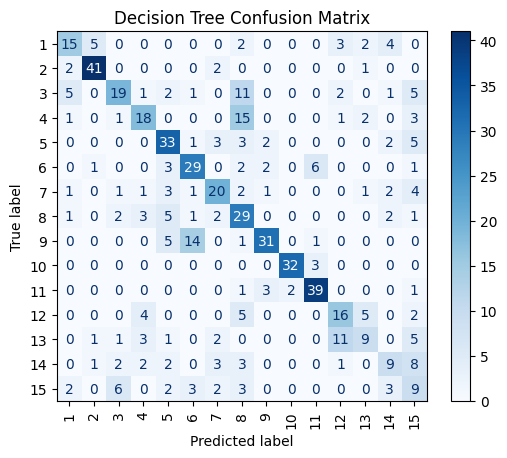

              precision    recall  f1-score   support

           1       0.56      0.48      0.52        31
           2       0.84      0.89      0.86        46
           3       0.59      0.40      0.48        47
           4       0.56      0.44      0.49        41
           5       0.59      0.67      0.63        49
           6       0.58      0.66      0.62        44
           7       0.59      0.54      0.56        37
           8       0.38      0.63      0.47        46
           9       0.79      0.60      0.68        52
          10       0.94      0.91      0.93        35
          11       0.80      0.85      0.82        46
          12       0.47      0.50      0.48        32
          13       0.45      0.27      0.34        33
          14       0.39      0.29      0.33        31
          15       0.20      0.30      0.24        30

    accuracy                           0.58       600
   macro avg       0.58      0.56      0.56       600
weighted avg       0.60   

feature_set          model        cv_type  cv_accuracy     cv_f1  \
0   Feature_W100_Olap0  Decision Tree  Stratified-5F     0.470000  0.459234   
1  Feature_W100_Olap50  Decision Tree  Stratified-5F     0.471429  0.458438   
2   Feature_W200_Olap0  Decision Tree  Stratified-5F     0.497857  0.481543   
3  Feature_W200_Olap50  Decision Tree  Stratified-5F     0.513571  0.495944   
4   Feature_W300_Olap0  Decision Tree  Stratified-5F     0.502857  0.496002   
5  Feature_W300_Olap50  Decision Tree  Stratified-5F     0.556429  0.543637   
6   Feature_W400_Olap0  Decision Tree  Stratified-5F     0.537143  0.521491   
7  Feature_W400_Olap50  Decision Tree  Stratified-5F     0.572857  0.559048   
8   Feature_W500_Olap0  Decision Tree  Stratified-5F     0.580000  0.564175   
9  Feature_W500_Olap50  Decision Tree  Stratified-5F     0.580714  0.557637   

   cv_recall  cv_precision  
0   0.462174      0.469138  
1   0.463721      0.470180  
2   0.484446      0.490375  
3   0.499296      0.504069  
4   0.497848      0.503419  
5   0.544241      0.551149  
6   0.521579      0.532448  
7   0.559781      0.567610  
8   0.569262      0.570515  
9   0.563727      0.574123

### Hyperparameter Tuning & Test Metrics ###


feature_set          model       tuning_method  \
0   Feature_W100_Olap0  Decision Tree  RandomizedSearchCV   
1  Feature_W100_Olap50  Decision Tree  RandomizedSearchCV   
2   Feature_W200_Olap0  Decision Tree  RandomizedSearchCV   
3  Feature_W200_Olap50  Decision Tree  RandomizedSearchCV   
4   Feature_W300_Olap0  Decision Tree  RandomizedSearchCV   
5  Feature_W300_Olap50  Decision Tree  RandomizedSearchCV   
6   Feature_W400_Olap0  Decision Tree  RandomizedSearchCV   
7  Feature_W400_Olap50  Decision Tree  RandomizedSearchCV   
8   Feature_W500_Olap0  Decision Tree  RandomizedSearchCV   
9  Feature_W500_Olap50  Decision Tree  RandomizedSearchCV   

                                         best_params  test_accuracy   test_f1  \
0  {'clf__min_samples_split': 5, 'clf__min_sample...       0.493333  0.483849   
1  {'clf__min_samples_split': 5, 'clf__min_sample...       0.511667  0.504116   
2  {'clf__min_samples_split': 5, 'clf__min_sample...       0.478333  0.466593   
3  {'clf__min_samples_split': 2, 'clf__min_sample...       0.546667  0.523250   
4  {'clf__min_samples_split': 2, 'clf__min_sample...       0.550000  0.543593   
5  {'clf__min_samples_split': 2, 'clf__min_sample...       0.586667  0.569728   
6  {'clf__min_samples_split': 2, 'clf__min_sample...       0.561667  0.546246   
7  {'clf__min_samples_split': 2, 'clf__min_sample...       0.618333  0.609033   
8  {'clf__min_samples_split': 2, 'clf__min_sample...       0.613333  0.604636   
9  {'clf__min_samples_split': 5, 'clf__min_sample...       0.581667  0.564402   

   test_precision  test_recall  
0        0.483384     0.487241  
1        0.512286     0.505216  
2        0.475507     0.464757  
3        0.526005     0.525744  
4        0.543739     0.548446  
5        0.576482     0.571386  
6        0.550283     0.546511  
7        0.615626     0.606023  
8        0.609032     0.607224  
9        0.582073     0.562887

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

# 1) Pipeline
dt_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf',   DecisionTreeClassifier(random_state=42))
])

# 2) Hyperparameter space
dt_params = {
    'clf__max_depth':         [None, 10, 20, 30, 50],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf':  [1, 2, 4],
    'clf__criterion':         ['gini', 'entropy']
}

# 3) Run evaluation (n_iter=10 for a quick, representative sample)
dt_df = evaluate_model(
    model_name='Decision Tree',
    pipeline=dt_pipe,
    param_dist=dt_params,
    n_iter=10
)

# 4) Split into tuning & CV tables
tune_dt, cv_dt = summarize(dt_df)


## Random Forest Evaluation



>> Random Forest on Feature_W100_Olap0.csv <<


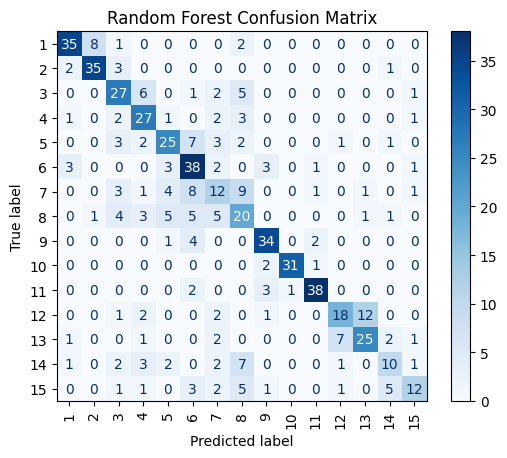

              precision    recall  f1-score   support

           1       0.81      0.76      0.79        46
           2       0.80      0.85      0.82        41
           3       0.57      0.64      0.61        42
           4       0.59      0.73      0.65        37
           5       0.61      0.57      0.59        44
           6       0.56      0.75      0.64        51
           7       0.35      0.30      0.32        40
           8       0.38      0.44      0.41        45
           9       0.77      0.83      0.80        41
          10       0.97      0.91      0.94        34
          11       0.88      0.86      0.87        44
          12       0.64      0.50      0.56        36
          13       0.64      0.64      0.64        39
          14       0.50      0.34      0.41        29
          15       0.67      0.39      0.49        31

    accuracy                           0.65       600
   macro avg       0.65      0.63      0.64       600
weighted avg       0.65   

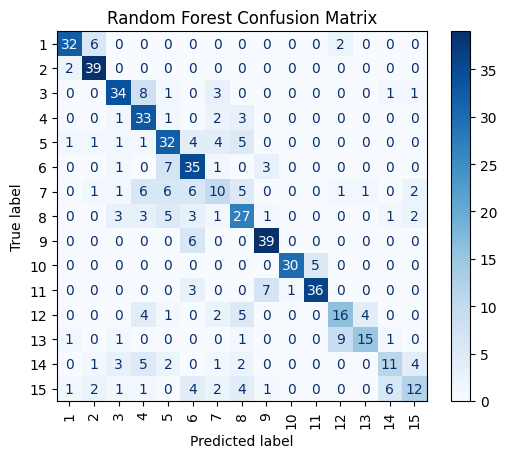

              precision    recall  f1-score   support

           1       0.86      0.80      0.83        40
           2       0.78      0.95      0.86        41
           3       0.74      0.71      0.72        48
           4       0.54      0.82      0.65        40
           5       0.58      0.65      0.62        49
           6       0.57      0.74      0.65        47
           7       0.38      0.26      0.31        39
           8       0.52      0.59      0.55        46
           9       0.76      0.87      0.81        45
          10       0.97      0.86      0.91        35
          11       0.88      0.77      0.82        47
          12       0.57      0.50      0.53        32
          13       0.75      0.54      0.62        28
          14       0.55      0.38      0.45        29
          15       0.57      0.35      0.44        34

    accuracy                           0.67       600
   macro avg       0.67      0.65      0.65       600
weighted avg       0.67   

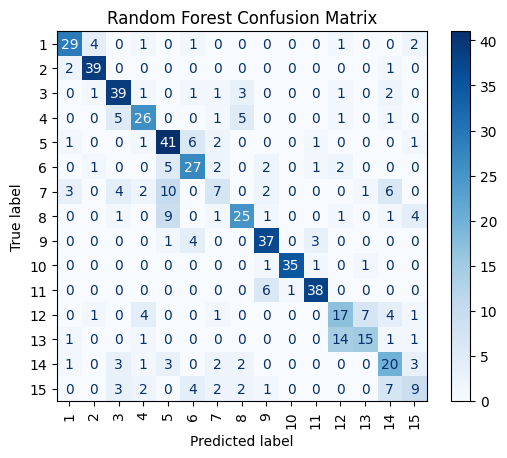

              precision    recall  f1-score   support

           1       0.78      0.76      0.77        38
           2       0.85      0.93      0.89        42
           3       0.71      0.80      0.75        49
           4       0.67      0.67      0.67        39
           5       0.59      0.77      0.67        53
           6       0.63      0.68      0.65        40
           7       0.37      0.20      0.26        35
           8       0.68      0.58      0.62        43
           9       0.74      0.82      0.78        45
          10       0.97      0.92      0.95        38
          11       0.86      0.84      0.85        45
          12       0.46      0.49      0.47        35
          13       0.62      0.45      0.53        33
          14       0.47      0.57      0.51        35
          15       0.43      0.30      0.35        30

    accuracy                           0.67       600
   macro avg       0.66      0.65      0.65       600
weighted avg       0.67   

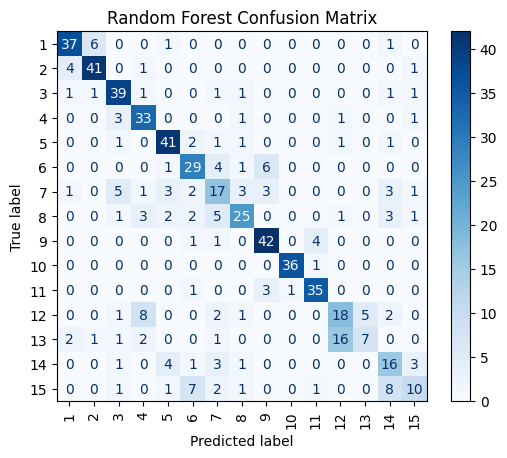

              precision    recall  f1-score   support

           1       0.82      0.82      0.82        45
           2       0.84      0.87      0.85        47
           3       0.74      0.85      0.79        46
           4       0.67      0.85      0.75        39
           5       0.77      0.85      0.81        48
           6       0.64      0.71      0.67        41
           7       0.46      0.44      0.45        39
           8       0.71      0.58      0.64        43
           9       0.78      0.88      0.82        48
          10       0.97      0.97      0.97        37
          11       0.85      0.88      0.86        40
          12       0.49      0.49      0.49        37
          13       0.58      0.23      0.33        30
          14       0.46      0.55      0.50        29
          15       0.56      0.32      0.41        31

    accuracy                           0.71       600
   macro avg       0.69      0.69      0.68       600
weighted avg       0.70   

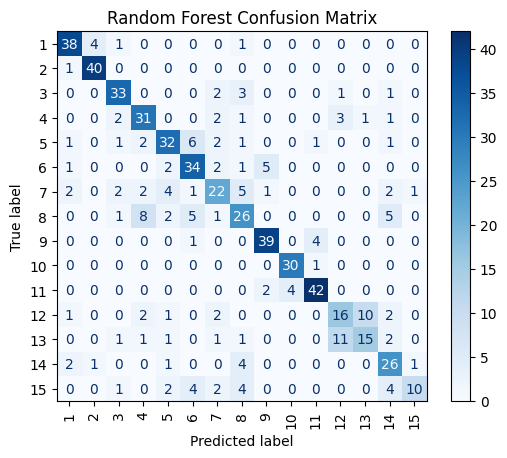

              precision    recall  f1-score   support

           1       0.83      0.86      0.84        44
           2       0.89      0.98      0.93        41
           3       0.79      0.82      0.80        40
           4       0.67      0.76      0.71        41
           5       0.71      0.68      0.70        47
           6       0.67      0.76      0.71        45
           7       0.61      0.52      0.56        42
           8       0.55      0.54      0.55        48
           9       0.83      0.89      0.86        44
          10       0.88      0.97      0.92        31
          11       0.88      0.88      0.88        48
          12       0.52      0.47      0.49        34
          13       0.58      0.45      0.51        33
          14       0.59      0.74      0.66        35
          15       0.83      0.37      0.51        27

    accuracy                           0.72       600
   macro avg       0.72      0.71      0.71       600
weighted avg       0.72   

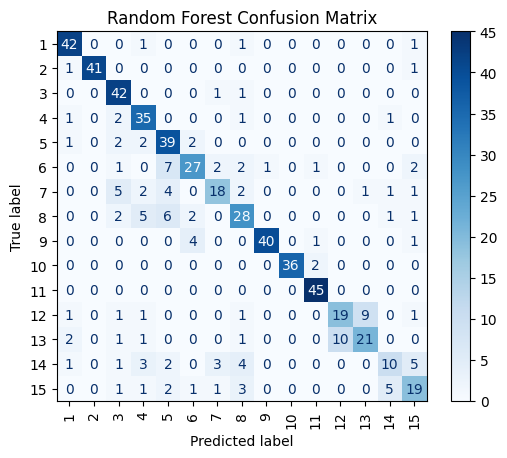

              precision    recall  f1-score   support

           1       0.86      0.93      0.89        45
           2       1.00      0.95      0.98        43
           3       0.72      0.95      0.82        44
           4       0.69      0.88      0.77        40
           5       0.65      0.85      0.74        46
           6       0.75      0.63      0.68        43
           7       0.72      0.53      0.61        34
           8       0.64      0.62      0.63        45
           9       0.98      0.87      0.92        46
          10       1.00      0.95      0.97        38
          11       0.92      1.00      0.96        45
          12       0.66      0.58      0.61        33
          13       0.68      0.58      0.63        36
          14       0.56      0.34      0.43        29
          15       0.59      0.58      0.58        33

    accuracy                           0.77       600
   macro avg       0.76      0.75      0.75       600
weighted avg       0.77   

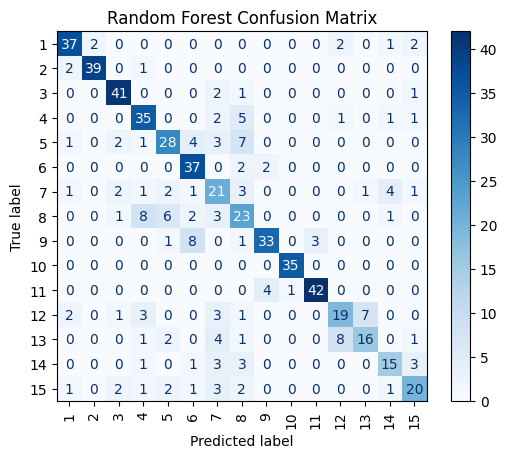

              precision    recall  f1-score   support

           1       0.84      0.84      0.84        44
           2       0.95      0.93      0.94        42
           3       0.84      0.91      0.87        45
           4       0.67      0.78      0.72        45
           5       0.68      0.61      0.64        46
           6       0.69      0.90      0.78        41
           7       0.48      0.57      0.52        37
           8       0.47      0.52      0.49        44
           9       0.85      0.72      0.78        46
          10       0.97      1.00      0.99        35
          11       0.93      0.89      0.91        47
          12       0.63      0.53      0.58        36
          13       0.67      0.48      0.56        33
          14       0.65      0.58      0.61        26
          15       0.69      0.61      0.65        33

    accuracy                           0.73       600
   macro avg       0.73      0.72      0.73       600
weighted avg       0.74   

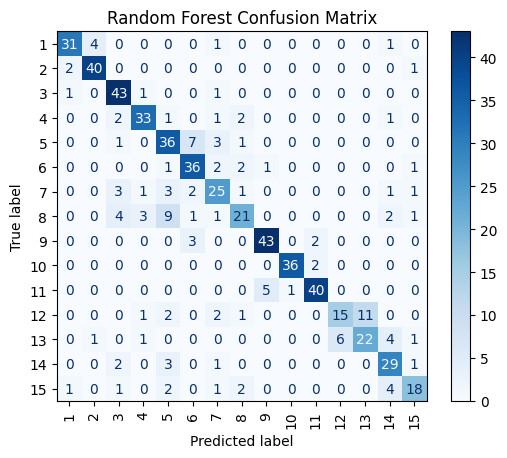

              precision    recall  f1-score   support

           1       0.89      0.84      0.86        37
           2       0.89      0.93      0.91        43
           3       0.77      0.93      0.84        46
           4       0.82      0.82      0.82        40
           5       0.63      0.75      0.69        48
           6       0.73      0.84      0.78        43
           7       0.66      0.68      0.67        37
           8       0.70      0.50      0.58        42
           9       0.88      0.90      0.89        48
          10       0.97      0.95      0.96        38
          11       0.91      0.87      0.89        46
          12       0.71      0.47      0.57        32
          13       0.67      0.63      0.65        35
          14       0.69      0.81      0.74        36
          15       0.75      0.62      0.68        29

    accuracy                           0.78       600
   macro avg       0.78      0.77      0.77       600
weighted avg       0.78   

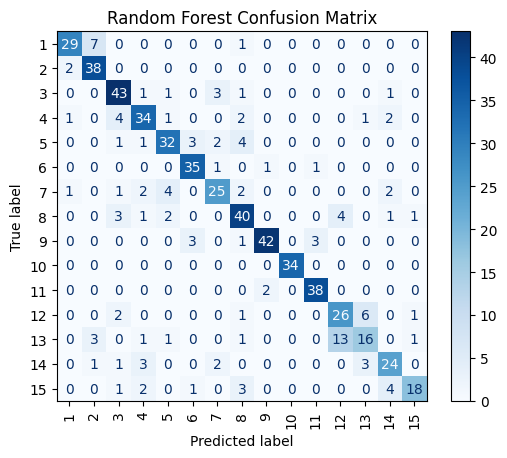

              precision    recall  f1-score   support

           1       0.88      0.78      0.83        37
           2       0.78      0.95      0.85        40
           3       0.77      0.86      0.81        50
           4       0.76      0.76      0.76        45
           5       0.78      0.74      0.76        43
           6       0.83      0.92      0.88        38
           7       0.76      0.68      0.71        37
           8       0.71      0.77      0.74        52
           9       0.93      0.86      0.89        49
          10       1.00      1.00      1.00        34
          11       0.90      0.95      0.93        40
          12       0.60      0.72      0.66        36
          13       0.62      0.44      0.52        36
          14       0.71      0.71      0.71        34
          15       0.86      0.62      0.72        29

    accuracy                           0.79       600
   macro avg       0.79      0.78      0.78       600
weighted avg       0.79   

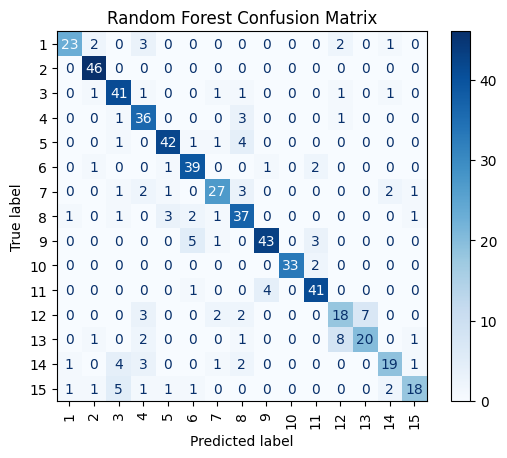

              precision    recall  f1-score   support

           1       0.88      0.74      0.81        31
           2       0.88      1.00      0.94        46
           3       0.76      0.87      0.81        47
           4       0.71      0.88      0.78        41
           5       0.88      0.86      0.87        49
           6       0.80      0.89      0.84        44
           7       0.79      0.73      0.76        37
           8       0.70      0.80      0.75        46
           9       0.90      0.83      0.86        52
          10       1.00      0.94      0.97        35
          11       0.85      0.89      0.87        46
          12       0.60      0.56      0.58        32
          13       0.74      0.61      0.67        33
          14       0.76      0.61      0.68        31
          15       0.82      0.60      0.69        30

    accuracy                           0.81       600
   macro avg       0.80      0.79      0.79       600
weighted avg       0.81   

feature_set          model        cv_type  cv_accuracy     cv_f1  \
0   Feature_W100_Olap0  Random Forest  Stratified-5F     0.624286  0.606596   
1  Feature_W100_Olap50  Random Forest  Stratified-5F     0.621429  0.603522   
2   Feature_W200_Olap0  Random Forest  Stratified-5F     0.655000  0.631940   
3  Feature_W200_Olap50  Random Forest  Stratified-5F     0.684286  0.662962   
4   Feature_W300_Olap0  Random Forest  Stratified-5F     0.692143  0.677030   
5  Feature_W300_Olap50  Random Forest  Stratified-5F     0.737143  0.716644   
6   Feature_W400_Olap0  Random Forest  Stratified-5F     0.723571  0.705909   
7  Feature_W400_Olap50  Random Forest  Stratified-5F     0.751429  0.737785   
8   Feature_W500_Olap0  Random Forest  Stratified-5F     0.756429  0.745699   
9  Feature_W500_Olap50  Random Forest  Stratified-5F     0.755714  0.739372   

   cv_recall  cv_precision  
0   0.611139      0.620428  
1   0.606294      0.617447  
2   0.635546      0.646805  
3   0.665667      0.673500  
4   0.679409      0.687379  
5   0.720636      0.725327  
6   0.706929      0.716220  
7   0.738104      0.752755  
8   0.743690      0.765623  
9   0.739600      0.750254

### Hyperparameter Tuning & Test Metrics ###


feature_set          model       tuning_method  \
0   Feature_W100_Olap0  Random Forest  RandomizedSearchCV   
1  Feature_W100_Olap50  Random Forest  RandomizedSearchCV   
2   Feature_W200_Olap0  Random Forest  RandomizedSearchCV   
3  Feature_W200_Olap50  Random Forest  RandomizedSearchCV   
4   Feature_W300_Olap0  Random Forest  RandomizedSearchCV   
5  Feature_W300_Olap50  Random Forest  RandomizedSearchCV   
6   Feature_W400_Olap0  Random Forest  RandomizedSearchCV   
7  Feature_W400_Olap50  Random Forest  RandomizedSearchCV   
8   Feature_W500_Olap0  Random Forest  RandomizedSearchCV   
9  Feature_W500_Olap50  Random Forest  RandomizedSearchCV   

                                         best_params  test_accuracy   test_f1  \
0  {'clf__n_estimators': 200, 'clf__min_samples_s...       0.645000  0.636081   
1  {'clf__n_estimators': 200, 'clf__min_samples_s...       0.668333  0.651392   
2  {'clf__n_estimators': 200, 'clf__min_samples_s...       0.673333  0.648432   
3  {'clf__n_estimators': 200, 'clf__min_samples_s...       0.710000  0.678510   
4  {'clf__n_estimators': 200, 'clf__min_samples_s...       0.723333  0.708980   
5  {'clf__n_estimators': 200, 'clf__min_samples_s...       0.770000  0.748081   
6  {'clf__n_estimators': 200, 'clf__min_samples_s...       0.735000  0.725362   
7  {'clf__n_estimators': 200, 'clf__min_samples_s...       0.780000  0.768539   
8  {'clf__n_estimators': 200, 'clf__min_samples_s...       0.790000  0.784133   
9  {'clf__n_estimators': 200, 'clf__min_samples_s...       0.805000  0.791609   

   test_precision  test_recall  
0        0.649697     0.634831  
1        0.669184     0.652226  
2        0.655172     0.652247  
3        0.689798     0.685628  
4        0.721408     0.712646  
5        0.759986     0.749356  
6        0.734017     0.724428  
7        0.778178     0.768471  
8        0.792303     0.783991  
9        0.804430     0.787497

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# 1) Pipeline
rf_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf',   RandomForestClassifier(random_state=42))
])

# 2) Hyperparameter space
rf_params = {
    'clf__n_estimators':      [50, 100, 200],
    'clf__max_depth':         [None, 10, 20],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf':  [1, 2],
    'clf__bootstrap':         [True, False]
}

# 3) Run evaluation (n_iter=20)
rf_df = evaluate_model(
    model_name='Random Forest',
    pipeline=rf_pipe,
    param_dist=rf_params,
    n_iter=20
)

# 4) Split into tuning & CV tables
tune_rf, cv_rf = summarize(rf_df)


## Gaussian Naive Bayes Evaluation



>> Gaussian Naive Bayes on Feature_W100_Olap0.csv <<


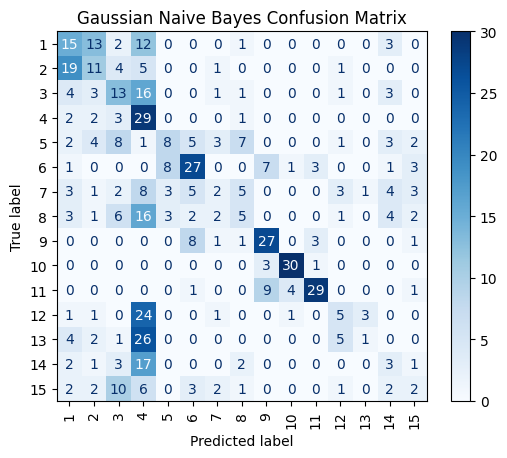

              precision    recall  f1-score   support

           1       0.26      0.33      0.29        46
           2       0.27      0.27      0.27        41
           3       0.25      0.31      0.28        42
           4       0.18      0.78      0.29        37
           5       0.36      0.18      0.24        44
           6       0.53      0.53      0.53        51
           7       0.15      0.05      0.08        40
           8       0.21      0.11      0.14        45
           9       0.59      0.66      0.62        41
          10       0.83      0.88      0.86        34
          11       0.81      0.66      0.72        44
          12       0.28      0.14      0.19        36
          13       0.20      0.03      0.05        39
          14       0.13      0.10      0.12        29
          15       0.13      0.06      0.09        31

    accuracy                           0.34       600
   macro avg       0.35      0.34      0.32       600
weighted avg       0.35   

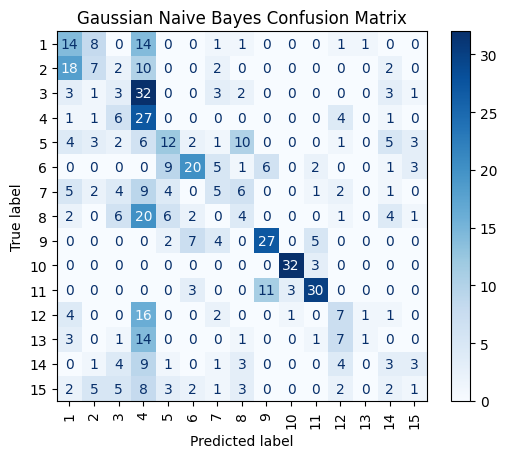

              precision    recall  f1-score   support

           1       0.25      0.35      0.29        40
           2       0.25      0.17      0.20        41
           3       0.09      0.06      0.07        48
           4       0.16      0.68      0.26        40
           5       0.32      0.24      0.28        49
           6       0.56      0.43      0.48        47
           7       0.20      0.13      0.16        39
           8       0.13      0.09      0.10        46
           9       0.61      0.60      0.61        45
          10       0.89      0.91      0.90        35
          11       0.71      0.64      0.67        47
          12       0.24      0.22      0.23        32
          13       0.33      0.04      0.06        28
          14       0.13      0.10      0.12        29
          15       0.08      0.03      0.04        34

    accuracy                           0.32       600
   macro avg       0.33      0.31      0.30       600
weighted avg       0.34   

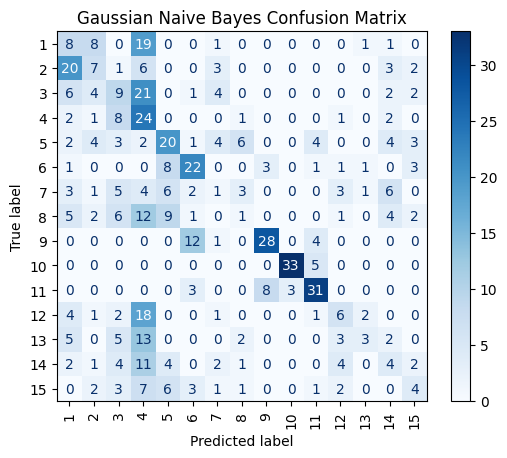

              precision    recall  f1-score   support

           1       0.14      0.21      0.17        38
           2       0.23      0.17      0.19        42
           3       0.20      0.18      0.19        49
           4       0.18      0.62      0.27        39
           5       0.38      0.38      0.38        53
           6       0.49      0.55      0.52        40
           7       0.06      0.03      0.04        35
           8       0.07      0.02      0.03        43
           9       0.72      0.62      0.67        45
          10       0.92      0.87      0.89        38
          11       0.66      0.69      0.67        45
          12       0.29      0.17      0.21        35
          13       0.38      0.09      0.15        33
          14       0.14      0.11      0.13        35
          15       0.22      0.13      0.17        30

    accuracy                           0.34       600
   macro avg       0.34      0.32      0.31       600
weighted avg       0.34   

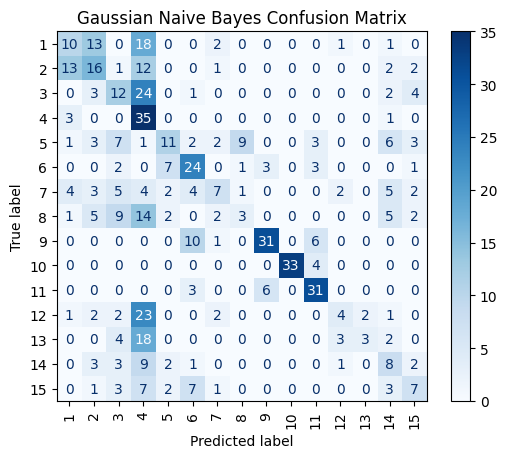

              precision    recall  f1-score   support

           1       0.30      0.22      0.26        45
           2       0.33      0.34      0.33        47
           3       0.25      0.26      0.26        46
           4       0.21      0.90      0.34        39
           5       0.42      0.23      0.30        48
           6       0.46      0.59      0.52        41
           7       0.39      0.18      0.25        39
           8       0.21      0.07      0.11        43
           9       0.78      0.65      0.70        48
          10       1.00      0.89      0.94        37
          11       0.66      0.78      0.71        40
          12       0.36      0.11      0.17        37
          13       0.60      0.10      0.17        30
          14       0.22      0.28      0.25        29
          15       0.30      0.23      0.26        31

    accuracy                           0.39       600
   macro avg       0.43      0.39      0.37       600
weighted avg       0.43   

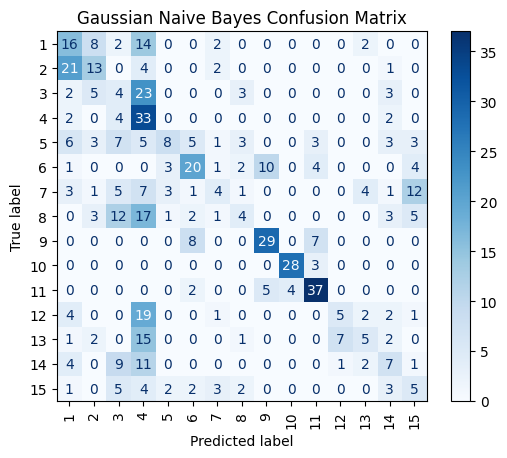

              precision    recall  f1-score   support

           1       0.26      0.36      0.30        44
           2       0.37      0.32      0.34        41
           3       0.08      0.10      0.09        40
           4       0.22      0.80      0.34        41
           5       0.47      0.17      0.25        47
           6       0.50      0.44      0.47        45
           7       0.27      0.10      0.14        42
           8       0.25      0.08      0.12        48
           9       0.66      0.66      0.66        44
          10       0.88      0.90      0.89        31
          11       0.69      0.77      0.73        48
          12       0.38      0.15      0.21        34
          13       0.33      0.15      0.21        33
          14       0.26      0.20      0.23        35
          15       0.16      0.19      0.17        27

    accuracy                           0.36       600
   macro avg       0.39      0.36      0.34       600
weighted avg       0.39   

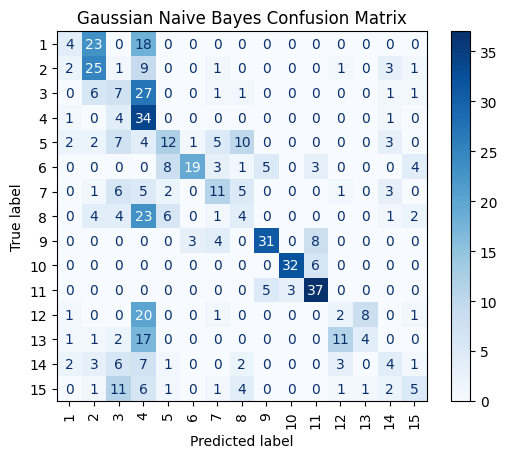

              precision    recall  f1-score   support

           1       0.31      0.09      0.14        45
           2       0.38      0.58      0.46        43
           3       0.15      0.16      0.15        44
           4       0.20      0.85      0.32        40
           5       0.40      0.26      0.32        46
           6       0.83      0.44      0.58        43
           7       0.39      0.32      0.35        34
           8       0.15      0.09      0.11        45
           9       0.76      0.67      0.71        46
          10       0.91      0.84      0.88        38
          11       0.69      0.82      0.75        45
          12       0.11      0.06      0.08        33
          13       0.31      0.11      0.16        36
          14       0.22      0.14      0.17        29
          15       0.33      0.15      0.21        33

    accuracy                           0.39       600
   macro avg       0.41      0.37      0.36       600
weighted avg       0.42   

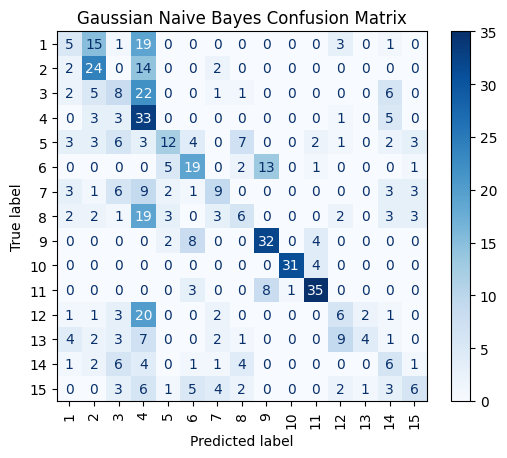

              precision    recall  f1-score   support

           1       0.22      0.11      0.15        44
           2       0.41      0.57      0.48        42
           3       0.20      0.18      0.19        45
           4       0.21      0.73      0.33        45
           5       0.48      0.26      0.34        46
           6       0.46      0.46      0.46        41
           7       0.38      0.24      0.30        37
           8       0.26      0.14      0.18        44
           9       0.60      0.70      0.65        46
          10       0.97      0.89      0.93        35
          11       0.76      0.74      0.75        47
          12       0.25      0.17      0.20        36
          13       0.57      0.12      0.20        33
          14       0.19      0.23      0.21        26
          15       0.35      0.18      0.24        33

    accuracy                           0.39       600
   macro avg       0.42      0.38      0.37       600
weighted avg       0.42   

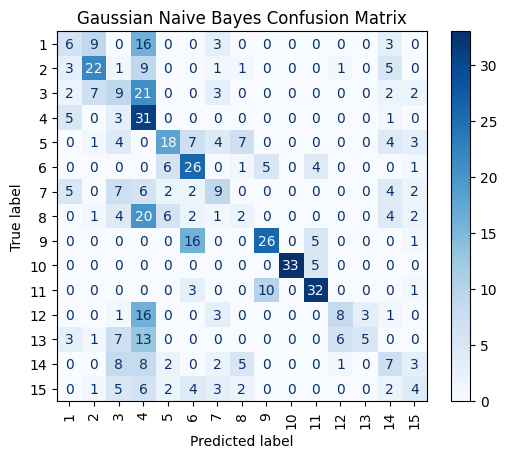

              precision    recall  f1-score   support

           1       0.25      0.16      0.20        37
           2       0.52      0.51      0.52        43
           3       0.18      0.20      0.19        46
           4       0.21      0.78      0.33        40
           5       0.50      0.38      0.43        48
           6       0.43      0.60      0.50        43
           7       0.31      0.24      0.27        37
           8       0.11      0.05      0.07        42
           9       0.63      0.54      0.58        48
          10       1.00      0.87      0.93        38
          11       0.70      0.70      0.70        46
          12       0.50      0.25      0.33        32
          13       0.62      0.14      0.23        35
          14       0.21      0.19      0.20        36
          15       0.21      0.14      0.17        29

    accuracy                           0.40       600
   macro avg       0.43      0.38      0.38       600
weighted avg       0.43   

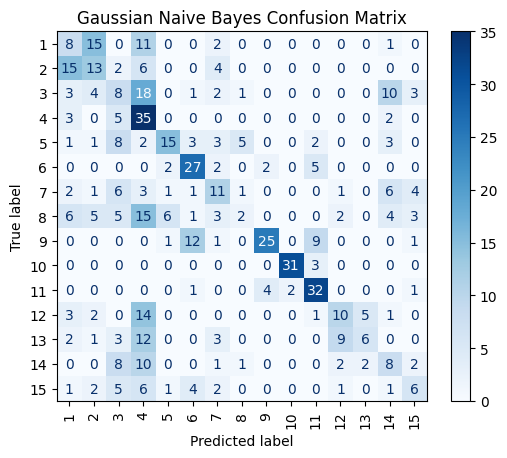

              precision    recall  f1-score   support

           1       0.18      0.22      0.20        37
           2       0.30      0.33      0.31        40
           3       0.16      0.16      0.16        50
           4       0.27      0.78      0.40        45
           5       0.58      0.35      0.43        43
           6       0.54      0.71      0.61        38
           7       0.32      0.30      0.31        37
           8       0.20      0.04      0.06        52
           9       0.81      0.51      0.62        49
          10       0.94      0.91      0.93        34
          11       0.62      0.80      0.70        40
          12       0.40      0.28      0.33        36
          13       0.46      0.17      0.24        36
          14       0.22      0.24      0.23        34
          15       0.30      0.21      0.24        29

    accuracy                           0.40       600
   macro avg       0.42      0.40      0.39       600
weighted avg       0.42   

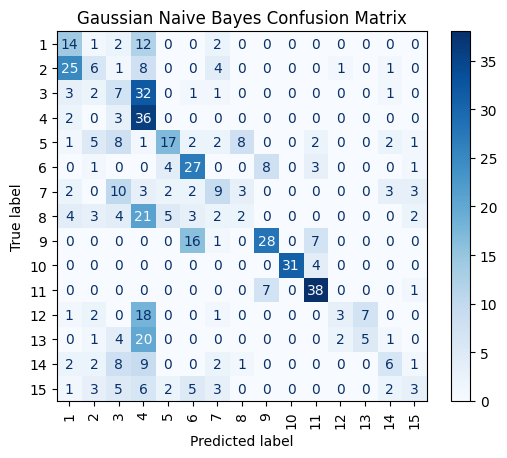

              precision    recall  f1-score   support

           1       0.25      0.45      0.33        31
           2       0.23      0.13      0.17        46
           3       0.13      0.15      0.14        47
           4       0.22      0.88      0.35        41
           5       0.57      0.35      0.43        49
           6       0.48      0.61      0.54        44
           7       0.33      0.24      0.28        37
           8       0.14      0.04      0.07        46
           9       0.65      0.54      0.59        52
          10       1.00      0.89      0.94        35
          11       0.70      0.83      0.76        46
          12       0.50      0.09      0.16        32
          13       0.42      0.15      0.22        33
          14       0.38      0.19      0.26        31
          15       0.25      0.10      0.14        30

    accuracy                           0.39       600
   macro avg       0.42      0.38      0.36       600
weighted avg       0.42   

feature_set                 model        cv_type  cv_accuracy  \
0   Feature_W100_Olap0  Gaussian Naive Bayes  Stratified-5F     0.349286   
1  Feature_W100_Olap50  Gaussian Naive Bayes  Stratified-5F     0.327143   
2   Feature_W200_Olap0  Gaussian Naive Bayes  Stratified-5F     0.348571   
3  Feature_W200_Olap50  Gaussian Naive Bayes  Stratified-5F     0.368571   
4   Feature_W300_Olap0  Gaussian Naive Bayes  Stratified-5F     0.367143   
5  Feature_W300_Olap50  Gaussian Naive Bayes  Stratified-5F     0.380000   
6   Feature_W400_Olap0  Gaussian Naive Bayes  Stratified-5F     0.377143   
7  Feature_W400_Olap50  Gaussian Naive Bayes  Stratified-5F     0.417857   
8   Feature_W500_Olap0  Gaussian Naive Bayes  Stratified-5F     0.401429   
9  Feature_W500_Olap50  Gaussian Naive Bayes  Stratified-5F     0.415714   

      cv_f1  cv_recall  cv_precision  
0  0.328256   0.346163      0.363526  
1  0.298592   0.315328      0.332683  
2  0.321690   0.338945      0.366245  
3  0.341449   0.359237      0.379895  
4  0.352252   0.364243      0.387477  
5  0.352512   0.367879      0.393987  
6  0.355876   0.364823      0.408062  
7  0.389091   0.403351      0.427063  
8  0.395326   0.404386      0.437067  
9  0.395318   0.406416      0.444209

### Hyperparameter Tuning & Test Metrics ###


feature_set                 model       tuning_method  \
0   Feature_W100_Olap0  Gaussian Naive Bayes  RandomizedSearchCV   
1  Feature_W100_Olap50  Gaussian Naive Bayes  RandomizedSearchCV   
2   Feature_W200_Olap0  Gaussian Naive Bayes  RandomizedSearchCV   
3  Feature_W200_Olap50  Gaussian Naive Bayes  RandomizedSearchCV   
4   Feature_W300_Olap0  Gaussian Naive Bayes  RandomizedSearchCV   
5  Feature_W300_Olap50  Gaussian Naive Bayes  RandomizedSearchCV   
6   Feature_W400_Olap0  Gaussian Naive Bayes  RandomizedSearchCV   
7  Feature_W400_Olap50  Gaussian Naive Bayes  RandomizedSearchCV   
8   Feature_W500_Olap0  Gaussian Naive Bayes  RandomizedSearchCV   
9  Feature_W500_Olap50  Gaussian Naive Bayes  RandomizedSearchCV   

                     best_params  test_accuracy   test_f1  test_precision  \
0  {'clf__var_smoothing': 1e-09}       0.345000  0.317054        0.345385   
1  {'clf__var_smoothing': 1e-09}       0.321667  0.299226        0.331250   
2  {'clf__var_smoothing': 1e-09}       0.335000  0.311641        0.336202   
3  {'clf__var_smoothing': 1e-09}       0.391667  0.370404        0.433617   
4  {'clf__var_smoothing': 1e-09}       0.363333  0.343898        0.385279   
5  {'clf__var_smoothing': 1e-09}       0.385000  0.359046        0.408232   
6  {'clf__var_smoothing': 1e-09}       0.393333  0.373102        0.421555   
7  {'clf__var_smoothing': 1e-09}       0.396667  0.376997        0.426803   
8  {'clf__var_smoothing': 1e-09}       0.395000  0.385173        0.419191   
9  {'clf__var_smoothing': 1e-09}       0.386667  0.357796        0.417222   

   test_recall  
0     0.339500  
1     0.312249  
2     0.322995  
3     0.387149  
4     0.359715  
5     0.372928  
6     0.381772  
7     0.383062  
8     0.398848  
9     0.376360

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB

# 1) Pipeline
gnb_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf',   GaussianNB())
])

# 2) Hyperparameter space
gnb_params = {
    'clf__var_smoothing': [1e-9, 1e-8, 1e-7]
}

# 3) Run evaluation (n_iter=3 covers all combos)
gnb_df = evaluate_model(
    model_name='Gaussian Naive Bayes',
    pipeline=gnb_pipe,
    param_dist=gnb_params,
    n_iter=3
)

# 4) Split into tuning & CV tables
tune_gnb, cv_gnb = summarize(gnb_df)


## SVM Evaluation



>> SVM on Feature_W100_Olap0.csv <<


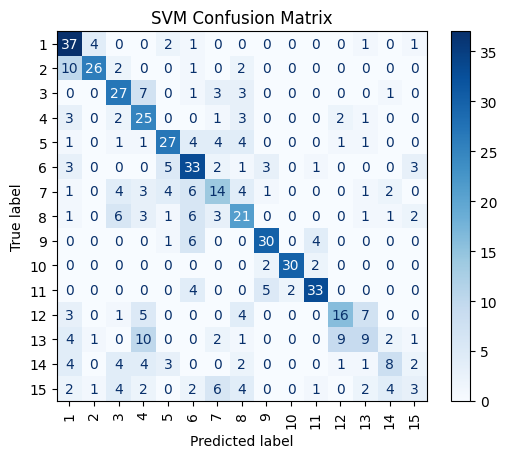

              precision    recall  f1-score   support

           1       0.54      0.80      0.64        46
           2       0.81      0.63      0.71        41
           3       0.53      0.64      0.58        42
           4       0.42      0.68      0.52        37
           5       0.63      0.61      0.62        44
           6       0.52      0.65      0.57        51
           7       0.40      0.35      0.37        40
           8       0.43      0.47      0.45        45
           9       0.73      0.73      0.73        41
          10       0.94      0.88      0.91        34
          11       0.80      0.75      0.78        44
          12       0.55      0.44      0.49        36
          13       0.38      0.23      0.29        39
          14       0.44      0.28      0.34        29
          15       0.25      0.10      0.14        31

    accuracy                           0.56       600
   macro avg       0.56      0.55      0.54       600
weighted avg       0.56   

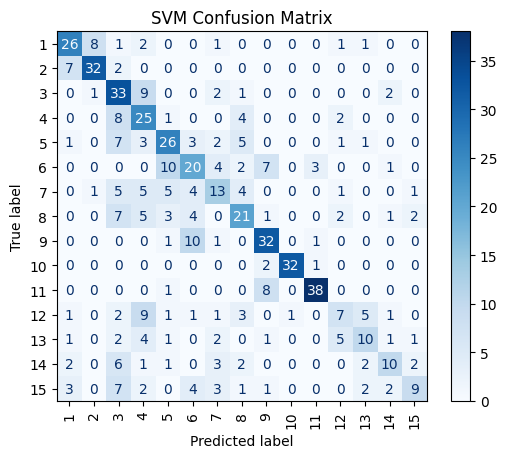

              precision    recall  f1-score   support

           1       0.63      0.65      0.64        40
           2       0.76      0.78      0.77        41
           3       0.41      0.69      0.52        48
           4       0.38      0.62      0.48        40
           5       0.52      0.53      0.53        49
           6       0.43      0.43      0.43        47
           7       0.41      0.33      0.37        39
           8       0.49      0.46      0.47        46
           9       0.62      0.71      0.66        45
          10       0.97      0.91      0.94        35
          11       0.88      0.81      0.84        47
          12       0.37      0.22      0.27        32
          13       0.48      0.36      0.41        28
          14       0.56      0.34      0.43        29
          15       0.60      0.26      0.37        34

    accuracy                           0.56       600
   macro avg       0.57      0.54      0.54       600
weighted avg       0.57   

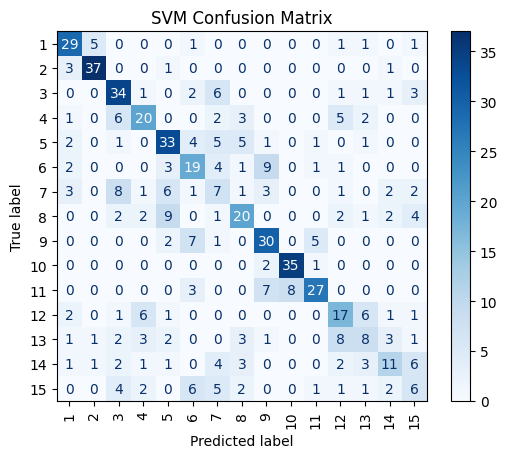

              precision    recall  f1-score   support

           1       0.66      0.76      0.71        38
           2       0.84      0.88      0.86        42
           3       0.57      0.69      0.62        49
           4       0.56      0.51      0.53        39
           5       0.57      0.62      0.59        53
           6       0.44      0.47      0.46        40
           7       0.20      0.20      0.20        35
           8       0.53      0.47      0.49        43
           9       0.57      0.67      0.61        45
          10       0.81      0.92      0.86        38
          11       0.75      0.60      0.67        45
          12       0.44      0.49      0.46        35
          13       0.33      0.24      0.28        33
          14       0.48      0.31      0.38        35
          15       0.25      0.20      0.22        30

    accuracy                           0.56       600
   macro avg       0.53      0.54      0.53       600
weighted avg       0.55   

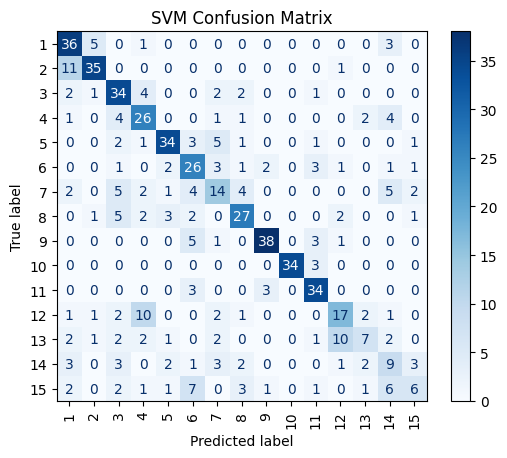

              precision    recall  f1-score   support

           1       0.60      0.80      0.69        45
           2       0.80      0.74      0.77        47
           3       0.57      0.74      0.64        46
           4       0.53      0.67      0.59        39
           5       0.77      0.71      0.74        48
           6       0.51      0.63      0.57        41
           7       0.42      0.36      0.39        39
           8       0.64      0.63      0.64        43
           9       0.86      0.79      0.83        48
          10       1.00      0.92      0.96        37
          11       0.72      0.85      0.78        40
          12       0.52      0.46      0.49        37
          13       0.50      0.23      0.32        30
          14       0.29      0.31      0.30        29
          15       0.43      0.19      0.27        31

    accuracy                           0.63       600
   macro avg       0.61      0.60      0.60       600
weighted avg       0.63   

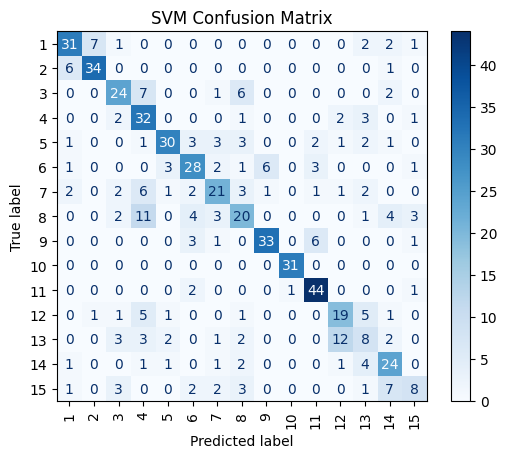

              precision    recall  f1-score   support

           1       0.72      0.70      0.71        44
           2       0.81      0.83      0.82        41
           3       0.63      0.60      0.62        40
           4       0.48      0.78      0.60        41
           5       0.79      0.64      0.71        47
           6       0.64      0.62      0.63        45
           7       0.60      0.50      0.55        42
           8       0.48      0.42      0.44        48
           9       0.82      0.75      0.79        44
          10       0.97      1.00      0.98        31
          11       0.79      0.92      0.85        48
          12       0.53      0.56      0.54        34
          13       0.29      0.24      0.26        33
          14       0.55      0.69      0.61        35
          15       0.50      0.30      0.37        27

    accuracy                           0.65       600
   macro avg       0.64      0.64      0.63       600
weighted avg       0.65   

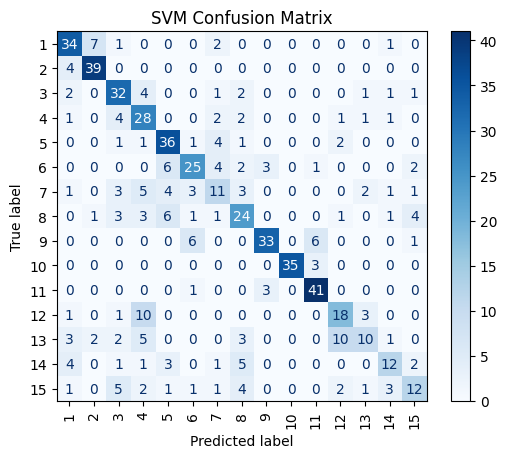

              precision    recall  f1-score   support

           1       0.67      0.76      0.71        45
           2       0.80      0.91      0.85        43
           3       0.60      0.73      0.66        44
           4       0.47      0.70      0.57        40
           5       0.64      0.78      0.71        46
           6       0.66      0.58      0.62        43
           7       0.41      0.32      0.36        34
           8       0.52      0.53      0.53        45
           9       0.85      0.72      0.78        46
          10       1.00      0.92      0.96        38
          11       0.80      0.91      0.85        45
          12       0.53      0.55      0.54        33
          13       0.56      0.28      0.37        36
          14       0.57      0.41      0.48        29
          15       0.52      0.36      0.43        33

    accuracy                           0.65       600
   macro avg       0.64      0.63      0.63       600
weighted avg       0.65   

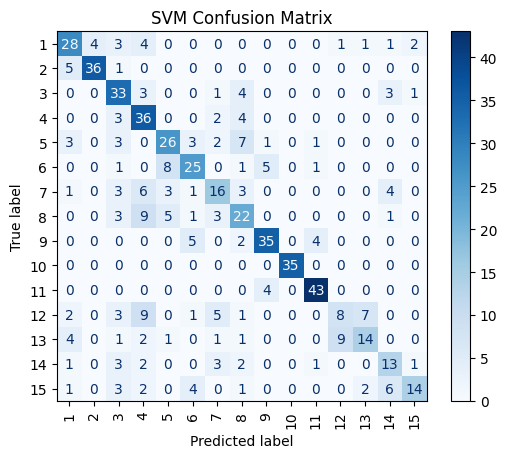

              precision    recall  f1-score   support

           1       0.62      0.64      0.63        44
           2       0.90      0.86      0.88        42
           3       0.55      0.73      0.63        45
           4       0.49      0.80      0.61        45
           5       0.60      0.57      0.58        46
           6       0.62      0.61      0.62        41
           7       0.48      0.43      0.46        37
           8       0.46      0.50      0.48        44
           9       0.78      0.76      0.77        46
          10       1.00      1.00      1.00        35
          11       0.86      0.91      0.89        47
          12       0.44      0.22      0.30        36
          13       0.58      0.42      0.49        33
          14       0.46      0.50      0.48        26
          15       0.78      0.42      0.55        33

    accuracy                           0.64       600
   macro avg       0.64      0.63      0.62       600
weighted avg       0.65   

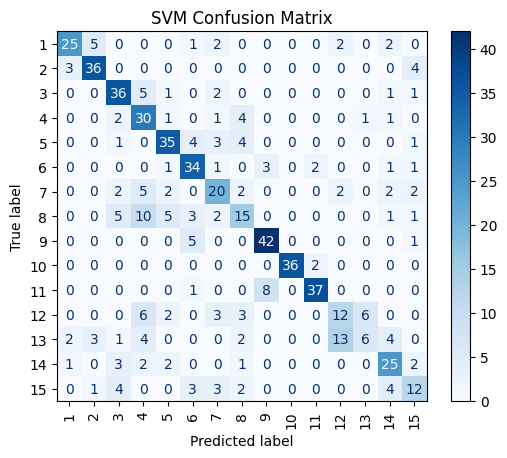

              precision    recall  f1-score   support

           1       0.81      0.68      0.74        37
           2       0.80      0.84      0.82        43
           3       0.67      0.78      0.72        46
           4       0.48      0.75      0.59        40
           5       0.71      0.73      0.72        48
           6       0.67      0.79      0.72        43
           7       0.54      0.54      0.54        37
           8       0.45      0.36      0.40        42
           9       0.79      0.88      0.83        48
          10       1.00      0.95      0.97        38
          11       0.90      0.80      0.85        46
          12       0.41      0.38      0.39        32
          13       0.46      0.17      0.25        35
          14       0.61      0.69      0.65        36
          15       0.48      0.41      0.44        29

    accuracy                           0.67       600
   macro avg       0.65      0.65      0.64       600
weighted avg       0.67   

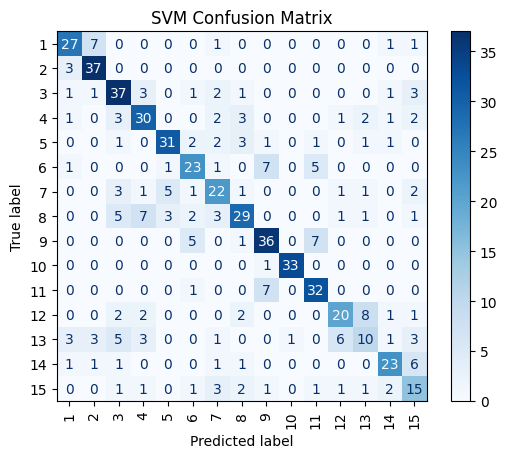

              precision    recall  f1-score   support

           1       0.73      0.73      0.73        37
           2       0.76      0.93      0.83        40
           3       0.64      0.74      0.69        50
           4       0.64      0.67      0.65        45
           5       0.78      0.72      0.75        43
           6       0.64      0.61      0.62        38
           7       0.58      0.59      0.59        37
           8       0.67      0.56      0.61        52
           9       0.68      0.73      0.71        49
          10       0.97      0.97      0.97        34
          11       0.70      0.80      0.74        40
          12       0.67      0.56      0.61        36
          13       0.42      0.28      0.33        36
          14       0.74      0.68      0.71        34
          15       0.44      0.52      0.48        29

    accuracy                           0.68       600
   macro avg       0.67      0.67      0.67       600
weighted avg       0.67   

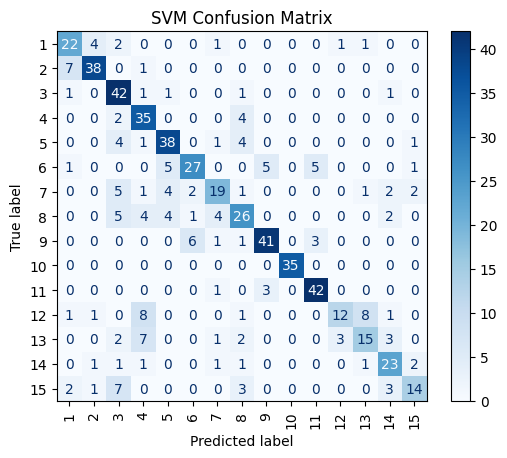

              precision    recall  f1-score   support

           1       0.65      0.71      0.68        31
           2       0.84      0.83      0.84        46
           3       0.60      0.89      0.72        47
           4       0.59      0.85      0.70        41
           5       0.73      0.78      0.75        49
           6       0.75      0.61      0.68        44
           7       0.66      0.51      0.58        37
           8       0.59      0.57      0.58        46
           9       0.84      0.79      0.81        52
          10       1.00      1.00      1.00        35
          11       0.84      0.91      0.88        46
          12       0.75      0.38      0.50        32
          13       0.58      0.45      0.51        33
          14       0.66      0.74      0.70        31
          15       0.70      0.47      0.56        30

    accuracy                           0.71       600
   macro avg       0.72      0.70      0.70       600
weighted avg       0.72   

feature_set model        cv_type  cv_accuracy     cv_f1  cv_recall  \
0   Feature_W100_Olap0   SVM  Stratified-5F     0.538571  0.523284   0.530434   
1  Feature_W100_Olap50   SVM  Stratified-5F     0.555714  0.531179   0.537265   
2   Feature_W200_Olap0   SVM  Stratified-5F     0.577857  0.552856   0.559091   
3  Feature_W200_Olap50   SVM  Stratified-5F     0.587857  0.559944   0.567301   
4   Feature_W300_Olap0   SVM  Stratified-5F     0.613571  0.597857   0.599930   
5  Feature_W300_Olap50   SVM  Stratified-5F     0.641429  0.612996   0.621040   
6   Feature_W400_Olap0   SVM  Stratified-5F     0.632857  0.608702   0.612869   
7  Feature_W400_Olap50   SVM  Stratified-5F     0.650000  0.623204   0.630232   
8   Feature_W500_Olap0   SVM  Stratified-5F     0.659286  0.644602   0.648268   
9  Feature_W500_Olap50   SVM  Stratified-5F     0.660714  0.635121   0.639286   

   cv_precision  
0      0.532985  
1      0.548157  
2      0.565673  
3      0.568713  
4      0.619579  
5      0.625749  
6      0.627545  
7      0.641407  
8      0.655459  
9      0.646871

### Hyperparameter Tuning & Test Metrics ###


feature_set model       tuning_method  \
0   Feature_W100_Olap0   SVM  RandomizedSearchCV   
1  Feature_W100_Olap50   SVM  RandomizedSearchCV   
2   Feature_W200_Olap0   SVM  RandomizedSearchCV   
3  Feature_W200_Olap50   SVM  RandomizedSearchCV   
4   Feature_W300_Olap0   SVM  RandomizedSearchCV   
5  Feature_W300_Olap50   SVM  RandomizedSearchCV   
6   Feature_W400_Olap0   SVM  RandomizedSearchCV   
7  Feature_W400_Olap50   SVM  RandomizedSearchCV   
8   Feature_W500_Olap0   SVM  RandomizedSearchCV   
9  Feature_W500_Olap50   SVM  RandomizedSearchCV   

                                         best_params  test_accuracy   test_f1  \
0  {'clf__kernel': 'rbf', 'clf__gamma': 'scale', ...       0.565000  0.542794   
1  {'clf__kernel': 'rbf', 'clf__gamma': 'scale', ...       0.556667  0.541287   
2  {'clf__kernel': 'poly', 'clf__gamma': 0.1, 'cl...       0.555000  0.530402   
3  {'clf__kernel': 'rbf', 'clf__gamma': 'scale', ...       0.628333  0.596793   
4  {'clf__kernel': 'rbf', 'clf__gamma': 'scale', ...       0.645000  0.631418   
5  {'clf__kernel': 'rbf', 'clf__gamma': 'scale', ...       0.650000  0.626580   
6  {'clf__kernel': 'rbf', 'clf__gamma': 'scale', ...       0.640000  0.623788   
7  {'clf__kernel': 'rbf', 'clf__gamma': 'scale', ...       0.668333  0.642652   
8  {'clf__kernel': 'poly', 'clf__gamma': 0.1, 'cl...       0.675000  0.667219   
9  {'clf__kernel': 'rbf', 'clf__gamma': 'scale', ...       0.715000  0.697558   

   test_precision  test_recall  
0        0.557478     0.549753  
1        0.567436     0.540555  
2        0.532456     0.536247  
3        0.610897     0.602474  
4        0.639155     0.636094  
5        0.639936     0.630726  
6        0.643055     0.625381  
7        0.652867     0.649628  
8        0.669350     0.671480  
9        0.718158     0.699371

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# 1) Pipeline
svm_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf',   SVC(probability=True, random_state=42))
])

# 2) Hyperparameter space
svm_params = {
    'clf__C':      [0.1, 1, 10, 100],
    'clf__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'clf__gamma':  ['scale', 'auto', 0.1, 0.01, 0.001]
}

# 3) Run evaluation (n_iter=20)
svm_df = evaluate_model(
    model_name='SVM',
    pipeline=svm_pipe,
    param_dist=svm_params,
    n_iter=20
)

# 4) Split into tuning & CV tables
tune_svm, cv_svm = summarize(svm_df)


## KNN Evaluation



>> KNN on Feature_W100_Olap0.csv <<


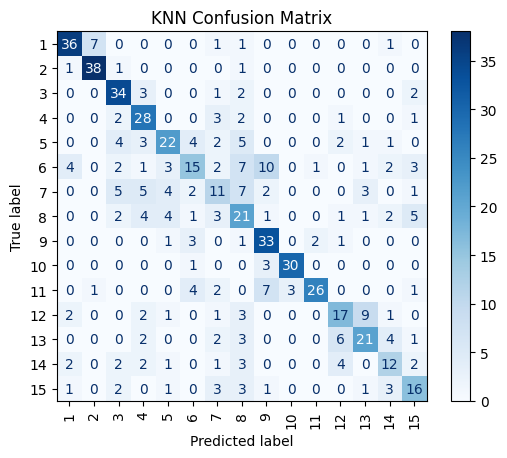

              precision    recall  f1-score   support

           1       0.78      0.78      0.78        46
           2       0.83      0.93      0.87        41
           3       0.63      0.81      0.71        42
           4       0.56      0.76      0.64        37
           5       0.59      0.50      0.54        44
           6       0.50      0.29      0.37        51
           7       0.34      0.28      0.31        40
           8       0.36      0.47      0.40        45
           9       0.58      0.80      0.67        41
          10       0.91      0.88      0.90        34
          11       0.90      0.59      0.71        44
          12       0.53      0.47      0.50        36
          13       0.57      0.54      0.55        39
          14       0.46      0.41      0.44        29
          15       0.50      0.52      0.51        31

    accuracy                           0.60       600
   macro avg       0.60      0.60      0.59       600
weighted avg       0.60   

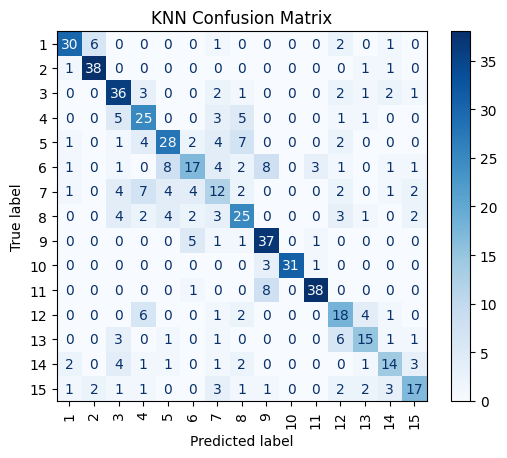

              precision    recall  f1-score   support

           1       0.81      0.75      0.78        40
           2       0.83      0.93      0.87        41
           3       0.61      0.75      0.67        48
           4       0.51      0.62      0.56        40
           5       0.61      0.57      0.59        49
           6       0.55      0.36      0.44        47
           7       0.33      0.31      0.32        39
           8       0.52      0.54      0.53        46
           9       0.65      0.82      0.73        45
          10       1.00      0.89      0.94        35
          11       0.88      0.81      0.84        47
          12       0.46      0.56      0.51        32
          13       0.58      0.54      0.56        28
          14       0.56      0.48      0.52        29
          15       0.63      0.50      0.56        34

    accuracy                           0.64       600
   macro avg       0.64      0.63      0.63       600
weighted avg       0.64   

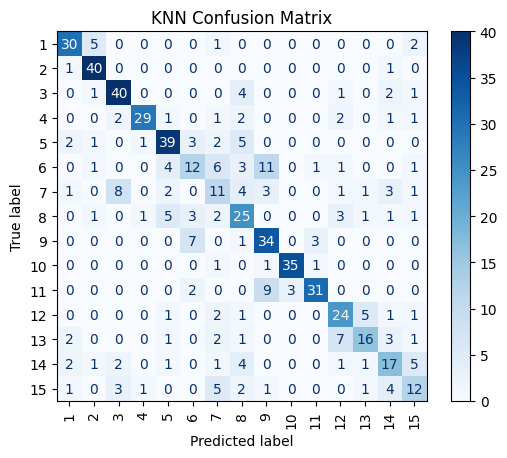

              precision    recall  f1-score   support

           1       0.77      0.79      0.78        38
           2       0.80      0.95      0.87        42
           3       0.73      0.82      0.77        49
           4       0.91      0.74      0.82        39
           5       0.72      0.74      0.73        53
           6       0.44      0.30      0.36        40
           7       0.32      0.31      0.32        35
           8       0.48      0.58      0.53        43
           9       0.58      0.76      0.65        45
          10       0.92      0.92      0.92        38
          11       0.86      0.69      0.77        45
          12       0.60      0.69      0.64        35
          13       0.64      0.48      0.55        33
          14       0.52      0.49      0.50        35
          15       0.46      0.40      0.43        30

    accuracy                           0.66       600
   macro avg       0.65      0.64      0.64       600
weighted avg       0.66   

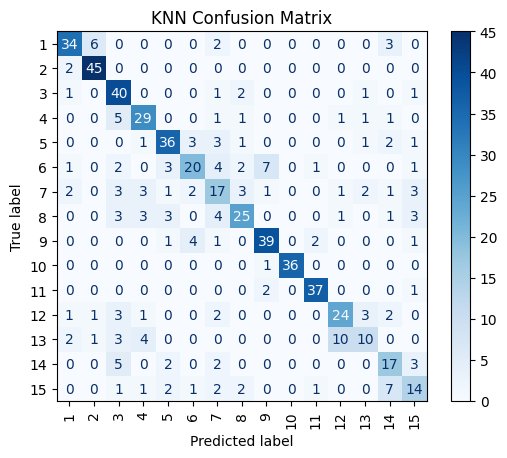

              precision    recall  f1-score   support

           1       0.79      0.76      0.77        45
           2       0.85      0.96      0.90        47
           3       0.62      0.87      0.72        46
           4       0.69      0.74      0.72        39
           5       0.75      0.75      0.75        48
           6       0.67      0.49      0.56        41
           7       0.44      0.44      0.44        39
           8       0.69      0.58      0.63        43
           9       0.78      0.81      0.80        48
          10       1.00      0.97      0.99        37
          11       0.90      0.93      0.91        40
          12       0.65      0.65      0.65        37
          13       0.56      0.33      0.42        30
          14       0.50      0.59      0.54        29
          15       0.50      0.45      0.47        31

    accuracy                           0.70       600
   macro avg       0.69      0.69      0.68       600
weighted avg       0.70   

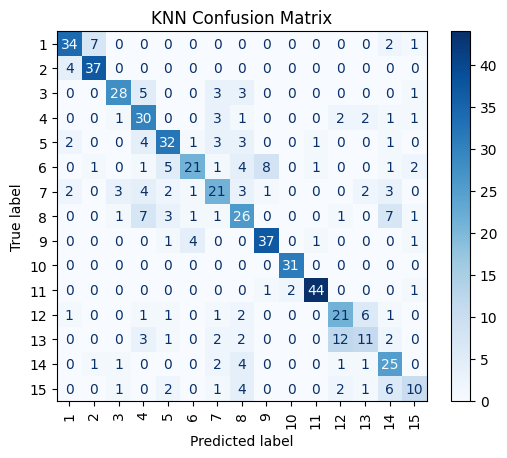

              precision    recall  f1-score   support

           1       0.79      0.77      0.78        44
           2       0.80      0.90      0.85        41
           3       0.80      0.70      0.75        40
           4       0.55      0.73      0.62        41
           5       0.68      0.68      0.68        47
           6       0.75      0.47      0.58        45
           7       0.55      0.50      0.53        42
           8       0.50      0.54      0.52        48
           9       0.79      0.84      0.81        44
          10       0.94      1.00      0.97        31
          11       0.94      0.92      0.93        48
          12       0.54      0.62      0.58        34
          13       0.48      0.33      0.39        33
          14       0.51      0.71      0.60        35
          15       0.56      0.37      0.44        27

    accuracy                           0.68       600
   macro avg       0.68      0.67      0.67       600
weighted avg       0.68   

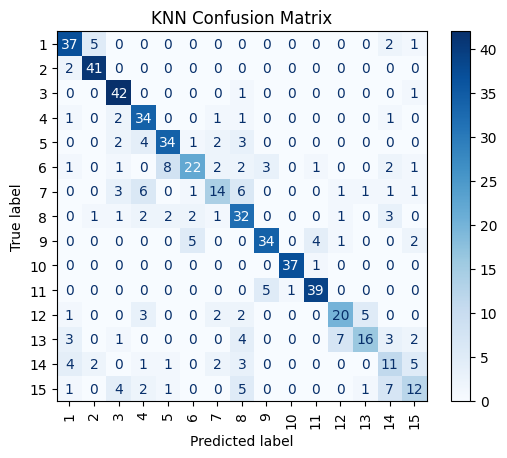

              precision    recall  f1-score   support

           1       0.74      0.82      0.78        45
           2       0.84      0.95      0.89        43
           3       0.75      0.95      0.84        44
           4       0.65      0.85      0.74        40
           5       0.74      0.74      0.74        46
           6       0.71      0.51      0.59        43
           7       0.58      0.41      0.48        34
           8       0.54      0.71      0.62        45
           9       0.81      0.74      0.77        46
          10       0.97      0.97      0.97        38
          11       0.87      0.87      0.87        45
          12       0.67      0.61      0.63        33
          13       0.70      0.44      0.54        36
          14       0.37      0.38      0.37        29
          15       0.48      0.36      0.41        33

    accuracy                           0.71       600
   macro avg       0.69      0.69      0.68       600
weighted avg       0.71   

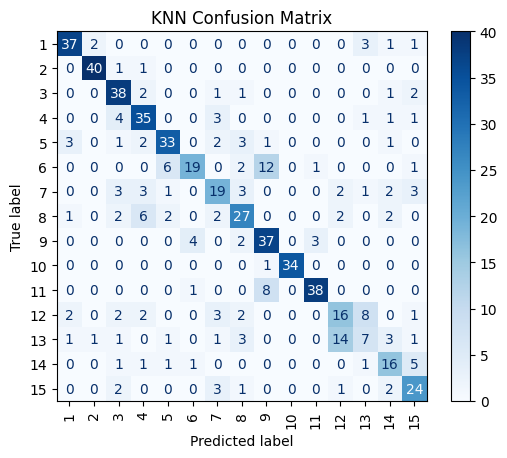

              precision    recall  f1-score   support

           1       0.84      0.84      0.84        44
           2       0.93      0.95      0.94        42
           3       0.69      0.84      0.76        45
           4       0.67      0.78      0.72        45
           5       0.75      0.72      0.73        46
           6       0.76      0.46      0.58        41
           7       0.56      0.51      0.54        37
           8       0.61      0.61      0.61        44
           9       0.63      0.80      0.70        46
          10       1.00      0.97      0.99        35
          11       0.90      0.81      0.85        47
          12       0.46      0.44      0.45        36
          13       0.33      0.21      0.26        33
          14       0.55      0.62      0.58        26
          15       0.62      0.73      0.67        33

    accuracy                           0.70       600
   macro avg       0.69      0.69      0.68       600
weighted avg       0.70   

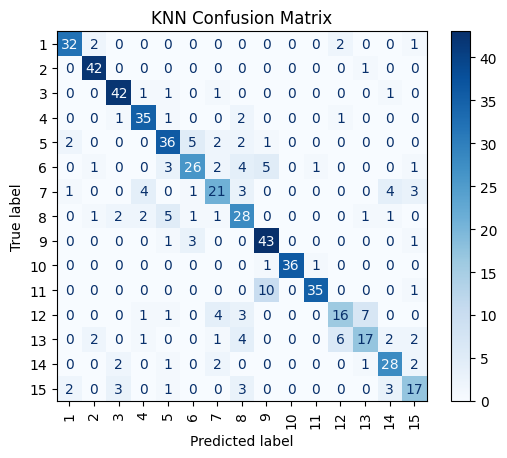

              precision    recall  f1-score   support

           1       0.86      0.86      0.86        37
           2       0.88      0.98      0.92        43
           3       0.84      0.91      0.88        46
           4       0.80      0.88      0.83        40
           5       0.72      0.75      0.73        48
           6       0.72      0.60      0.66        43
           7       0.62      0.57      0.59        37
           8       0.57      0.67      0.62        42
           9       0.72      0.90      0.80        48
          10       1.00      0.95      0.97        38
          11       0.95      0.76      0.84        46
          12       0.64      0.50      0.56        32
          13       0.63      0.49      0.55        35
          14       0.72      0.78      0.75        36
          15       0.61      0.59      0.60        29

    accuracy                           0.76       600
   macro avg       0.75      0.74      0.74       600
weighted avg       0.76   

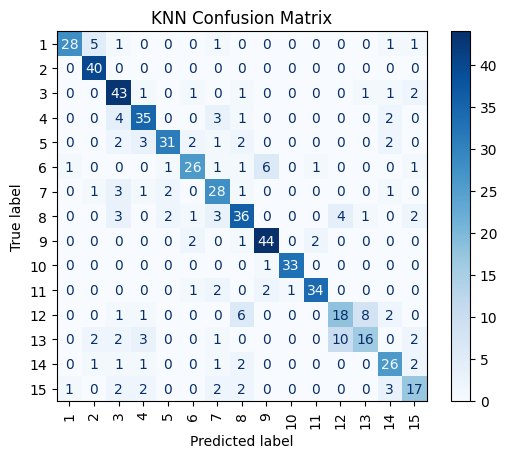

              precision    recall  f1-score   support

           1       0.93      0.76      0.84        37
           2       0.82      1.00      0.90        40
           3       0.69      0.86      0.77        50
           4       0.74      0.78      0.76        45
           5       0.86      0.72      0.78        43
           6       0.79      0.68      0.73        38
           7       0.65      0.76      0.70        37
           8       0.68      0.69      0.69        52
           9       0.83      0.90      0.86        49
          10       0.97      0.97      0.97        34
          11       0.92      0.85      0.88        40
          12       0.56      0.50      0.53        36
          13       0.62      0.44      0.52        36
          14       0.68      0.76      0.72        34
          15       0.63      0.59      0.61        29

    accuracy                           0.76       600
   macro avg       0.76      0.75      0.75       600
weighted avg       0.76   

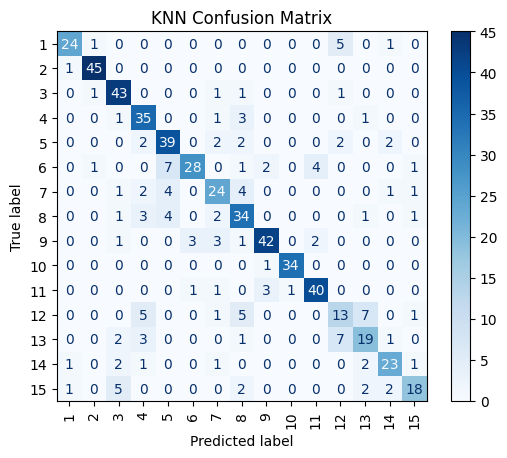

              precision    recall  f1-score   support

           1       0.89      0.77      0.83        31
           2       0.94      0.98      0.96        46
           3       0.77      0.91      0.83        47
           4       0.69      0.85      0.76        41
           5       0.72      0.80      0.76        49
           6       0.88      0.64      0.74        44
           7       0.67      0.65      0.66        37
           8       0.63      0.74      0.68        46
           9       0.88      0.81      0.84        52
          10       0.97      0.97      0.97        35
          11       0.87      0.87      0.87        46
          12       0.46      0.41      0.43        32
          13       0.59      0.58      0.58        33
          14       0.77      0.74      0.75        31
          15       0.78      0.60      0.68        30

    accuracy                           0.77       600
   macro avg       0.77      0.75      0.76       600
weighted avg       0.77   

feature_set model        cv_type  cv_accuracy     cv_f1  cv_recall  \
0   Feature_W100_Olap0   KNN  Stratified-5F     0.570714  0.566751   0.571649   
1  Feature_W100_Olap50   KNN  Stratified-5F     0.609286  0.597014   0.602090   
2   Feature_W200_Olap0   KNN  Stratified-5F     0.632857  0.612600   0.617006   
3  Feature_W200_Olap50   KNN  Stratified-5F     0.633571  0.614884   0.619511   
4   Feature_W300_Olap0   KNN  Stratified-5F     0.658571  0.651442   0.654544   
5  Feature_W300_Olap50   KNN  Stratified-5F     0.674286  0.652254   0.658182   
6   Feature_W400_Olap0   KNN  Stratified-5F     0.662143  0.641137   0.646516   
7  Feature_W400_Olap50   KNN  Stratified-5F     0.684286  0.668865   0.673212   
8   Feature_W500_Olap0   KNN  Stratified-5F     0.717857  0.706344   0.705631   
9  Feature_W500_Olap50   KNN  Stratified-5F     0.716429  0.699379   0.699960   

   cv_precision  
0      0.577348  
1      0.609381  
2      0.623194  
3      0.624615  
4      0.664664  
5      0.668627  
6      0.657240  
7      0.682263  
8      0.722520  
9      0.714143

### Hyperparameter Tuning & Test Metrics ###


feature_set model       tuning_method  \
0   Feature_W100_Olap0   KNN  RandomizedSearchCV   
1  Feature_W100_Olap50   KNN  RandomizedSearchCV   
2   Feature_W200_Olap0   KNN  RandomizedSearchCV   
3  Feature_W200_Olap50   KNN  RandomizedSearchCV   
4   Feature_W300_Olap0   KNN  RandomizedSearchCV   
5  Feature_W300_Olap50   KNN  RandomizedSearchCV   
6   Feature_W400_Olap0   KNN  RandomizedSearchCV   
7  Feature_W400_Olap50   KNN  RandomizedSearchCV   
8   Feature_W500_Olap0   KNN  RandomizedSearchCV   
9  Feature_W500_Olap50   KNN  RandomizedSearchCV   

                                         best_params  test_accuracy   test_f1  \
0  {'clf__weights': 'distance', 'clf__p': 1, 'clf...       0.600000  0.593961   
1  {'clf__weights': 'distance', 'clf__p': 1, 'clf...       0.635000  0.627506   
2  {'clf__weights': 'distance', 'clf__p': 1, 'clf...       0.658333  0.641859   
3  {'clf__weights': 'distance', 'clf__p': 1, 'clf...       0.705000  0.684471   
4  {'clf__weights': 'distance', 'clf__p': 1, 'clf...       0.680000  0.668079   
5  {'clf__weights': 'distance', 'clf__p': 1, 'clf...       0.708333  0.683886   
6  {'clf__weights': 'distance', 'clf__p': 1, 'clf...       0.700000  0.681622   
7  {'clf__weights': 'distance', 'clf__p': 1, 'clf...       0.756667  0.744115   
8  {'clf__weights': 'distance', 'clf__p': 1, 'clf...       0.758333  0.750513   
9  {'clf__weights': 'distance', 'clf__p': 1, 'clf...       0.768333  0.756320   

   test_precision  test_recall  
0        0.602503     0.602017  
1        0.635297     0.628903  
2        0.649923     0.643672  
3        0.691951     0.687435  
4        0.677951     0.672618  
5        0.694264     0.688455  
6        0.687137     0.687132  
7        0.750930     0.744821  
8        0.758581     0.750843  
9        0.766490     0.754246

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

# 1) Pipeline
knn_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf',   KNeighborsClassifier())
])

# 2) Hyperparameter space
knn_params = {
    'clf__n_neighbors': [3, 5, 7, 11],
    'clf__weights':     ['uniform', 'distance'],
    'clf__p':           [1, 2]
}

# 3) Run evaluation (n_iter=10)
knn_df = evaluate_model(
    model_name='KNN',
    pipeline=knn_pipe,
    param_dist=knn_params,
    n_iter=10
)

# 4) Split into tuning & CV tables
tune_knn, cv_knn = summarize(knn_df)


## AdaBoost Evaluation



>> AdaBoost on Feature_W100_Olap0.csv <<


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


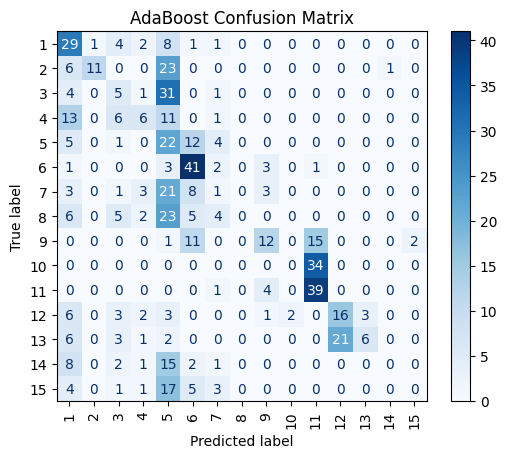

              precision    recall  f1-score   support

           1       0.32      0.63      0.42        46
           2       0.92      0.27      0.42        41
           3       0.16      0.12      0.14        42
           4       0.32      0.16      0.21        37
           5       0.12      0.50      0.20        44
           6       0.48      0.80      0.60        51
           7       0.05      0.03      0.03        40
           8       0.00      0.00      0.00        45
           9       0.52      0.29      0.38        41
          10       0.00      0.00      0.00        34
          11       0.44      0.89      0.59        44
          12       0.43      0.44      0.44        36
          13       0.67      0.15      0.25        39
          14       0.00      0.00      0.00        29
          15       0.00      0.00      0.00        31

    accuracy                           0.31       600
   macro avg       0.30      0.29      0.24       600
weighted avg       0.31   

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


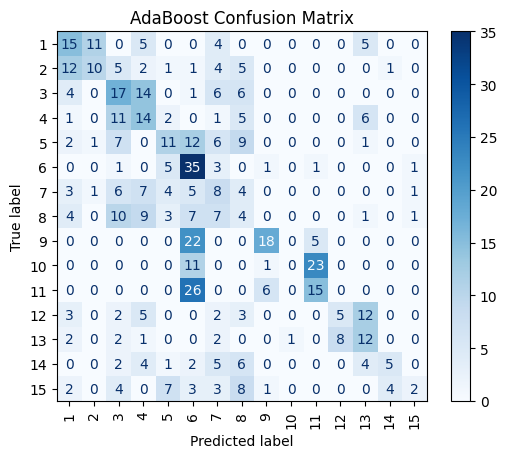

              precision    recall  f1-score   support

           1       0.31      0.38      0.34        40
           2       0.43      0.24      0.31        41
           3       0.25      0.35      0.30        48
           4       0.23      0.35      0.28        40
           5       0.32      0.22      0.27        49
           6       0.28      0.74      0.41        47
           7       0.16      0.21      0.18        39
           8       0.08      0.09      0.08        46
           9       0.67      0.40      0.50        45
          10       0.00      0.00      0.00        35
          11       0.34      0.32      0.33        47
          12       0.38      0.16      0.22        32
          13       0.29      0.43      0.35        28
          14       0.50      0.17      0.26        29
          15       0.40      0.06      0.10        34

    accuracy                           0.28       600
   macro avg       0.31      0.27      0.26       600
weighted avg       0.31   

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


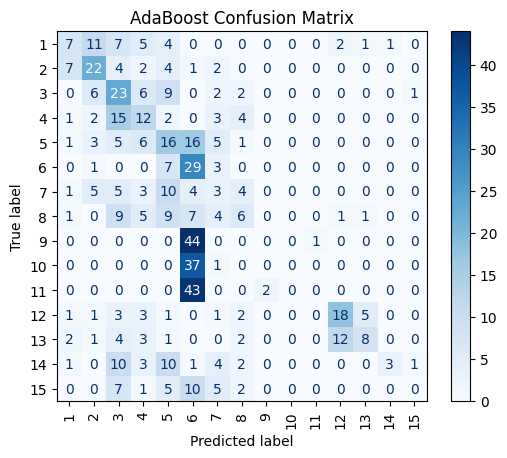

              precision    recall  f1-score   support

           1       0.32      0.18      0.23        38
           2       0.42      0.52      0.47        42
           3       0.25      0.47      0.33        49
           4       0.24      0.31      0.27        39
           5       0.21      0.30      0.24        53
           6       0.15      0.72      0.25        40
           7       0.09      0.09      0.09        35
           8       0.24      0.14      0.18        43
           9       0.00      0.00      0.00        45
          10       0.00      0.00      0.00        38
          11       0.00      0.00      0.00        45
          12       0.55      0.51      0.53        35
          13       0.53      0.24      0.33        33
          14       0.75      0.09      0.15        35
          15       0.00      0.00      0.00        30

    accuracy                           0.24       600
   macro avg       0.25      0.24      0.21       600
weighted avg       0.24   

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


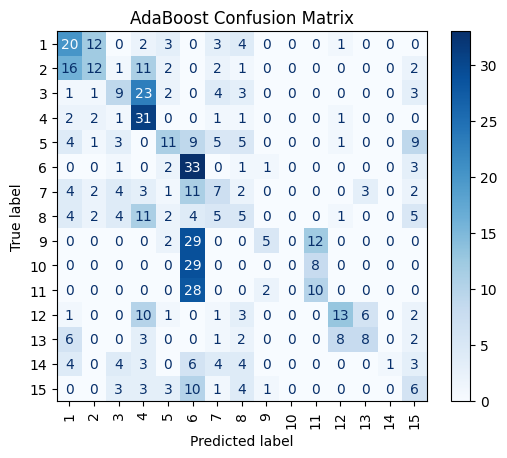

              precision    recall  f1-score   support

           1       0.32      0.44      0.37        45
           2       0.38      0.26      0.30        47
           3       0.30      0.20      0.24        46
           4       0.31      0.79      0.45        39
           5       0.38      0.23      0.29        48
           6       0.21      0.80      0.33        41
           7       0.21      0.18      0.19        39
           8       0.14      0.12      0.13        43
           9       0.56      0.10      0.18        48
          10       0.00      0.00      0.00        37
          11       0.33      0.25      0.29        40
          12       0.52      0.35      0.42        37
          13       0.47      0.27      0.34        30
          14       1.00      0.03      0.07        29
          15       0.16      0.19      0.18        31

    accuracy                           0.28       600
   macro avg       0.35      0.28      0.25       600
weighted avg       0.34   

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


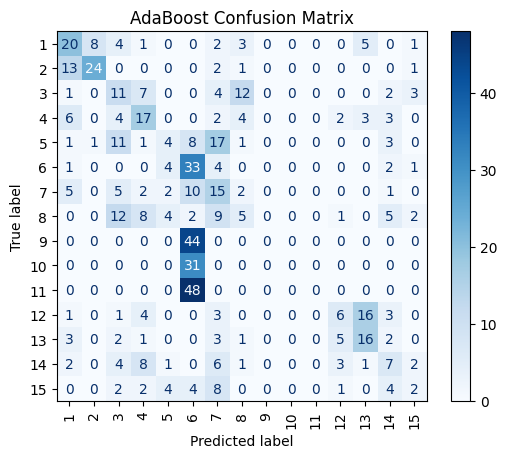

              precision    recall  f1-score   support

           1       0.38      0.45      0.41        44
           2       0.73      0.59      0.65        41
           3       0.20      0.28      0.23        40
           4       0.33      0.41      0.37        41
           5       0.21      0.09      0.12        47
           6       0.18      0.73      0.29        45
           7       0.20      0.36      0.26        42
           8       0.17      0.10      0.13        48
           9       0.00      0.00      0.00        44
          10       0.00      0.00      0.00        31
          11       0.00      0.00      0.00        48
          12       0.33      0.18      0.23        34
          13       0.39      0.48      0.43        33
          14       0.22      0.20      0.21        35
          15       0.17      0.07      0.10        27

    accuracy                           0.27       600
   macro avg       0.23      0.26      0.23       600
weighted avg       0.23   

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


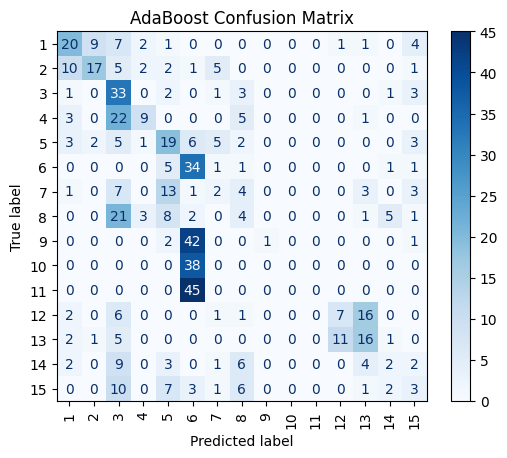

              precision    recall  f1-score   support

           1       0.45      0.44      0.45        45
           2       0.59      0.40      0.47        43
           3       0.25      0.75      0.38        44
           4       0.53      0.23      0.32        40
           5       0.31      0.41      0.35        46
           6       0.20      0.79      0.32        43
           7       0.12      0.06      0.08        34
           8       0.12      0.09      0.10        45
           9       1.00      0.02      0.04        46
          10       0.00      0.00      0.00        38
          11       0.00      0.00      0.00        45
          12       0.37      0.21      0.27        33
          13       0.37      0.44      0.41        36
          14       0.17      0.07      0.10        29
          15       0.14      0.09      0.11        33

    accuracy                           0.28       600
   macro avg       0.31      0.27      0.23       600
weighted avg       0.32   

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


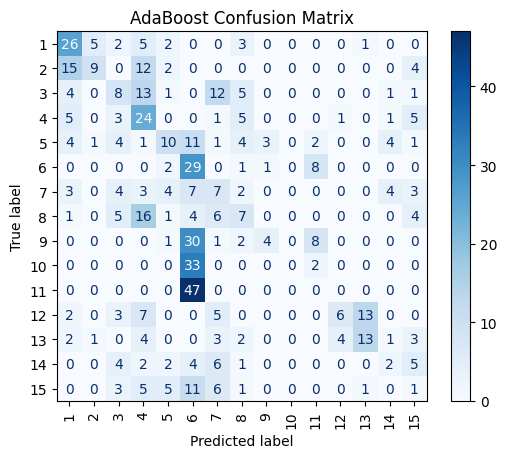

              precision    recall  f1-score   support

           1       0.42      0.59      0.49        44
           2       0.56      0.21      0.31        42
           3       0.22      0.18      0.20        45
           4       0.26      0.53      0.35        45
           5       0.33      0.22      0.26        46
           6       0.16      0.71      0.27        41
           7       0.15      0.19      0.16        37
           8       0.21      0.16      0.18        44
           9       0.50      0.09      0.15        46
          10       0.00      0.00      0.00        35
          11       0.00      0.00      0.00        47
          12       0.55      0.17      0.26        36
          13       0.46      0.39      0.43        33
          14       0.15      0.08      0.10        26
          15       0.04      0.03      0.03        33

    accuracy                           0.24       600
   macro avg       0.27      0.24      0.21       600
weighted avg       0.27   

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


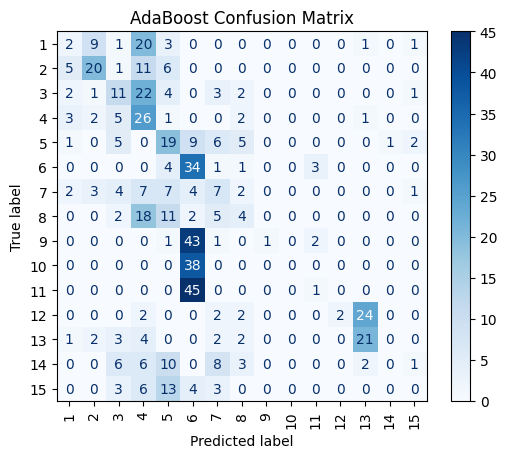

              precision    recall  f1-score   support

           1       0.12      0.05      0.08        37
           2       0.54      0.47      0.50        43
           3       0.27      0.24      0.25        46
           4       0.21      0.65      0.32        40
           5       0.24      0.40      0.30        48
           6       0.19      0.79      0.31        43
           7       0.18      0.19      0.19        37
           8       0.17      0.10      0.12        42
           9       1.00      0.02      0.04        48
          10       0.00      0.00      0.00        38
          11       0.17      0.02      0.04        46
          12       1.00      0.06      0.12        32
          13       0.43      0.60      0.50        35
          14       0.00      0.00      0.00        36
          15       0.00      0.00      0.00        29

    accuracy                           0.25       600
   macro avg       0.30      0.24      0.18       600
weighted avg       0.31   

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


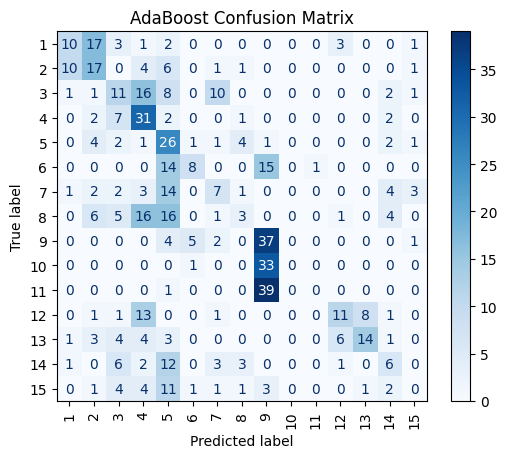

              precision    recall  f1-score   support

           1       0.42      0.27      0.33        37
           2       0.31      0.42      0.36        40
           3       0.24      0.22      0.23        50
           4       0.33      0.69      0.44        45
           5       0.22      0.60      0.32        43
           6       0.50      0.21      0.30        38
           7       0.26      0.19      0.22        37
           8       0.21      0.06      0.09        52
           9       0.29      0.76      0.42        49
          10       0.00      0.00      0.00        34
          11       0.00      0.00      0.00        40
          12       0.50      0.31      0.38        36
          13       0.61      0.39      0.47        36
          14       0.25      0.18      0.21        34
          15       0.00      0.00      0.00        29

    accuracy                           0.30       600
   macro avg       0.28      0.29      0.25       600
weighted avg       0.28   

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


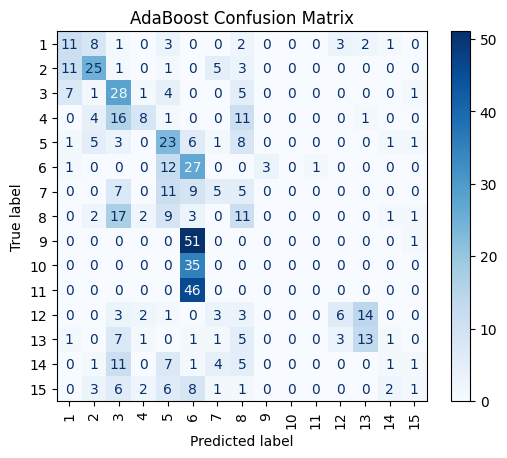

              precision    recall  f1-score   support

           1       0.34      0.35      0.35        31
           2       0.51      0.54      0.53        46
           3       0.28      0.60      0.38        47
           4       0.50      0.20      0.28        41
           5       0.29      0.47      0.36        49
           6       0.14      0.61      0.23        44
           7       0.25      0.14      0.18        37
           8       0.19      0.24      0.21        46
           9       0.00      0.00      0.00        52
          10       0.00      0.00      0.00        35
          11       0.00      0.00      0.00        46
          12       0.50      0.19      0.27        32
          13       0.43      0.39      0.41        33
          14       0.14      0.03      0.05        31
          15       0.17      0.03      0.06        30

    accuracy                           0.27       600
   macro avg       0.25      0.25      0.22       600
weighted avg       0.24   

feature_set     model        cv_type  cv_accuracy     cv_f1  \
0   Feature_W100_Olap0  AdaBoost  Stratified-5F     0.310000  0.246624   
1  Feature_W100_Olap50  AdaBoost  Stratified-5F     0.288571  0.254464   
2   Feature_W200_Olap0  AdaBoost  Stratified-5F     0.272857  0.242590   
3  Feature_W200_Olap50  AdaBoost  Stratified-5F     0.260714  0.222647   
4   Feature_W300_Olap0  AdaBoost  Stratified-5F     0.241429  0.204350   
5  Feature_W300_Olap50  AdaBoost  Stratified-5F     0.267857  0.226752   
6   Feature_W400_Olap0  AdaBoost  Stratified-5F     0.262857  0.233111   
7  Feature_W400_Olap50  AdaBoost  Stratified-5F     0.290714  0.239555   
8   Feature_W500_Olap0  AdaBoost  Stratified-5F     0.293571  0.258931   
9  Feature_W500_Olap50  AdaBoost  Stratified-5F     0.264286  0.216730   

   cv_recall  cv_precision  
0   0.290903      0.292788  
1   0.278500      0.319555  
2   0.267580      0.307922  
3   0.251226      0.269687  
4   0.234618      0.218474  
5   0.259040      0.252426  
6   0.262924      0.255021  
7   0.276535      0.286946  
8   0.284592      0.298747  
9   0.255090      0.262595

### Hyperparameter Tuning & Test Metrics ###


feature_set     model       tuning_method  \
0   Feature_W100_Olap0  AdaBoost  RandomizedSearchCV   
1  Feature_W100_Olap50  AdaBoost  RandomizedSearchCV   
2   Feature_W200_Olap0  AdaBoost  RandomizedSearchCV   
3  Feature_W200_Olap50  AdaBoost  RandomizedSearchCV   
4   Feature_W300_Olap0  AdaBoost  RandomizedSearchCV   
5  Feature_W300_Olap50  AdaBoost  RandomizedSearchCV   
6   Feature_W400_Olap0  AdaBoost  RandomizedSearchCV   
7  Feature_W400_Olap50  AdaBoost  RandomizedSearchCV   
8   Feature_W500_Olap0  AdaBoost  RandomizedSearchCV   
9  Feature_W500_Olap50  AdaBoost  RandomizedSearchCV   

                                         best_params  test_accuracy   test_f1  \
0  {'clf__n_estimators': 50, 'clf__learning_rate'...       0.313333  0.244854   
1  {'clf__n_estimators': 200, 'clf__learning_rate...       0.285000  0.261209   
2  {'clf__n_estimators': 200, 'clf__learning_rate...       0.245000  0.205064   
3  {'clf__n_estimators': 200, 'clf__learning_rate...       0.285000  0.250686   
4  {'clf__n_estimators': 200, 'clf__learning_rate...       0.266667  0.228909   
5  {'clf__n_estimators': 200, 'clf__learning_rate...       0.278333  0.226048   
6  {'clf__n_estimators': 200, 'clf__learning_rate...       0.243333  0.212758   
7  {'clf__n_estimators': 100, 'clf__learning_rate...       0.246667  0.184101   
8  {'clf__n_estimators': 200, 'clf__learning_rate...       0.301667  0.251321   
9  {'clf__n_estimators': 200, 'clf__learning_rate...       0.265000  0.220781   

   test_precision  test_recall  
0        0.295245     0.285746  
1        0.310386     0.274635  
2        0.250135     0.238644  
3        0.352321     0.281354  
4        0.233594     0.262979  
5        0.307622     0.266962  
6        0.268109     0.236272  
7        0.302051     0.238955  
8        0.276135     0.286149  
9        0.250167     0.252900

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier

# 1) Pipeline
ada_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf',   AdaBoostClassifier(random_state=42))
])

# 2) Hyperparameter space
ada_params = {
    'clf__n_estimators':   [50, 100, 200],
    'clf__learning_rate':  [0.01, 0.1, 1]
}

# 3) Run evaluation (n_iter=10 covers 3×3 combos)
ada_df = evaluate_model(
    model_name='AdaBoost',
    pipeline=ada_pipe,
    param_dist=ada_params,
    n_iter=10
)

# 4) Split into tuning & CV tables
tune_ada, cv_ada = summarize(ada_df)


## Gradient Boosting Evaluation



>> Gradient Boosting on Feature_W100_Olap0.csv <<


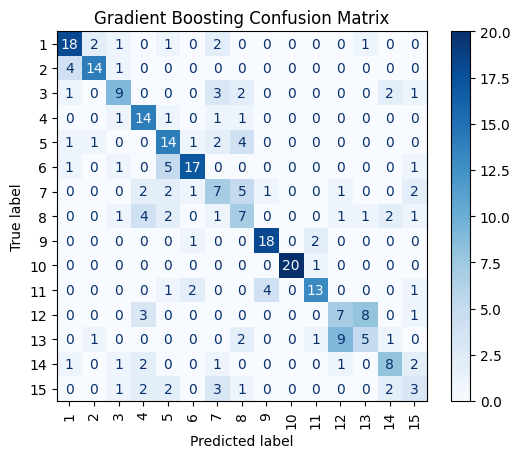

              precision    recall  f1-score   support

           1       0.69      0.72      0.71        25
           2       0.78      0.74      0.76        19
           3       0.56      0.50      0.53        18
           4       0.52      0.78      0.62        18
           5       0.50      0.61      0.55        23
           6       0.77      0.68      0.72        25
           7       0.35      0.33      0.34        21
           8       0.32      0.35      0.33        20
           9       0.78      0.86      0.82        21
          10       1.00      0.95      0.98        21
          11       0.76      0.62      0.68        21
          12       0.37      0.37      0.37        19
          13       0.33      0.26      0.29        19
          14       0.53      0.50      0.52        16
          15       0.25      0.21      0.23        14

    accuracy                           0.58       300
   macro avg       0.57      0.57      0.56       300
weighted avg       0.58   

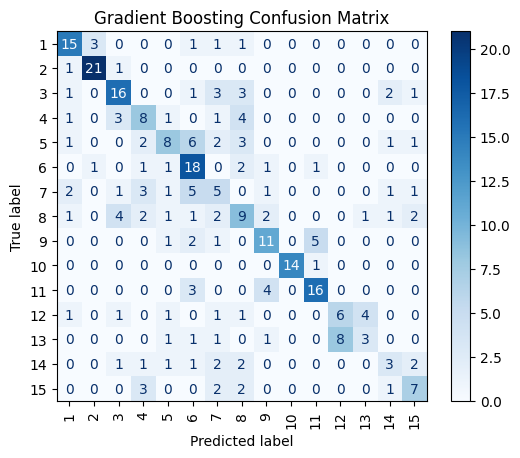

              precision    recall  f1-score   support

           1       0.65      0.71      0.68        21
           2       0.84      0.91      0.88        23
           3       0.59      0.59      0.59        27
           4       0.40      0.44      0.42        18
           5       0.50      0.33      0.40        24
           6       0.46      0.72      0.56        25
           7       0.24      0.25      0.24        20
           8       0.33      0.35      0.34        26
           9       0.55      0.55      0.55        20
          10       1.00      0.93      0.97        15
          11       0.70      0.70      0.70        23
          12       0.43      0.40      0.41        15
          13       0.38      0.20      0.26        15
          14       0.33      0.23      0.27        13
          15       0.50      0.47      0.48        15

    accuracy                           0.53       300
   macro avg       0.53      0.52      0.52       300
weighted avg       0.53   

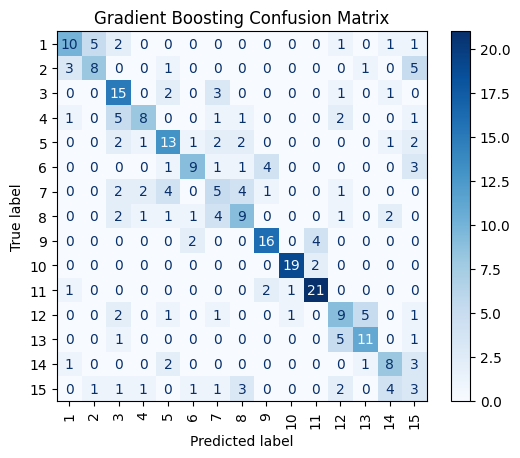

              precision    recall  f1-score   support

           1       0.62      0.50      0.56        20
           2       0.57      0.44      0.50        18
           3       0.47      0.68      0.56        22
           4       0.62      0.42      0.50        19
           5       0.52      0.54      0.53        24
           6       0.64      0.47      0.55        19
           7       0.28      0.26      0.27        19
           8       0.45      0.43      0.44        21
           9       0.70      0.73      0.71        22
          10       0.90      0.90      0.90        21
          11       0.78      0.84      0.81        25
          12       0.41      0.45      0.43        20
          13       0.61      0.61      0.61        18
          14       0.47      0.53      0.50        15
          15       0.15      0.18      0.16        17

    accuracy                           0.55       300
   macro avg       0.55      0.53      0.53       300
weighted avg       0.56   

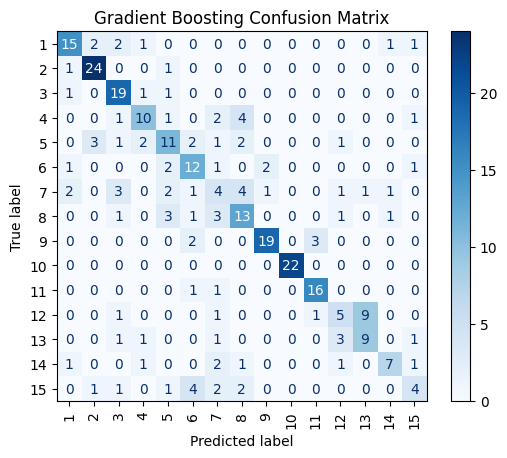

              precision    recall  f1-score   support

           1       0.71      0.68      0.70        22
           2       0.80      0.92      0.86        26
           3       0.63      0.86      0.73        22
           4       0.62      0.53      0.57        19
           5       0.50      0.48      0.49        23
           6       0.52      0.63      0.57        19
           7       0.22      0.20      0.21        20
           8       0.50      0.57      0.53        23
           9       0.86      0.79      0.83        24
          10       1.00      1.00      1.00        22
          11       0.80      0.89      0.84        18
          12       0.42      0.29      0.34        17
          13       0.47      0.56      0.51        16
          14       0.70      0.50      0.58        14
          15       0.44      0.27      0.33        15

    accuracy                           0.63       300
   macro avg       0.61      0.61      0.61       300
weighted avg       0.63   

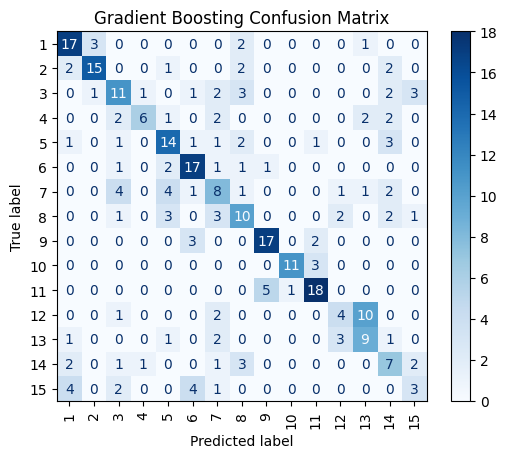

              precision    recall  f1-score   support

           1       0.63      0.74      0.68        23
           2       0.79      0.68      0.73        22
           3       0.46      0.46      0.46        24
           4       0.75      0.40      0.52        15
           5       0.54      0.58      0.56        24
           6       0.63      0.74      0.68        23
           7       0.35      0.36      0.36        22
           8       0.42      0.45      0.43        22
           9       0.74      0.77      0.76        22
          10       0.92      0.79      0.85        14
          11       0.75      0.75      0.75        24
          12       0.40      0.24      0.30        17
          13       0.39      0.53      0.45        17
          14       0.33      0.41      0.37        17
          15       0.33      0.21      0.26        14

    accuracy                           0.56       300
   macro avg       0.56      0.54      0.54       300
weighted avg       0.56   

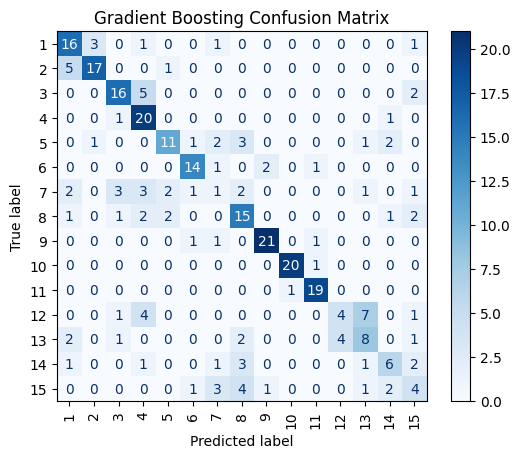

              precision    recall  f1-score   support

           1       0.59      0.73      0.65        22
           2       0.81      0.74      0.77        23
           3       0.70      0.70      0.70        23
           4       0.56      0.91      0.69        22
           5       0.69      0.52      0.59        21
           6       0.78      0.78      0.78        18
           7       0.10      0.06      0.08        16
           8       0.52      0.62      0.57        24
           9       0.88      0.88      0.88        24
          10       0.95      0.95      0.95        21
          11       0.86      0.95      0.90        20
          12       0.50      0.24      0.32        17
          13       0.42      0.44      0.43        18
          14       0.50      0.40      0.44        15
          15       0.29      0.25      0.27        16

    accuracy                           0.64       300
   macro avg       0.61      0.61      0.60       300
weighted avg       0.63   

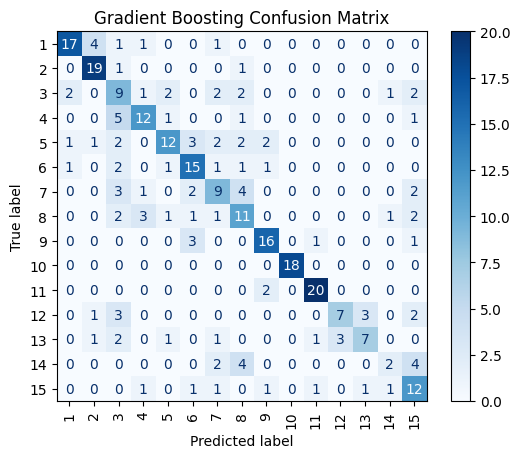

              precision    recall  f1-score   support

           1       0.81      0.71      0.76        24
           2       0.73      0.90      0.81        21
           3       0.30      0.43      0.35        21
           4       0.63      0.60      0.62        20
           5       0.67      0.48      0.56        25
           6       0.60      0.68      0.64        22
           7       0.45      0.43      0.44        21
           8       0.42      0.50      0.46        22
           9       0.73      0.76      0.74        21
          10       1.00      1.00      1.00        18
          11       0.87      0.91      0.89        22
          12       0.70      0.44      0.54        16
          13       0.64      0.44      0.52        16
          14       0.40      0.17      0.24        12
          15       0.46      0.63      0.53        19

    accuracy                           0.62       300
   macro avg       0.63      0.61      0.61       300
weighted avg       0.63   

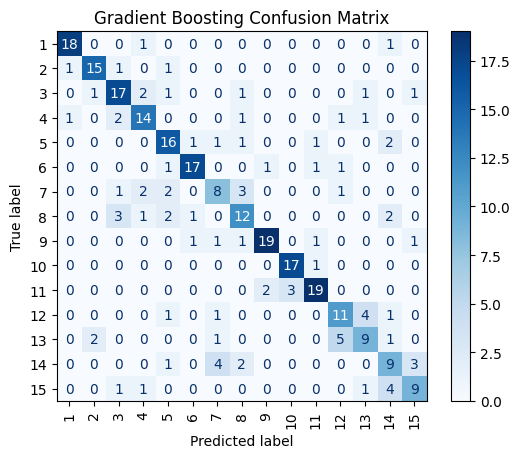

              precision    recall  f1-score   support

           1       0.90      0.90      0.90        20
           2       0.83      0.83      0.83        18
           3       0.68      0.71      0.69        24
           4       0.67      0.70      0.68        20
           5       0.64      0.73      0.68        22
           6       0.85      0.81      0.83        21
           7       0.50      0.47      0.48        17
           8       0.57      0.57      0.57        21
           9       0.86      0.79      0.83        24
          10       0.85      0.94      0.89        18
          11       0.83      0.79      0.81        24
          12       0.58      0.61      0.59        18
          13       0.56      0.50      0.53        18
          14       0.45      0.47      0.46        19
          15       0.64      0.56      0.60        16

    accuracy                           0.70       300
   macro avg       0.69      0.69      0.69       300
weighted avg       0.70   

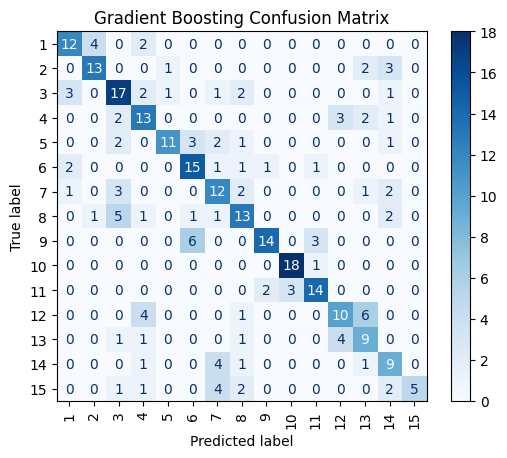

              precision    recall  f1-score   support

           1       0.67      0.67      0.67        18
           2       0.72      0.68      0.70        19
           3       0.55      0.63      0.59        27
           4       0.52      0.62      0.57        21
           5       0.85      0.55      0.67        20
           6       0.60      0.71      0.65        21
           7       0.48      0.57      0.52        21
           8       0.54      0.54      0.54        24
           9       0.82      0.61      0.70        23
          10       0.86      0.95      0.90        19
          11       0.74      0.74      0.74        19
          12       0.59      0.48      0.53        21
          13       0.43      0.56      0.49        16
          14       0.43      0.56      0.49        16
          15       1.00      0.33      0.50        15

    accuracy                           0.62       300
   macro avg       0.65      0.61      0.62       300
weighted avg       0.65   

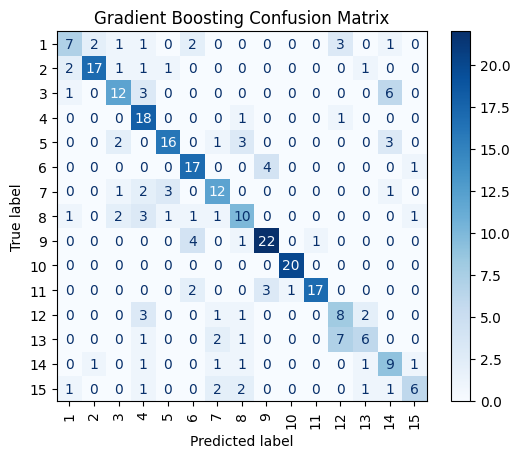

              precision    recall  f1-score   support

           1       0.58      0.41      0.48        17
           2       0.85      0.74      0.79        23
           3       0.63      0.55      0.59        22
           4       0.53      0.90      0.67        20
           5       0.76      0.64      0.70        25
           6       0.65      0.77      0.71        22
           7       0.60      0.63      0.62        19
           8       0.50      0.50      0.50        20
           9       0.76      0.79      0.77        28
          10       0.95      1.00      0.98        20
          11       0.94      0.74      0.83        23
          12       0.42      0.53      0.47        15
          13       0.55      0.35      0.43        17
          14       0.43      0.60      0.50        15
          15       0.67      0.43      0.52        14

    accuracy                           0.66       300
   macro avg       0.66      0.64      0.64       300
weighted avg       0.67   

feature_set              model        cv_type  cv_accuracy  \
0   Feature_W100_Olap0  Gradient Boosting  Stratified-5F     0.521429   
1  Feature_W100_Olap50  Gradient Boosting  Stratified-5F     0.541429   
2   Feature_W200_Olap0  Gradient Boosting  Stratified-5F     0.564286   
3  Feature_W200_Olap50  Gradient Boosting  Stratified-5F     0.611429   
4   Feature_W300_Olap0  Gradient Boosting  Stratified-5F     0.611429   
5  Feature_W300_Olap50  Gradient Boosting  Stratified-5F     0.611429   
6   Feature_W400_Olap0  Gradient Boosting  Stratified-5F     0.602857   
7  Feature_W400_Olap50  Gradient Boosting  Stratified-5F     0.637143   
8   Feature_W500_Olap0  Gradient Boosting  Stratified-5F     0.632857   
9  Feature_W500_Olap50  Gradient Boosting  Stratified-5F     0.687143   

      cv_f1  cv_recall  cv_precision  
0  0.504309   0.507907      0.527519  
1  0.516214   0.520749      0.552305  
2  0.543682   0.550232      0.566610  
3  0.584229   0.589093      0.601404  
4  0.594927   0.596203      0.619152  
5  0.585008   0.587076      0.616207  
6  0.578563   0.588229      0.589838  
7  0.619812   0.624622      0.638138  
8  0.620366   0.623467      0.658391  
9  0.667683   0.666328      0.698126

### Hyperparameter Tuning & Test Metrics ###


feature_set              model       tuning_method  \
0   Feature_W100_Olap0  Gradient Boosting  RandomizedSearchCV   
1  Feature_W100_Olap50  Gradient Boosting  RandomizedSearchCV   
2   Feature_W200_Olap0  Gradient Boosting  RandomizedSearchCV   
3  Feature_W200_Olap50  Gradient Boosting  RandomizedSearchCV   
4   Feature_W300_Olap0  Gradient Boosting  RandomizedSearchCV   
5  Feature_W300_Olap50  Gradient Boosting  RandomizedSearchCV   
6   Feature_W400_Olap0  Gradient Boosting  RandomizedSearchCV   
7  Feature_W400_Olap50  Gradient Boosting  RandomizedSearchCV   
8   Feature_W500_Olap0  Gradient Boosting  RandomizedSearchCV   
9  Feature_W500_Olap50  Gradient Boosting  RandomizedSearchCV   

                                         best_params  test_accuracy   test_f1  \
0  {'clf__n_estimators': 200, 'clf__max_depth': 3...       0.580000  0.563262   
1  {'clf__n_estimators': 200, 'clf__max_depth': 3...       0.533333  0.517187   
2  {'clf__n_estimators': 200, 'clf__max_depth': 3...       0.546667  0.534792   
3  {'clf__n_estimators': 200, 'clf__max_depth': 5...       0.633333  0.606830   
4  {'clf__n_estimators': 200, 'clf__max_depth': 3...       0.556667  0.543294   
5  {'clf__n_estimators': 200, 'clf__max_depth': 3...       0.640000  0.601474   
6  {'clf__n_estimators': 200, 'clf__max_depth': 5...       0.620000  0.605658   
7  {'clf__n_estimators': 200, 'clf__max_depth': 5...       0.700000  0.692761   
8  {'clf__n_estimators': 200, 'clf__max_depth': 5...       0.616667  0.615945   
9  {'clf__n_estimators': 200, 'clf__max_depth': 3...       0.656667  0.636171   

   test_precision  test_recall  
0        0.568294     0.565406  
1        0.526686     0.519352  
2        0.546012     0.533156  
3        0.614334     0.611583  
4        0.561586     0.541275  
5        0.608909     0.611157  
6        0.627090     0.605087  
7        0.694364     0.693037  
8        0.652533     0.613624  
9        0.655151     0.638690

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier

# 1) Pipeline
gb_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf',   GradientBoostingClassifier(random_state=42))
])

# 2) Hyperparameter space
gb_params = {
    'clf__n_estimators':   [100, 200],
    'clf__learning_rate':  [0.01, 0.1, 0.2],
    'clf__max_depth':      [3, 5, 7]
}

# 3) Run evaluation (n_iter=15)
gb_df = evaluate_model(
    model_name='Gradient Boosting',
    pipeline=gb_pipe,
    param_dist=gb_params,
    n_iter=15,
)

# 4) Split into tuning & CV tables
tune_gb, cv_gb = summarize(gb_df)


## XGBoost Evaluation



>> XGBoost on Feature_W100_Olap0.csv <<


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:14:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


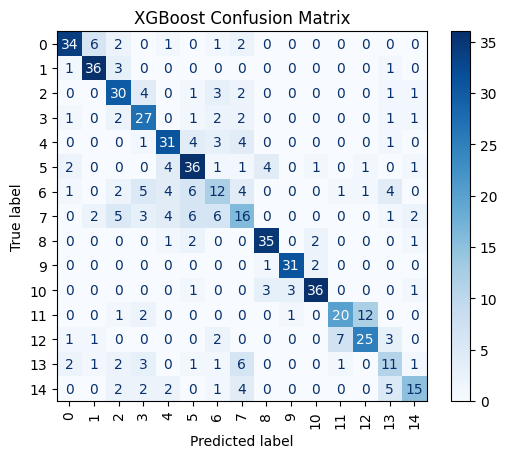

              precision    recall  f1-score   support

           0       0.81      0.74      0.77        46
           1       0.78      0.88      0.83        41
           2       0.61      0.71      0.66        42
           3       0.57      0.73      0.64        37
           4       0.66      0.70      0.68        44
           5       0.62      0.71      0.66        51
           6       0.38      0.30      0.33        40
           7       0.39      0.36      0.37        45
           8       0.81      0.85      0.83        41
           9       0.89      0.91      0.90        34
          10       0.88      0.82      0.85        44
          11       0.69      0.56      0.62        36
          12       0.64      0.64      0.64        39
          13       0.39      0.38      0.39        29
          14       0.65      0.48      0.56        31

    accuracy                           0.66       600
   macro avg       0.65      0.65      0.65       600
weighted avg       0.66   

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:24:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


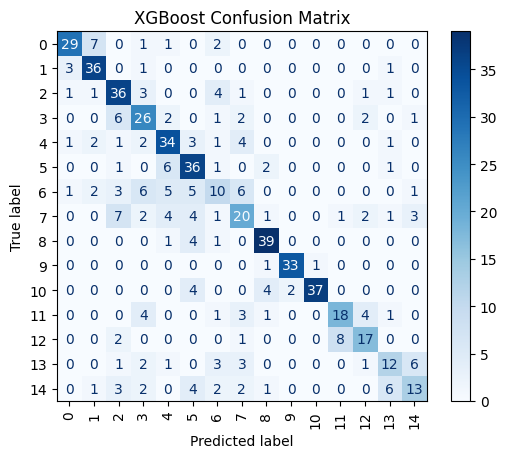

              precision    recall  f1-score   support

           0       0.83      0.72      0.77        40
           1       0.73      0.88      0.80        41
           2       0.60      0.75      0.67        48
           3       0.53      0.65      0.58        40
           4       0.63      0.69      0.66        49
           5       0.60      0.77      0.67        47
           6       0.37      0.26      0.30        39
           7       0.48      0.43      0.45        46
           8       0.80      0.87      0.83        45
           9       0.94      0.94      0.94        35
          10       0.97      0.79      0.87        47
          11       0.67      0.56      0.61        32
          12       0.63      0.61      0.62        28
          13       0.50      0.41      0.45        29
          14       0.54      0.38      0.45        34

    accuracy                           0.66       600
   macro avg       0.65      0.65      0.65       600
weighted avg       0.66   

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:33:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


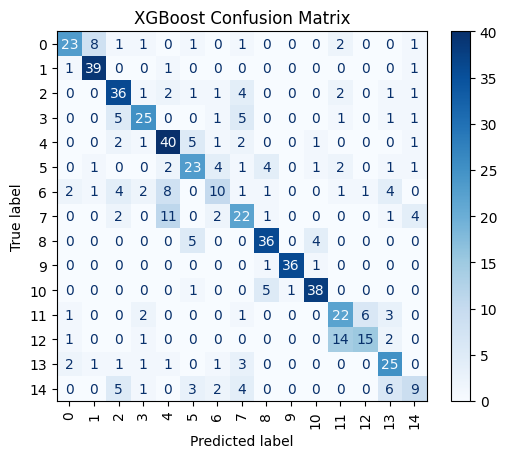

              precision    recall  f1-score   support

           0       0.77      0.61      0.68        38
           1       0.78      0.93      0.85        42
           2       0.64      0.73      0.69        49
           3       0.71      0.64      0.68        39
           4       0.62      0.75      0.68        53
           5       0.59      0.57      0.58        40
           6       0.45      0.29      0.35        35
           7       0.50      0.51      0.51        43
           8       0.75      0.80      0.77        45
           9       0.97      0.95      0.96        38
          10       0.84      0.84      0.84        45
          11       0.50      0.63      0.56        35
          12       0.68      0.45      0.55        33
          13       0.57      0.71      0.63        35
          14       0.47      0.30      0.37        30

    accuracy                           0.67       600
   macro avg       0.66      0.65      0.65       600
weighted avg       0.66   

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:42:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


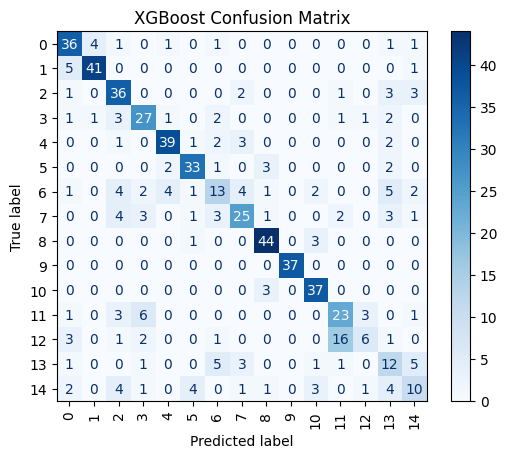

              precision    recall  f1-score   support

           0       0.71      0.80      0.75        45
           1       0.89      0.87      0.88        47
           2       0.63      0.78      0.70        46
           3       0.64      0.69      0.67        39
           4       0.83      0.81      0.82        48
           5       0.80      0.80      0.80        41
           6       0.46      0.33      0.39        39
           7       0.66      0.58      0.62        43
           8       0.83      0.92      0.87        48
           9       1.00      1.00      1.00        37
          10       0.80      0.93      0.86        40
          11       0.52      0.62      0.57        37
          12       0.55      0.20      0.29        30
          13       0.34      0.41      0.38        29
          14       0.42      0.32      0.36        31

    accuracy                           0.70       600
   macro avg       0.67      0.67      0.66       600
weighted avg       0.69   

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:51:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


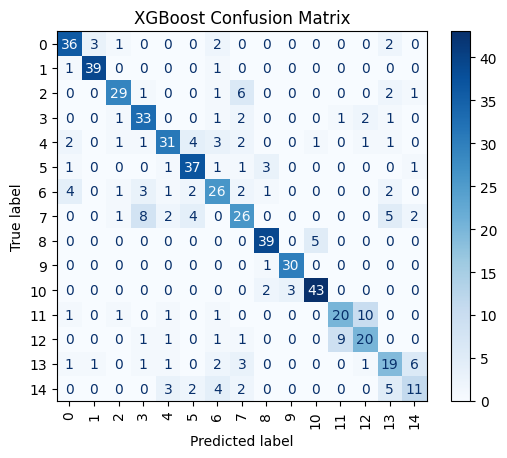

              precision    recall  f1-score   support

           0       0.78      0.82      0.80        44
           1       0.91      0.95      0.93        41
           2       0.83      0.72      0.77        40
           3       0.69      0.80      0.74        41
           4       0.76      0.66      0.70        47
           5       0.76      0.82      0.79        45
           6       0.60      0.62      0.61        42
           7       0.58      0.54      0.56        48
           8       0.85      0.89      0.87        44
           9       0.91      0.97      0.94        31
          10       0.88      0.90      0.89        48
          11       0.67      0.59      0.62        34
          12       0.59      0.61      0.60        33
          13       0.51      0.54      0.53        35
          14       0.52      0.41      0.46        27

    accuracy                           0.73       600
   macro avg       0.72      0.72      0.72       600
weighted avg       0.73   

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:00:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


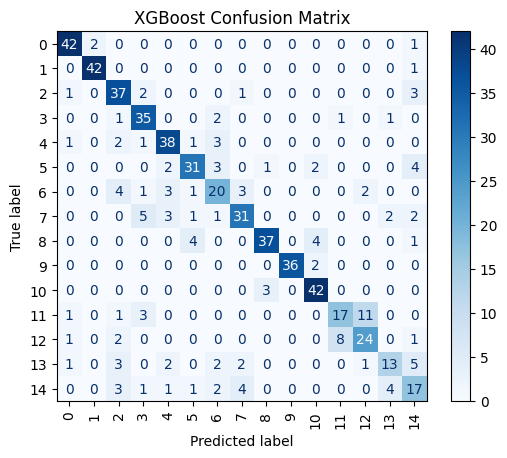

              precision    recall  f1-score   support

           0       0.89      0.93      0.91        45
           1       0.95      0.98      0.97        43
           2       0.70      0.84      0.76        44
           3       0.73      0.88      0.80        40
           4       0.78      0.83      0.80        46
           5       0.79      0.72      0.76        43
           6       0.61      0.59      0.60        34
           7       0.76      0.69      0.72        45
           8       0.90      0.80      0.85        46
           9       1.00      0.95      0.97        38
          10       0.84      0.93      0.88        45
          11       0.65      0.52      0.58        33
          12       0.63      0.67      0.65        36
          13       0.65      0.45      0.53        29
          14       0.49      0.52      0.50        33

    accuracy                           0.77       600
   macro avg       0.76      0.75      0.75       600
weighted avg       0.77   

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:09:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


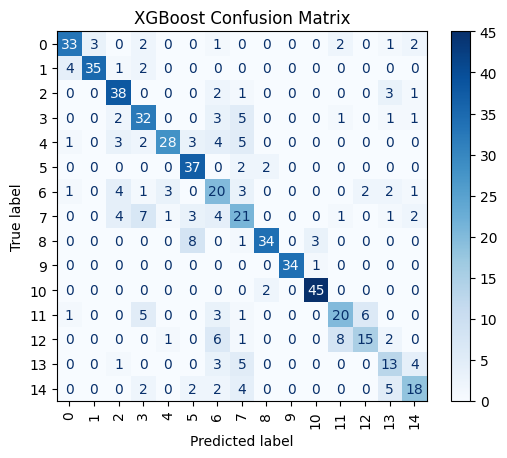

              precision    recall  f1-score   support

           0       0.82      0.75      0.79        44
           1       0.92      0.83      0.88        42
           2       0.72      0.84      0.78        45
           3       0.60      0.71      0.65        45
           4       0.85      0.61      0.71        46
           5       0.70      0.90      0.79        41
           6       0.42      0.54      0.47        37
           7       0.43      0.48      0.45        44
           8       0.89      0.74      0.81        46
           9       1.00      0.97      0.99        35
          10       0.92      0.96      0.94        47
          11       0.62      0.56      0.59        36
          12       0.65      0.45      0.54        33
          13       0.46      0.50      0.48        26
          14       0.62      0.55      0.58        33

    accuracy                           0.70       600
   macro avg       0.71      0.69      0.70       600
weighted avg       0.72   

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:17:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


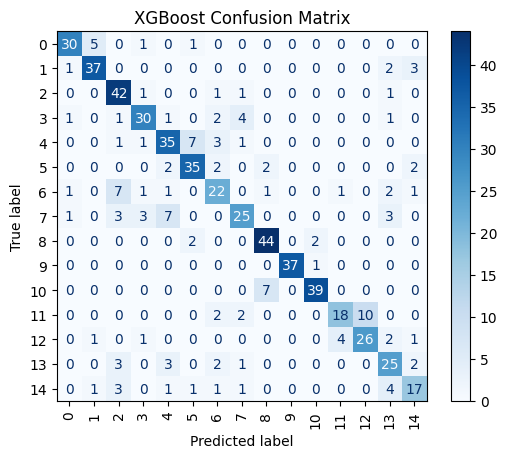

              precision    recall  f1-score   support

           0       0.88      0.81      0.85        37
           1       0.84      0.86      0.85        43
           2       0.70      0.91      0.79        46
           3       0.79      0.75      0.77        40
           4       0.70      0.73      0.71        48
           5       0.76      0.81      0.79        43
           6       0.63      0.59      0.61        37
           7       0.71      0.60      0.65        42
           8       0.81      0.92      0.86        48
           9       1.00      0.97      0.99        38
          10       0.93      0.85      0.89        46
          11       0.78      0.56      0.65        32
          12       0.72      0.74      0.73        35
          13       0.62      0.69      0.66        36
          14       0.65      0.59      0.62        29

    accuracy                           0.77       600
   macro avg       0.77      0.76      0.76       600
weighted avg       0.77   

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:26:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


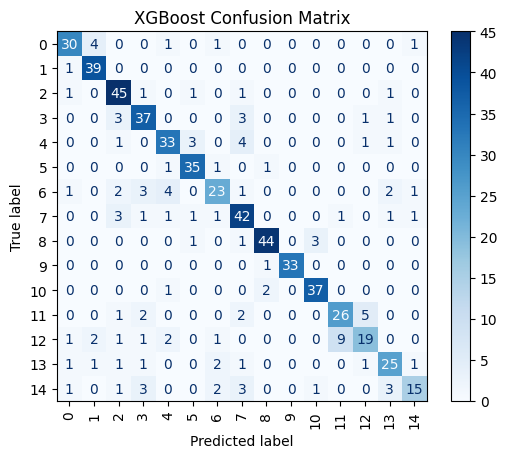

              precision    recall  f1-score   support

           0       0.83      0.81      0.82        37
           1       0.85      0.97      0.91        40
           2       0.78      0.90      0.83        50
           3       0.76      0.82      0.79        45
           4       0.77      0.77      0.77        43
           5       0.85      0.92      0.89        38
           6       0.74      0.62      0.68        37
           7       0.72      0.81      0.76        52
           8       0.92      0.90      0.91        49
           9       1.00      0.97      0.99        34
          10       0.90      0.93      0.91        40
          11       0.72      0.72      0.72        36
          12       0.70      0.53      0.60        36
          13       0.74      0.74      0.74        34
          14       0.79      0.52      0.62        29

    accuracy                           0.81       600
   macro avg       0.80      0.79      0.80       600
weighted avg       0.80   

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:35:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


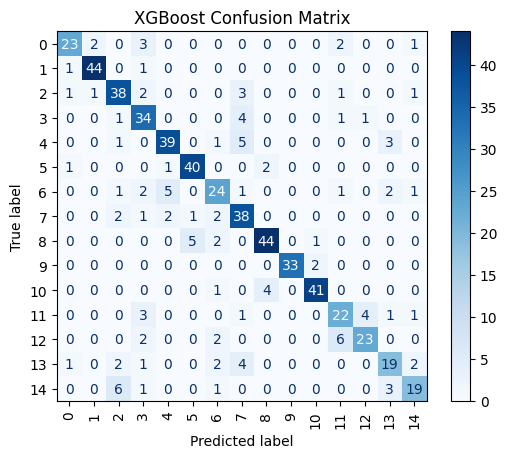

              precision    recall  f1-score   support

           0       0.85      0.74      0.79        31
           1       0.94      0.96      0.95        46
           2       0.75      0.81      0.78        47
           3       0.68      0.83      0.75        41
           4       0.83      0.80      0.81        49
           5       0.87      0.91      0.89        44
           6       0.69      0.65      0.67        37
           7       0.68      0.83      0.75        46
           8       0.88      0.85      0.86        52
           9       1.00      0.94      0.97        35
          10       0.93      0.89      0.91        46
          11       0.67      0.69      0.68        32
          12       0.82      0.70      0.75        33
          13       0.68      0.61      0.64        31
          14       0.76      0.63      0.69        30

    accuracy                           0.80       600
   macro avg       0.80      0.79      0.79       600
weighted avg       0.81   

feature_set    model        cv_type  cv_accuracy     cv_f1  \
0   Feature_W100_Olap0  XGBoost  Stratified-5F     0.592857  0.578771   
1  Feature_W100_Olap50  XGBoost  Stratified-5F     0.610714  0.594675   
2   Feature_W200_Olap0  XGBoost  Stratified-5F     0.635000  0.615372   
3  Feature_W200_Olap50  XGBoost  Stratified-5F     0.657857  0.642147   
4   Feature_W300_Olap0  XGBoost  Stratified-5F     0.672143  0.659606   
5  Feature_W300_Olap50  XGBoost  Stratified-5F     0.704286  0.683741   
6   Feature_W400_Olap0  XGBoost  Stratified-5F     0.710714  0.690641   
7  Feature_W400_Olap50  XGBoost  Stratified-5F     0.742143  0.729879   
8   Feature_W500_Olap0  XGBoost  Stratified-5F     0.745000  0.735622   
9  Feature_W500_Olap50  XGBoost  Stratified-5F     0.750000  0.732427   

   cv_recall  cv_precision  
0   0.581802      0.586213  
1   0.595567      0.608126  
2   0.618737      0.626719  
3   0.642887      0.653414  
4   0.661713      0.672255  
5   0.688156      0.688464  
6   0.693686      0.699797  
7   0.729074      0.741470  
8   0.735275      0.745945  
9   0.732461      0.742202

### Hyperparameter Tuning & Test Metrics ###


feature_set    model       tuning_method  \
0   Feature_W100_Olap0  XGBoost  RandomizedSearchCV   
1  Feature_W100_Olap50  XGBoost  RandomizedSearchCV   
2   Feature_W200_Olap0  XGBoost  RandomizedSearchCV   
3  Feature_W200_Olap50  XGBoost  RandomizedSearchCV   
4   Feature_W300_Olap0  XGBoost  RandomizedSearchCV   
5  Feature_W300_Olap50  XGBoost  RandomizedSearchCV   
6   Feature_W400_Olap0  XGBoost  RandomizedSearchCV   
7  Feature_W400_Olap50  XGBoost  RandomizedSearchCV   
8   Feature_W500_Olap0  XGBoost  RandomizedSearchCV   
9  Feature_W500_Olap50  XGBoost  RandomizedSearchCV   

                                         best_params  test_accuracy   test_f1  \
0  {'clf__subsample': 0.8, 'clf__n_estimators': 2...       0.658333  0.648445   
1  {'clf__subsample': 0.8, 'clf__n_estimators': 2...       0.660000  0.645842   
2  {'clf__subsample': 1.0, 'clf__n_estimators': 2...       0.665000  0.645591   
3  {'clf__subsample': 0.8, 'clf__n_estimators': 2...       0.698333  0.663978   
4  {'clf__subsample': 0.8, 'clf__n_estimators': 2...       0.731667  0.720337   
5  {'clf__subsample': 1.0, 'clf__n_estimators': 2...       0.770000  0.751616   
6  {'clf__subsample': 1.0, 'clf__n_estimators': 2...       0.705000  0.695079   
7  {'clf__subsample': 1.0, 'clf__n_estimators': 2...       0.770000  0.761159   
8  {'clf__subsample': 1.0, 'clf__n_estimators': 1...       0.805000  0.795643   
9  {'clf__subsample': 1.0, 'clf__n_estimators': 2...       0.801667  0.792380   

   test_precision  test_recall  
0        0.651852     0.651370  
1        0.654699     0.647775  
2        0.656972     0.648389  
3        0.672714     0.671935  
4        0.721732     0.722419  
5        0.758104     0.752028  
6        0.708926     0.692760  
7        0.769568     0.759431  
8        0.804606     0.794795  
9        0.801016     0.788467

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

# 1) Pipeline
xgb_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', XGBClassifier(
        objective='multi:softprob',
        eval_metric='mlogloss',
        use_label_encoder=False,
        random_state=42
    ))
])

# 2) Hyperparameter space
xgb_params = {
    'clf__n_estimators':   [100, 200],
    'clf__learning_rate':  [0.01, 0.1, 0.3],
    'clf__max_depth':      [3, 5, 7],
    'clf__subsample':      [0.6, 0.8, 1.0],
    'clf__colsample_bytree': [0.6, 0.8, 1.0]
}

# 3) Run evaluation (n_iter=20)
xgb_df = evaluate_model(
    model_name='XGBoost',
    pipeline=xgb_pipe,
    param_dist=xgb_params,
    n_iter=20,
    label_offset=1,
)

# 4) Split into tuning & CV tables
tune_xgb, cv_xgb = summarize(xgb_df)


## ANN (MLPClassifier) Evaluation with GridSearchCV & 5‐Fold CV




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

>> Processing Feature_W100_Olap0.csv <<


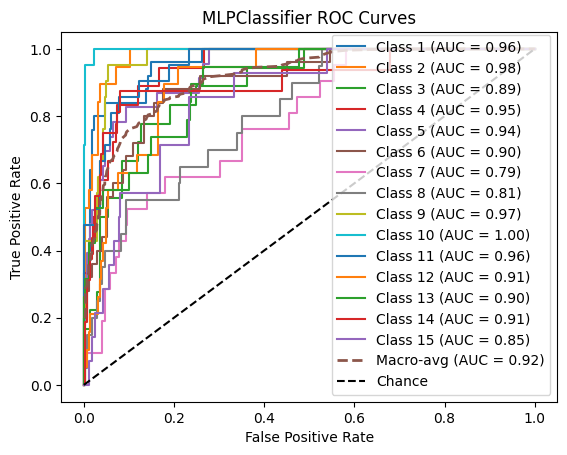

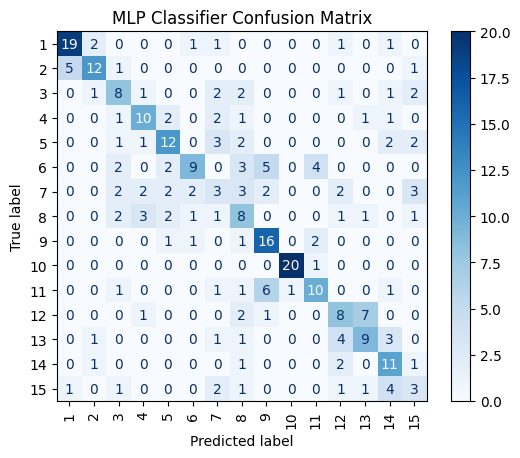

              precision    recall  f1-score   support

           1       0.76      0.76      0.76        25
           2       0.71      0.63      0.67        19
           3       0.42      0.44      0.43        18
           4       0.56      0.56      0.56        18
           5       0.57      0.52      0.55        23
           6       0.64      0.36      0.46        25
           7       0.19      0.14      0.16        21
           8       0.31      0.40      0.35        20
           9       0.53      0.76      0.63        21
          10       0.95      0.95      0.95        21
          11       0.59      0.48      0.53        21
          12       0.40      0.42      0.41        19
          13       0.47      0.47      0.47        19
          14       0.46      0.69      0.55        16
          15       0.23      0.21      0.22        14

    accuracy                           0.53       300
   macro avg       0.52      0.52      0.51       300
weighted avg       0.53   

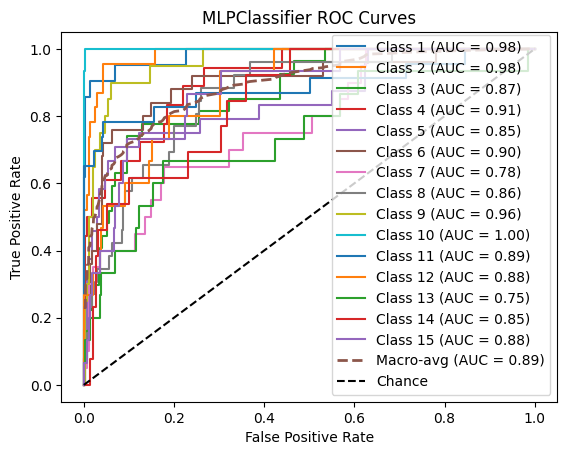

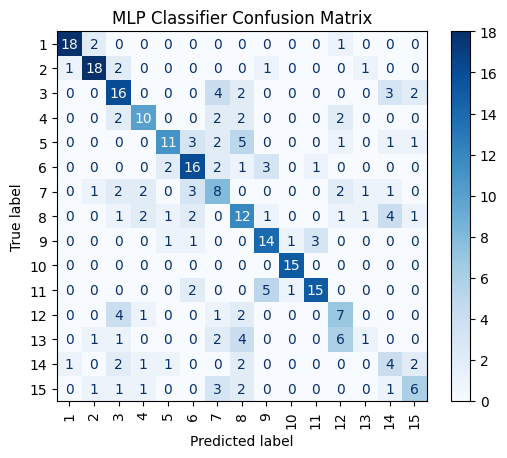

              precision    recall  f1-score   support

           1       0.90      0.86      0.88        21
           2       0.78      0.78      0.78        23
           3       0.52      0.59      0.55        27
           4       0.59      0.56      0.57        18
           5       0.69      0.46      0.55        24
           6       0.59      0.64      0.62        25
           7       0.33      0.40      0.36        20
           8       0.38      0.46      0.41        26
           9       0.58      0.70      0.64        20
          10       0.88      1.00      0.94        15
          11       0.79      0.65      0.71        23
          12       0.35      0.47      0.40        15
          13       0.25      0.07      0.11        15
          14       0.29      0.31      0.30        13
          15       0.50      0.40      0.44        15

    accuracy                           0.57       300
   macro avg       0.56      0.56      0.55       300
weighted avg       0.57   

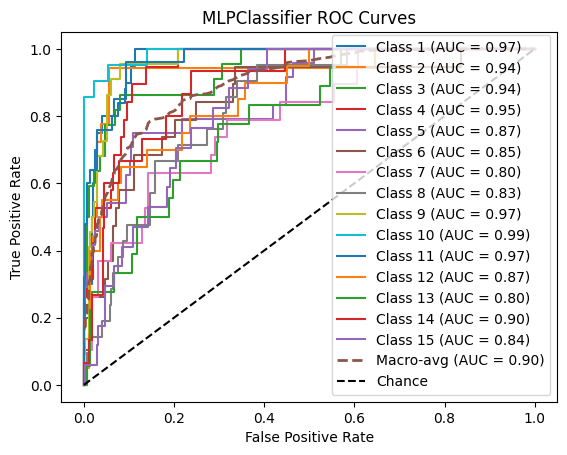

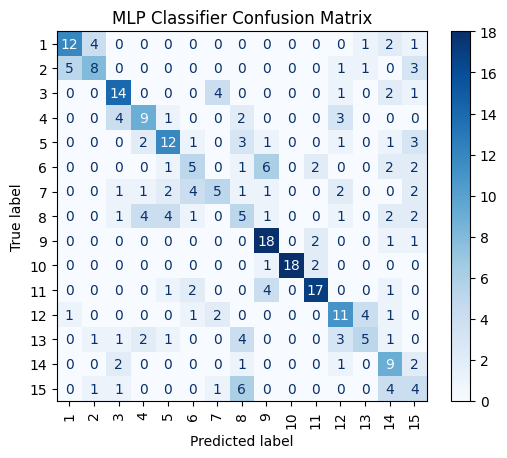

              precision    recall  f1-score   support

           1       0.67      0.60      0.63        20
           2       0.57      0.44      0.50        18
           3       0.58      0.64      0.61        22
           4       0.50      0.47      0.49        19
           5       0.55      0.50      0.52        24
           6       0.36      0.26      0.30        19
           7       0.42      0.26      0.32        19
           8       0.22      0.24      0.23        21
           9       0.56      0.82      0.67        22
          10       1.00      0.86      0.92        21
          11       0.74      0.68      0.71        25
          12       0.46      0.55      0.50        20
          13       0.45      0.28      0.34        18
          14       0.35      0.60      0.44        15
          15       0.19      0.24      0.21        17

    accuracy                           0.51       300
   macro avg       0.51      0.50      0.49       300
weighted avg       0.52   

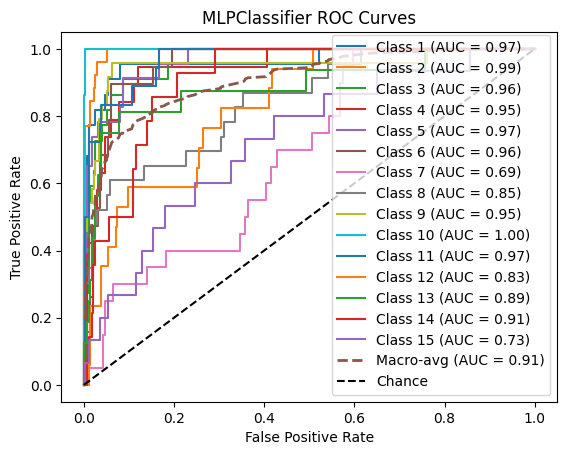

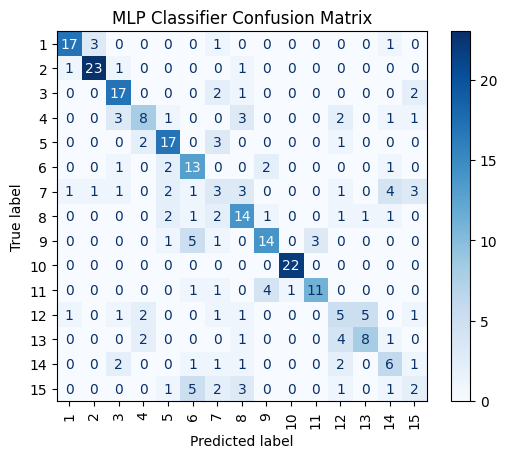

              precision    recall  f1-score   support

           1       0.85      0.77      0.81        22
           2       0.85      0.88      0.87        26
           3       0.65      0.77      0.71        22
           4       0.57      0.42      0.48        19
           5       0.65      0.74      0.69        23
           6       0.48      0.68      0.57        19
           7       0.18      0.15      0.16        20
           8       0.50      0.61      0.55        23
           9       0.67      0.58      0.62        24
          10       0.96      1.00      0.98        22
          11       0.79      0.61      0.69        18
          12       0.29      0.29      0.29        17
          13       0.57      0.50      0.53        16
          14       0.38      0.43      0.40        14
          15       0.20      0.13      0.16        15

    accuracy                           0.60       300
   macro avg       0.57      0.57      0.57       300
weighted avg       0.60   

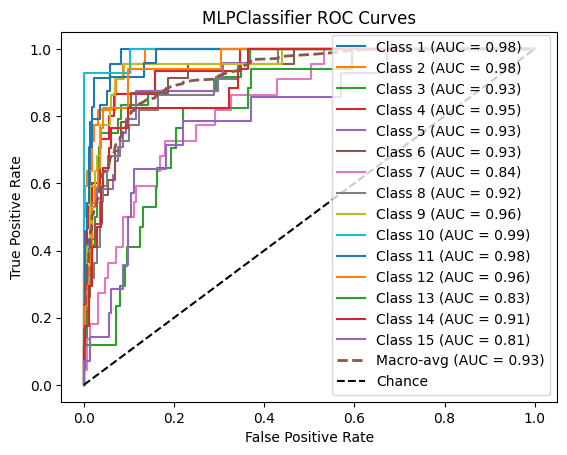

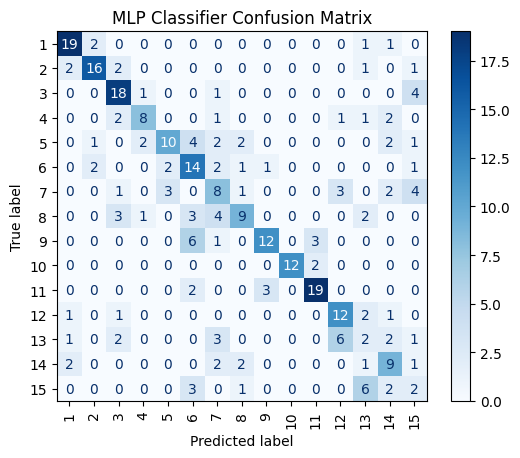

              precision    recall  f1-score   support

           1       0.76      0.83      0.79        23
           2       0.76      0.73      0.74        22
           3       0.62      0.75      0.68        24
           4       0.67      0.53      0.59        15
           5       0.67      0.42      0.51        24
           6       0.44      0.61      0.51        23
           7       0.33      0.36      0.35        22
           8       0.56      0.41      0.47        22
           9       0.75      0.55      0.63        22
          10       1.00      0.86      0.92        14
          11       0.79      0.79      0.79        24
          12       0.55      0.71      0.62        17
          13       0.12      0.12      0.12        17
          14       0.43      0.53      0.47        17
          15       0.13      0.14      0.14        14

    accuracy                           0.57       300
   macro avg       0.57      0.55      0.56       300
weighted avg       0.58   

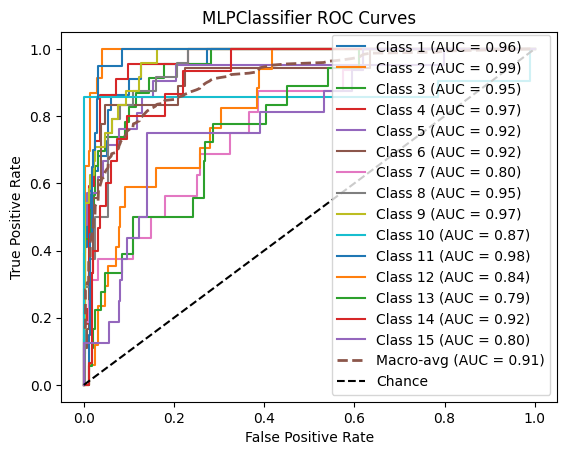

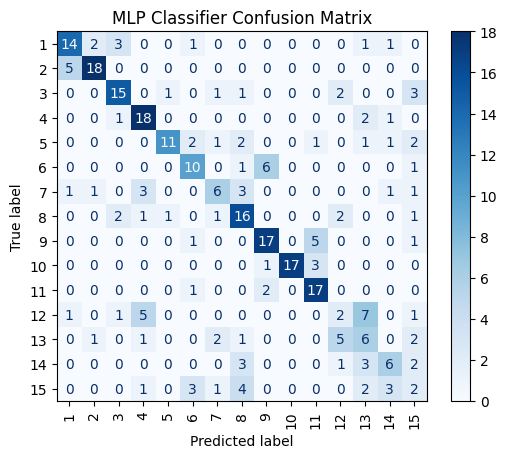

              precision    recall  f1-score   support

           1       0.67      0.64      0.65        22
           2       0.82      0.78      0.80        23
           3       0.68      0.65      0.67        23
           4       0.62      0.82      0.71        22
           5       0.85      0.52      0.65        21
           6       0.56      0.56      0.56        18
           7       0.50      0.38      0.43        16
           8       0.52      0.67      0.58        24
           9       0.65      0.71      0.68        24
          10       1.00      0.81      0.89        21
          11       0.65      0.85      0.74        20
          12       0.17      0.12      0.14        17
          13       0.27      0.33      0.30        18
          14       0.46      0.40      0.43        15
          15       0.12      0.12      0.12        16

    accuracy                           0.58       300
   macro avg       0.57      0.56      0.56       300
weighted avg       0.59   

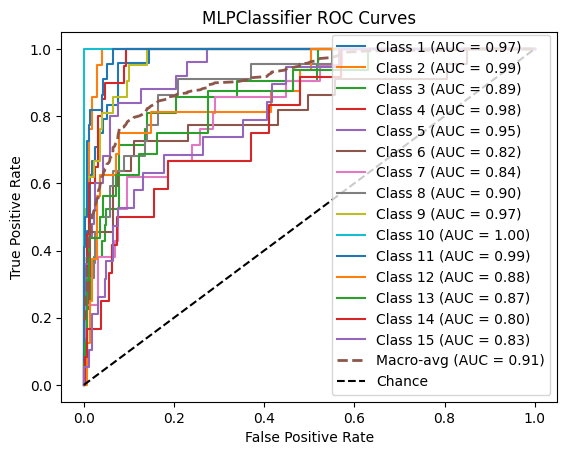

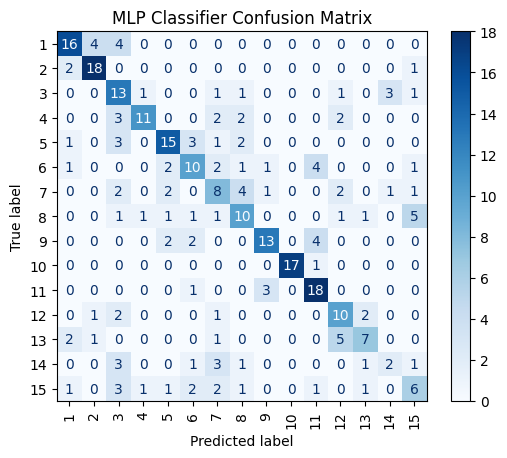

              precision    recall  f1-score   support

           1       0.70      0.67      0.68        24
           2       0.75      0.86      0.80        21
           3       0.38      0.62      0.47        21
           4       0.79      0.55      0.65        20
           5       0.65      0.60      0.62        25
           6       0.50      0.45      0.48        22
           7       0.36      0.38      0.37        21
           8       0.45      0.45      0.45        22
           9       0.72      0.62      0.67        21
          10       1.00      0.94      0.97        18
          11       0.64      0.82      0.72        22
          12       0.48      0.62      0.54        16
          13       0.58      0.44      0.50        16
          14       0.33      0.17      0.22        12
          15       0.38      0.32      0.34        19

    accuracy                           0.58       300
   macro avg       0.58      0.57      0.57       300
weighted avg       0.59   

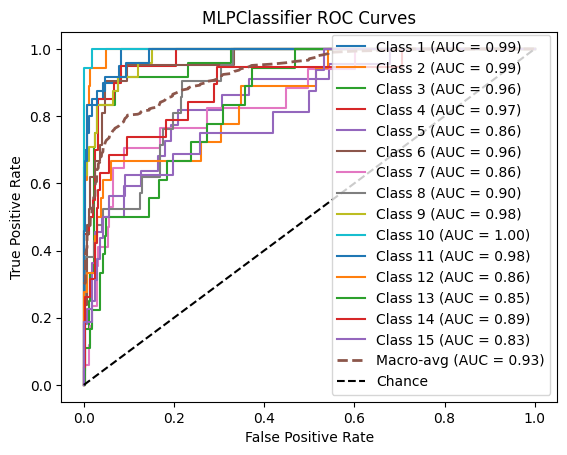

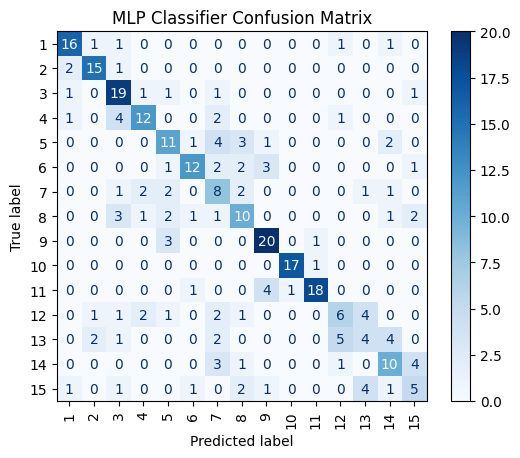

              precision    recall  f1-score   support

           1       0.76      0.80      0.78        20
           2       0.79      0.83      0.81        18
           3       0.59      0.79      0.68        24
           4       0.67      0.60      0.63        20
           5       0.52      0.50      0.51        22
           6       0.75      0.57      0.65        21
           7       0.32      0.47      0.38        17
           8       0.48      0.48      0.48        21
           9       0.69      0.83      0.75        24
          10       0.94      0.94      0.94        18
          11       0.90      0.75      0.82        24
          12       0.43      0.33      0.38        18
          13       0.31      0.22      0.26        18
          14       0.50      0.53      0.51        19
          15       0.38      0.31      0.34        16

    accuracy                           0.61       300
   macro avg       0.60      0.60      0.60       300
weighted avg       0.61   

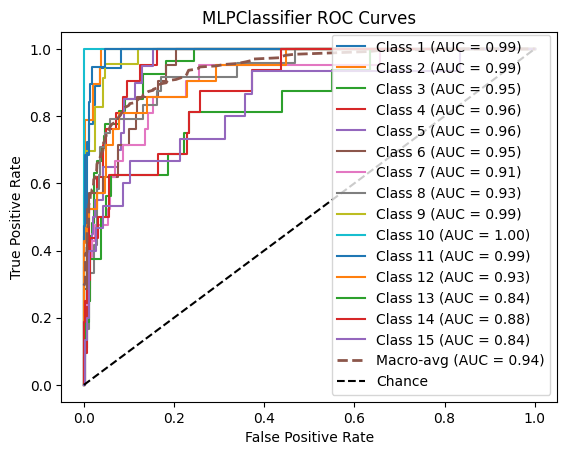

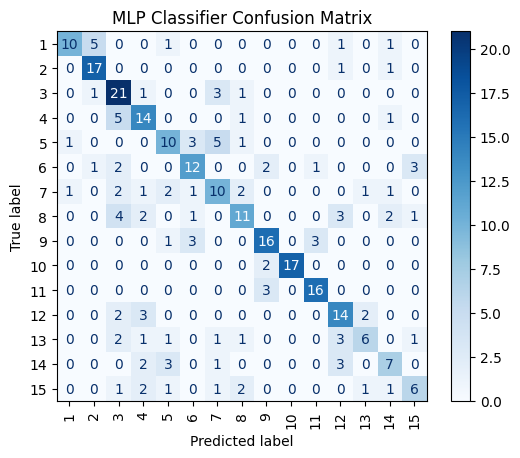

              precision    recall  f1-score   support

           1       0.83      0.56      0.67        18
           2       0.71      0.89      0.79        19
           3       0.54      0.78      0.64        27
           4       0.54      0.67      0.60        21
           5       0.53      0.50      0.51        20
           6       0.60      0.57      0.59        21
           7       0.48      0.48      0.48        21
           8       0.58      0.46      0.51        24
           9       0.70      0.70      0.70        23
          10       1.00      0.89      0.94        19
          11       0.80      0.84      0.82        19
          12       0.56      0.67      0.61        21
          13       0.60      0.38      0.46        16
          14       0.50      0.44      0.47        16
          15       0.55      0.40      0.46        15

    accuracy                           0.62       300
   macro avg       0.63      0.61      0.62       300
weighted avg       0.63   

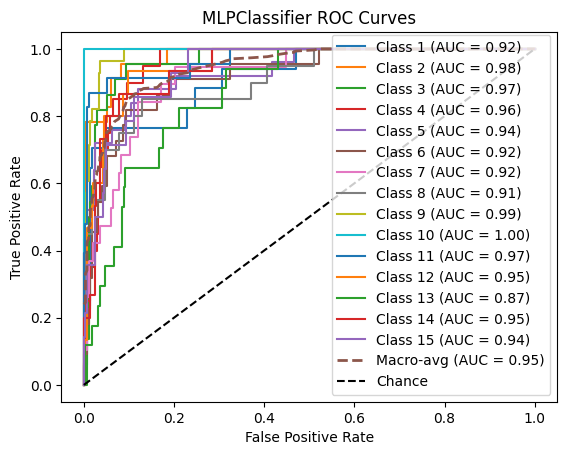

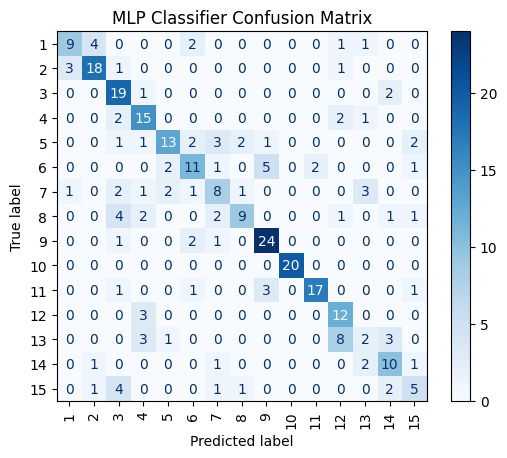

              precision    recall  f1-score   support

           1       0.69      0.53      0.60        17
           2       0.75      0.78      0.77        23
           3       0.54      0.86      0.67        22
           4       0.58      0.75      0.65        20
           5       0.72      0.52      0.60        25
           6       0.58      0.50      0.54        22
           7       0.47      0.42      0.44        19
           8       0.69      0.45      0.55        20
           9       0.73      0.86      0.79        28
          10       1.00      1.00      1.00        20
          11       0.89      0.74      0.81        23
          12       0.48      0.80      0.60        15
          13       0.22      0.12      0.15        17
          14       0.56      0.67      0.61        15
          15       0.45      0.36      0.40        14

    accuracy                           0.64       300
   macro avg       0.62      0.62      0.61       300
weighted avg       0.64   

feature_set                model   cv_type  cv_accuracy  \
0   Feature_W100_Olap0  ANN (MLPClassifier)  KFold-5F     0.502857   
1  Feature_W100_Olap50  ANN (MLPClassifier)  KFold-5F     0.502857   
2   Feature_W200_Olap0  ANN (MLPClassifier)  KFold-5F     0.527143   
3  Feature_W200_Olap50  ANN (MLPClassifier)  KFold-5F     0.545714   
4   Feature_W300_Olap0  ANN (MLPClassifier)  KFold-5F     0.568571   
5  Feature_W300_Olap50  ANN (MLPClassifier)  KFold-5F     0.572857   
6   Feature_W400_Olap0  ANN (MLPClassifier)  KFold-5F     0.571429   
7  Feature_W400_Olap50  ANN (MLPClassifier)  KFold-5F     0.574286   
8   Feature_W500_Olap0  ANN (MLPClassifier)  KFold-5F     0.570000   
9  Feature_W500_Olap50  ANN (MLPClassifier)  KFold-5F     0.621429   

   cv_precision  cv_recall     cv_f1  
0      0.500861   0.502156  0.490371  
1      0.516124   0.502499  0.481948  
2      0.502322   0.498626  0.486436  
3      0.528471   0.529250  0.514200  
4      0.571335   0.562631  0.547257  
5      0.566603   0.571908  0.549450  
6      0.573950   0.563608  0.549067  
7      0.570166   0.579263  0.558762  
8      0.583245   0.582688  0.563835  
9      0.605581   0.604951  0.588578


=== Hyperparameter & Test Summary ===


feature_set                model tuning_method  \
0   Feature_W100_Olap0  ANN (MLPClassifier)  GridSearchCV   
1  Feature_W100_Olap50  ANN (MLPClassifier)  GridSearchCV   
2   Feature_W200_Olap0  ANN (MLPClassifier)  GridSearchCV   
3  Feature_W200_Olap50  ANN (MLPClassifier)  GridSearchCV   
4   Feature_W300_Olap0  ANN (MLPClassifier)  GridSearchCV   
5  Feature_W300_Olap50  ANN (MLPClassifier)  GridSearchCV   
6   Feature_W400_Olap0  ANN (MLPClassifier)  GridSearchCV   
7  Feature_W400_Olap50  ANN (MLPClassifier)  GridSearchCV   
8   Feature_W500_Olap0  ANN (MLPClassifier)  GridSearchCV   
9  Feature_W500_Olap50  ANN (MLPClassifier)  GridSearchCV   

                                         best_params  test_accuracy  \
0  {'clf__activation': 'tanh', 'clf__alpha': 0.01...       0.526667   
1  {'clf__activation': 'relu', 'clf__alpha': 0.01...       0.570000   
2  {'clf__activation': 'relu', 'clf__alpha': 0.00...       0.506667   
3  {'clf__activation': 'tanh', 'clf__alpha': 0.01...       0.600000   
4  {'clf__activation': 'tanh', 'clf__alpha': 0.00...       0.566667   
5  {'clf__activation': 'relu', 'clf__alpha': 0.01...       0.583333   
6  {'clf__activation': 'tanh', 'clf__alpha': 0.01...       0.580000   
7  {'clf__activation': 'tanh', 'clf__alpha': 0.00...       0.610000   
8  {'clf__activation': 'tanh', 'clf__alpha': 0.01...       0.623333   
9  {'clf__activation': 'relu', 'clf__alpha': 0.01...       0.640000   

   test_precision  test_recall   test_f1  test_roc_auc  
0        0.519247     0.520212  0.512930      0.915239  
1        0.561085     0.556065  0.550719      0.892468  
2        0.507282     0.495820  0.492923      0.899941  
3        0.572558     0.572242  0.567724      0.908476  
4        0.572219     0.554990  0.556376      0.927858  
5        0.569255     0.556946  0.556139      0.910482  
6        0.581134     0.567302  0.566145      0.913333  
7        0.602452     0.597690  0.595128      0.926474  
8        0.633410     0.614157  0.615635      0.942318  
9        0.624032     0.623629  0.611483      0.946199

In [ ]:
# 1) Mount & Imports
from google.colab import drive
drive.mount('/content/drive')

import glob, pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, auc,
    ConfusionMatrixDisplay, classification_report
)

# 2) Locate feature files
feature_paths = sorted(glob.glob(
    '/content/drive/MyDrive/Machine Learning Project/Output/Feature_W*_Olap*.csv'
))

# 3) Prepare containers & CV setup
records = []
kf       = KFold(n_splits=5, shuffle=True, random_state=42)
scoring  = {
    'accuracy':  'accuracy',
    'precision': 'precision_macro',
    'recall':    'recall_macro',
    'f1':        'f1_macro'
}

# 4) Loop over each feature‐set
for path in feature_paths:
    print(f"\n>> Processing {path.split('/')[-1]} <<")
    df = pd.read_csv(path)
    # drop text cols, coerce numeric, drop NaNs
    for txt in ['Activity','Exp ID']:
        if txt in df:
            df.drop(columns=txt, inplace=True)
    for c in df.columns:
        if c!='Activity No':
            df[c] = pd.to_numeric(df[c], errors='coerce')
    df.dropna(inplace=True)

    # quick‐test
    df = df.sample(n=min(5000,len(df)), random_state=42)

    X = df.drop('Activity No', axis=1)
    y = df['Activity No'].astype(int)
    Xtr, Xte, ytr, yte = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=42
    )

    # 5) GridSearchCV setup
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clf',    MLPClassifier(max_iter=500, random_state=42))
    ])
    grid = GridSearchCV(
        estimator=pipe,
        param_grid={
            'clf__hidden_layer_sizes': [(50,), (100,), (100,50)],
            'clf__activation':         ['relu','tanh','logistic'],
            'clf__solver':             ['adam','sgd'],
            'clf__alpha':              [1e-4, 1e-3, 1e-2],
            'clf__learning_rate':      ['constant','adaptive']
        },
        scoring=scoring,
        refit='accuracy',
        cv=kf,
        n_jobs=-1
    )
    grid.fit(Xtr, ytr)
    best = grid.best_estimator_

    # 6) Extract CV metrics
    cv = grid.cv_results_
    i  = grid.best_index_
    cv_acc   = cv['mean_test_accuracy'][i]
    cv_prec  = cv['mean_test_precision'][i]
    cv_rec   = cv['mean_test_recall'][i]
    cv_f1    = cv['mean_test_f1'][i]

    # 7) Test metrics
    ypred    = best.predict(Xte)
    test_acc = accuracy_score(yte, ypred)
    test_prec= precision_score(yte, ypred, average='macro', zero_division=0)
    test_rec = recall_score(yte, ypred, average='macro', zero_division=0)
    test_f1  = f1_score(yte, ypred, average='macro', zero_division=0)

    # 8) Compute & plot ROC curves if possible
    if hasattr(best, "predict_proba"):
        proba      = best.predict_proba(Xte)
        # Binarize true labels
        classes    = best.classes_
        yte_bin    = label_binarize(yte, classes=classes)
        n_classes  = yte_bin.shape[1]

        # Compute per-class ROC
        fpr, tpr, roc_auc = {}, {}, {}
        for idx in range(n_classes):
            fpr[idx], tpr[idx], _ = roc_curve(yte_bin[:, idx], proba[:, idx])
            roc_auc[idx]          = auc(fpr[idx], tpr[idx])

        # Macro-average ROC
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= n_classes
        fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
        roc_auc["macro"]            = auc(fpr["macro"], tpr["macro"])

        test_roc = roc_auc["macro"]

        # Plot ROC curves
        plt.figure()
        for i in range(n_classes):
            plt.plot(
                fpr[i], tpr[i],
                label=f"Class {classes[i]} (AUC = {roc_auc[i]:.2f})"
            )
        plt.plot(
            fpr["macro"], tpr["macro"],
            linestyle='--', linewidth=2,
            label=f"Macro‐avg (AUC = {roc_auc['macro']:.2f})"
        )
        plt.plot([0,1], [0,1], 'k--', label='Chance')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("MLPClassifier ROC Curves")
        plt.legend(loc="lower right")
        plt.show()
    else:
        test_roc = None

    # 9) Confusion matrix & report
    ConfusionMatrixDisplay.from_estimator(
        best, Xte, yte,
        display_labels=classes,
        cmap=plt.cm.Blues,
        xticks_rotation='vertical'
    )
    plt.title("MLP Classifier Confusion Matrix")
    plt.show()
    print(classification_report(yte, ypred, zero_division=0))

    # 10) Record results
    records.append({
        'feature_set':    path.split('/')[-1].replace('.csv',''),
        'model':          'ANN (MLPClassifier)',
        'tuning_method':  'GridSearchCV',
        'cv_type':        'KFold-5F',
        'best_params':    grid.best_params_,
        'cv_accuracy':    cv_acc,
        'cv_precision':   cv_prec,
        'cv_recall':      cv_rec,
        'cv_f1':          cv_f1,
        'test_accuracy':  test_acc,
        'test_precision': test_prec,
        'test_recall':    test_rec,
        'test_f1':        test_f1,
        'test_roc_auc':   test_roc
    })

# 11) Create summary tables
df_res        = pd.DataFrame(records)
cv_summary    = df_res[
    ['feature_set','model','cv_type','cv_accuracy','cv_precision','cv_recall','cv_f1']
]
test_summary  = df_res[
    ['feature_set','model','tuning_method','best_params',
     'test_accuracy','test_precision','test_recall','test_f1','test_roc_auc']
]

print("=== Cross-Validation Summary ===")
display(cv_summary)

print("\n=== Hyperparameter & Test Summary ===")
display(test_summary)


In [3]:
# Step 1: Install necessary packages
!apt-get install -y pandoc texlive-xetex texlive-fonts-recommended texlive-plain-generic

# Step 2: Install nbconvert if not already present
!pip install nbconvert

# Step 3: Convert directly to PDF (bypassing the HTML step)
!jupyter nbconvert --to pdf "/content/drive/MyDrive/Colab Notebooks/Machine_Learning_Final_Project.ipynb" --output-dir "/content/drive/MyDrive/Machine Learning Project/"

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono
  fonts-texgyre fonts-urw-base35 libapache-pom-java
  libcmark-gfm-extensions0.29.0.gfm.3 libcmark-gfm0.29.0.gfm.3
  libcommons-logging-java libcommons-parent-java libfontbox-java libgs9
  libgs9-common libidn12 libijs-0.35 libjbig2dec0 libkpathsea6 libpdfbox-java
  libptexenc1 libruby3.0 libsynctex2 libteckit0 libtexlua53 libtexluajit2
  libwoff1 libzzip-0-13 lmodern pandoc-data poppler-data preview-latex-style
  rake ruby ruby-net-telnet ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0
  rubygems-integration t1utils teckit tex-common tex-gyre texlive-base
  texlive-binaries texlive-latex-base texlive-latex-extra
  texlive-latex-recommended texlive-pictures tipa xfonts-encodings
  xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf lib